# Clear memory, set working directory, load packages

In [2]:
rm(list=ls())
gc()
setwd("/mnt/Data_8TB/Carolina_data/Cell_paper/")
getwd()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,637193,34.1,1411248,75.4,1411248,75.4
Vcells,1183427,9.1,8388608,64.0,1815676,13.9


[1] "/mnt/Data_8TB/Carolina_data/Cell_paper"

In [3]:
library(tidyverse) # metapackage of all tidyverse packages
library(clusterProfiler) # for GO analysis
library(org.Mm.eg.db) # for GO analysis
library(org.Hs.eg.db) # for GO analysis
library(ComplexHeatmap) # for heatmap
library(paletteer) # for color palettes
library(openxlsx) # for writing excel files
library(limma)# for DE analysis
library(ggVennDiagram) # for venn diagrams



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


clusterProfiler v4.8.1  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:purrr’:

    simplify

# Import the data and perform limma analysis

In [14]:
# Load data
data <- read.xlsx("./LIMMA_Muscle.xlsx") 
data <- data[-c(1:3),] # remove first 3 rows
colnames(data) <- data[1,] # set column names
data <- data[-1,] # remove first row
data$gene[is.na(data$gene)] <- paste0("NA_", data$protein[is.na(data$gene)]) # replace NA gene names with NA_protein names
data$gene[is.na(data$gene)]
data$gene <- make.unique(data$gene, sep = "_") # make gene names unique
rownames(data) <- data$gene # set row names
head(data) # check data


character(0)

,protein,AKO1,AKO2,AKO3,AWT1,AWT2,AWT3,JWT1,JWT2,JWT3,NOP,gene,limma_adult_WT-adult_KO,limma_juvenil_WT-adult_KO,limma_juvenil_WT-adult_WT
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ppp4r3b,A0A0G2KC70,2.0724701109999999,5.3395652289999997,1.8406234159999999,1.6077885789999999,1.3381244109999999,-1.027740469,0.73081758200000002,1.0120174959999999,-0.252365226,1,ppp4r3b,3.8682489452696998E-2,3.0686743243339299E-2,0.89097142048171496
ehmt2,A0A0G2KCN9,-1.657059426,2.4307019670000001,1.7876982029999999,1.7745410290000001,2.3514128159999999,2.9184474480000002,-3.7952009329999998,-4.1732668650000004,-4.7583861519999999,NA,ehmt2,0.145130353610849,4.0816666547637502E-4,6.0202278187115498E-5
col28a1b,A0A0G2KCR2,1.9575273870000001,2.6430229430000001,1.700726089,1.2173278169999999,1.360636001,2.0435501189999998,-1.778866635,-1.2636472910000001,-2.182543957,NA,col28a1b,0.21469423904691501,7.2781768224972304E-6,2.6070454335162699E-5
ddb1,A0A0G2KCW6,-0.39903894099999998,-0.94651125300000005,-0.79190209700000003,-1.515391318,-0.60943714599999999,-0.56973958700000005,0.72136138500000002,1.6846036120000001,-5.5399655999999999E-2,12,ddb1,0.71735212798340098,1.46899607676998E-2,8.0602637007416798E-3
comp,A0A0G2KDJ5,-0.57219328000000003,0.47831322799999998,0.47560477499999998,0.22361209500000001,9.9771636999999996E-2,-5.3343110999999999E-2,-0.35637656099999998,-0.82537294999999999,-0.38721354800000002,NA,comp,0.92502927404990098,0.12518921706379199,0.14546810917184499
ptprd,A0A0G2KEA8,-0.12485207199999999,-0.48011836299999999,1.9367150689999999,1.6849041709999999,-0.76818314499999996,1.017179453,-0.43636211499999999,1.367709949,0.74729442300000004,NA,ptprd,0.81502778308908697,0.89267758877828196,0.92089997494228504


In [707]:
data_selected <- data[,c(2:10)] # select only the columns with protein expression data
data_selected <- data_selected %>%  
    mutate_at(c(1:9), as.numeric) # convert each column to numeric
data_selected <- as.matrix(data_selected) # convert to matrix
head(data_selected)

,AKO1,AKO2,AKO3,AWT1,AWT2,AWT3,JWT1,JWT2,JWT3
ppp4r3b,2.0724701,5.3395652,1.8406234,1.6077886,1.33812441,-1.02774047,0.7308176,1.0120175,-0.25236523
ehmt2,-1.6570594,2.4307020,1.7876982,1.7745410,2.35141282,2.91844745,-3.7952009,-4.1732669,-4.75838615
col28a1b,1.9575274,2.6430229,1.7007261,1.2173278,1.36063600,2.04355012,-1.7788666,-1.2636473,-2.18254396
ddb1,-0.3990389,-0.9465113,-0.7919021,-1.5153913,-0.60943715,-0.56973959,0.7213614,1.6846036,-0.05539966
comp,-0.5721933,0.4783132,0.4756048,0.2236121,0.09977164,-0.05334311,-0.3563766,-0.8253729,-0.38721355
ptprd,-0.1248521,-0.4801184,1.9367151,1.6849042,-0.76818314,1.01717945,-0.4363621,1.3677099,0.74729442


In [708]:
# Create metadata
metadata <- data.frame(samples = colnames(data_selected), 
                       group = c(rep("Adult_KO", 3), rep("Adult_WT", 3), rep("Juvenile_WT", 3))) # create metadata dataframe
metadata

samples,group
<chr>,<chr>
AKO1,Adult_KO
AKO2,Adult_KO
AKO3,Adult_KO
AWT1,Adult_WT
AWT2,Adult_WT
AWT3,Adult_WT
JWT1,Juvenile_WT
JWT2,Juvenile_WT
JWT3,Juvenile_WT


In [7]:
# perform limma analysis between scaf and wt to get p-values
design <- model.matrix(~0+metadata$group) # create design matrix
colnames(design) <- c("Adult_KO", "Adult_WT", "Juvenile_WT") # set column names
design 
fit <- lmFit(data_selected, design)
fit 


,Adult_KO,Adult_WT,Juvenile_WT
1,1,0,0
2,1,0,0
3,1,0,0
4,0,1,0
5,0,1,0
6,0,1,0
7,0,0,1
8,0,0,1
9,0,0,1


An object of class "MArrayLM"
$coefficients
           Adult_KO    Adult_WT Juvenile_WT
ppp4r3b   3.0842196  0.63939084   0.4968233
ehmt2     0.8537802  2.34813376  -4.2422847
col28a1b  2.1004255  1.54050465  -1.7416860
ddb1     -0.7124841 -0.89818935   0.7835218
comp      0.1272416  0.09001354  -0.5229877
2097 more rows ...

$rank
[1] 3

$assign
[1] 1 1 1

$qr
$qr
    Adult_KO   Adult_WT Juvenile_WT
1 -1.7320508  0.0000000   0.0000000
2  0.5773503 -1.7320508   0.0000000
3  0.5773503  0.0000000  -1.7320508
4  0.0000000  0.5773503   0.0000000
5  0.0000000  0.5773503   0.0000000
6  0.0000000  0.5773503   0.0000000
7  0.0000000  0.0000000   0.5773503
8  0.0000000  0.0000000   0.5773503
9  0.0000000  0.0000000   0.5773503
attr(,"assign")
[1] 1 1 1
attr(,"contrasts")
attr(,"contrasts")$`metadata$group`
[1] "contr.treatment"


$qraux
[1] 1.57735 1.00000 1.00000

$pivot
[1] 1 2 3

$tol
[1] 1e-07

$rank
[1] 3


$df.residual
[1] 6 6 6 6 6
2097 more elements ...

$sigma
  ppp4r3b     ehmt2  col2

In [8]:
# "Adult_KO", "Adult_WT", "Juvenile_WT"
cont_matrix <- makeContrasts( # create contrast matrix
adult_ko_vs_adult_wt=Adult_KO-Adult_WT, 
adult_ko_vs_juvenile_wt=Adult_KO-Juvenile_WT,
adult_wt_vs_juvenile_wt=Adult_WT-Juvenile_WT,
levels=design)
cont_matrix # check contrast matrix
fit2 <- contrasts.fit(fit, cont_matrix) # fit contrast matrix
fit2 <- eBayes(fit2) # perform empirical bayes analysis
# fit2

,adult_ko_vs_adult_wt,adult_ko_vs_juvenile_wt,adult_wt_vs_juvenile_wt
Adult_KO,1,1,0
Adult_WT,-1,0,1
Juvenile_WT,0,-1,-1


In [10]:
adult_ko_vs_adult_wt <- topTable(fit2, coef = 1, adjust.method = "BH", sort.by = "p", number = Inf) # get full table
adult_ko_vs_adult_wt <- adult_ko_vs_adult_wt %>% dplyr::select(logFC, P.Value, adj.P.Val) # select only logFC, P.Value, adj.P.Val columns
colnames(adult_ko_vs_adult_wt) <- paste0("adult_ko_vs_adult_wt_",colnames(adult_ko_vs_adult_wt)) # rename columns
adult_ko_vs_adult_wt <- adult_ko_vs_adult_wt %>% rownames_to_column("gene") # add gene column
adult_ko_vs_adult_wt %>% 


adult_ko_vs_juvenile_wt <- topTable(fit2, coef = 2, adjust.method = "BH", sort.by = "p", number = Inf) # get full table
adult_ko_vs_juvenile_wt <- adult_ko_vs_juvenile_wt %>% dplyr::select(logFC, P.Value, adj.P.Val) # select only logFC, P.Value, adj.P.Val columns
colnames(adult_ko_vs_juvenile_wt) <- paste0("adult_ko_vs_juvenile_wt_",colnames(adult_ko_vs_juvenile_wt)) # rename columns
adult_ko_vs_juvenile_wt <- adult_ko_vs_juvenile_wt %>% rownames_to_column("gene") # add gene column
adult_ko_vs_juvenile_wt %>% head

adult_wt_vs_juvenile_wt <- topTable(fit2, coef = 3, adjust.method = "BH", sort.by = "p", number = Inf) # get full table
adult_wt_vs_juvenile_wt <- adult_wt_vs_juvenile_wt %>% dplyr::select(logFC, P.Value, adj.P.Val) # select only logFC, P.Value, adj.P.Val columns
colnames(adult_wt_vs_juvenile_wt) <- paste0("adult_wt_vs_juvenile_wt_",colnames(adult_wt_vs_juvenile_wt)) # rename columns
adult_wt_vs_juvenile_wt <- adult_wt_vs_juvenile_wt %>% rownames_to_column("gene") # add gene column
adult_wt_vs_juvenile_wt %>% head # check data


,gene,adult_ko_vs_adult_wt_logFC,adult_ko_vs_adult_wt_P.Value,adult_ko_vs_adult_wt_adj.P.Val
,<chr>,<dbl>,<dbl>,<dbl>
1,cox7a1,-7.090382,8.497674e-08,0.0001786211
2,dnm2a,3.418267,1.055365e-05,0.0071750944
3,cox5aa,-5.075714,1.332007e-05,0.0071750944
4,cox5ab,-6.305060,1.365384e-05,0.0071750944
5,decr1,3.735197,1.728903e-05,0.0072683078
6,ptgr1.1,6.343476,2.480240e-05,0.0086891062


,gene,adult_ko_vs_juvenile_wt_logFC,adult_ko_vs_juvenile_wt_P.Value,adult_ko_vs_juvenile_wt_adj.P.Val
,<chr>,<dbl>,<dbl>,<dbl>
1,gstr,8.173132,2.016344e-09,4.238356e-06
2,rpl23,-6.813533,6.696831e-09,7.038369e-06
3,rpl23a,-7.704851,1.930364e-08,1.352542e-05
4,rps8,-9.093287,3.722932e-08,1.369146e-05
5,myha,-12.315355,4.688831e-08,1.369146e-05
6,eef1a1l1,-7.219879,5.401093e-08,1.369146e-05


,gene,adult_wt_vs_juvenile_wt_logFC,adult_wt_vs_juvenile_wt_P.Value,adult_wt_vs_juvenile_wt_adj.P.Val
,<chr>,<dbl>,<dbl>,<dbl>
1,rpl23,-7.979944,1.647233e-09,1.898943e-06
2,gstr,8.274604,1.806796e-09,1.898943e-06
3,rpl23a,-8.594055,7.360111e-09,3.896835e-06
4,aars1,-5.974487,1.128217e-08,3.896835e-06
5,rps8,-10.404265,1.137604e-08,3.896835e-06
6,myha,-14.393014,1.189957e-08,3.896835e-06


In [11]:
# merge data, adult_ko_vs_adult_wt, adult_ko_vs_juvenile_wt, adult_wt_vs_juvenile_wt by column gene
data_merged <- Reduce(function(x, y) merge(x, y, by = "gene", all = TRUE), list(data,adult_ko_vs_adult_wt, adult_ko_vs_juvenile_wt, adult_wt_vs_juvenile_wt)) # merge data
data_merged <- data_merged %>% dplyr::select(-contains("limma")) # remove columns with limma
# remove _* from gene column
data_merged$gene <- gsub("_.", "", data_merged$gene) # remove _* from gene column

data_merged %>% head

[1] 2102   21

[1] 2102    4

[1] 2102    4

[1] 2102    4

,gene,protein,AKO1,AKO2,AKO3,AWT1,AWT2,AWT3,JWT1,JWT2,⋯,NOP,adult_ko_vs_adult_wt_logFC,adult_ko_vs_adult_wt_P.Value,adult_ko_vs_adult_wt_adj.P.Val,adult_ko_vs_juvenile_wt_logFC,adult_ko_vs_juvenile_wt_P.Value,adult_ko_vs_juvenile_wt_adj.P.Val,adult_wt_vs_juvenile_wt_logFC,adult_wt_vs_juvenile_wt_P.Value,adult_wt_vs_juvenile_wt_adj.P.Val
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,aamdc,Q502H1,1.4667514749999999,-0.57394845500000002,-1.865304979,0.26725442700000002,-0.230769002,0.92128396800000001,-1.536211075,-1.174814083,⋯,2,-0.6434238,0.428266461,0.7354707,1.3663031,1.119573e-01,2.046385e-01,2.00972692,2.912478e-02,6.375192e-02
2,aars1,A0A286YAH8,-1.3534255310000001,-1.5746633350000001,-1.7947351979999999,-2.8319766020000001,-2.542003233,-2.6800582739999999,3.368298625,3.384737796,⋯,8,1.1104047,0.005605508,0.1292790,-4.8640821,6.871702e-08,1.369146e-05,-5.97448680,1.128217e-08,3.896835e-06
3,aass,E7FD66,0.72979587800000001,1.3124486870000001,0.28941101699999999,0.53375739300000002,5.7441854000000001E-2,-0.98537361499999998,-0.51106879999999999,-1.3092886850000001,⋯,10,0.9086100,0.209867021,0.5516651,0.9822496,1.783354e-01,2.943734e-01,0.07363959,9.152619e-01,9.389363e-01
4,abcb10,F1Q5K6,0.28526026100000001,1.2430460109999999,0.62267675099999997,0.21875262100000001,9.6634668000000007E-2,0.78061942900000003,1.5690452180000001,1.309378237,⋯,6,0.3516588,0.396607169,0.7192996,-0.5189040,2.215346e-01,3.462329e-01,-0.87056279,5.498750e-02,1.073201e-01
5,abcb11a,F6NLY2,0.61393354499999997,2.1746057840000002,1.228077936,0.54923656200000004,-5.5627693789999997,-2.2331745879999998,-0.342762012,-0.12751521099999999,⋯,NA,3.7544416,0.014721473,0.1719141,1.5589671,2.430795e-01,3.686733e-01,-2.19547447,1.123521e-01,1.872414e-01
6,abcb11b,A0A0R4IVE7,0.39718075600000002,-0.26571057799999998,-0.65732705599999997,-1.4526888E-2,0.54376250999999998,-0.51489119800000005,1.291293249,-0.16315270000000001,⋯,1,-0.1800671,0.727444898,0.8980345,-0.8771546,1.136859e-01,2.063625e-01,-0.69708753,1.972875e-01,2.918355e-01


# Add annotation

In [4]:
# pull decription of genes from biomart and merge it to data_merged
# get the description of the genes
library(biomaRt)
zf_mart <- useMart("ensembl", dataset = "drerio_gene_ensembl") # set biomart
description_df <- getBM(attributes = c("ensembl_gene_id", # get ensemble gene id
                                        "zfin_id_symbol", # get zfin id
                                        "description", # get description
                                        "definition_1006", # get definition from GO
                                        "name_1006",# get name from GO
                                        "namespace_1003", # get namespace from GO (molecular function, biological process, cellular component)
                                        "phenotype_description"), # get phenotype description
                     filters = "zfin_id_symbol", # filter by zfin id
                     values = data_merged$gene, # values as input for filter
                     mart = zf_mart) # set biomart
head(description_df)


,ensembl_gene_id,zfin_id_symbol,description,definition_1006,name_1006,namespace_1003,phenotype_description
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSDARG00000103957,aamdc,"adipogenesis associated, Mth938 domain containing [Source:ZFIN;Acc:ZDB-GENE-050522-64]",,,,
2,ENSDARG00000069142,aars1,alanyl-tRNA synthetase 1 [Source:ZFIN;Acc:ZDB-GENE-030131-3663],Binding to a metal ion.,metal ion binding,molecular_function,caudal fin morphology
3,ENSDARG00000069142,aars1,alanyl-tRNA synthetase 1 [Source:ZFIN;Acc:ZDB-GENE-030131-3663],"Binding to ATP, adenosine 5'-triphosphate, a universally important coenzyme and enzyme regulator.",ATP binding,molecular_function,caudal fin morphology
4,ENSDARG00000069142,aars1,alanyl-tRNA synthetase 1 [Source:ZFIN;Acc:ZDB-GENE-030131-3663],Binding to a nucleic acid.,nucleic acid binding,molecular_function,caudal fin morphology
5,ENSDARG00000069142,aars1,alanyl-tRNA synthetase 1 [Source:ZFIN;Acc:ZDB-GENE-030131-3663],"Binding to a nucleotide, any compound consisting of a nucleoside that is esterified with (ortho)phosphate or an oligophosphate at any hydroxyl group on the ribose or deoxyribose.",nucleotide binding,molecular_function,caudal fin morphology
6,ENSDARG00000069142,aars1,alanyl-tRNA synthetase 1 [Source:ZFIN;Acc:ZDB-GENE-030131-3663],Binding to an RNA molecule or a portion thereof.,RNA binding,molecular_function,caudal fin morphology


In [5]:
# collapse duplicated genes(zfin_id_symbol) to one row
description_df <- description_df %>% 
    group_by(zfin_id_symbol) %>% 
    summarise(description = paste0(unique(description), collapse = "; "), 
              definition_1006 = paste0(unique(definition_1006), collapse = "; "), 
              phenotype_description = paste0(unique(phenotype_description), collapse = "; "),
              name_1006 = paste0(unique(name_1006), collapse = "; "),
              namespace_1003 = paste0(unique(namespace_1003), collapse = "; ")
              )
# rename zfin_id_symbol to gene and definition_1006 to GO_description, decription to gene_full_name, phenotype_decription to associated_phenotype using dplyr::rename
description_df <- description_df %>% 
    dplyr::rename(gene = zfin_id_symbol, 
                  "GO_description" = definition_1006, 
                  "gene_full_name" = description, 
                  "associated_phenotype" = phenotype_description,
                  "GO_name" = name_1006,
                  "GO_family" = namespace_1003)
head(description_df,2)



gene,gene_full_name,GO_description,associated_phenotype,GO_name,GO_family
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
aamdc,"adipogenesis associated, Mth938 domain containing [Source:ZFIN;Acc:ZDB-GENE-050522-64]",,,,
aars1,alanyl-tRNA synthetase 1 [Source:ZFIN;Acc:ZDB-GENE-030131-3663],"Binding to a metal ion.; Binding to ATP, adenosine 5'-triphosphate, a universally important coenzyme and enzyme regulator.; Binding to a nucleic acid.; Binding to a nucleotide, any compound consisting of a nucleoside that is esterified with (ortho)phosphate or an oligophosphate at any hydroxyl group on the ribose or deoxyribose.; Binding to an RNA molecule or a portion thereof.; A semiautonomous, self replicating organelle that occurs in varying numbers, shapes, and sizes in the cytoplasm of virtually all eukaryotic cells. It is notably the site of tissue respiration.; Catalysis of the formation of aminoacyl-tRNA from ATP, amino acid, and tRNA with the release of diphosphate and AMP.; Catalysis of the joining of two molecules, or two groups within a single molecule, using the energy from the hydrolysis of ATP, a similar triphosphate, or a pH gradient.; The cellular metabolic process in which a protein is formed, using the sequence of a mature mRNA or circRNA molecule to specify the sequence of amino acids in a polypeptide chain. Translation is mediated by the ribosome, and begins with the formation of a ternary complex between aminoacylated initiator methionine tRNA, GTP, and initiation factor 2, which subsequently associates with the small subunit of the ribosome and an mRNA or circRNA. Translation ends with the release of a polypeptide chain from the ribosome.; The chemical reactions and pathways by which the various amino acids become bonded to their corresponding tRNAs. The most common route for synthesis of aminoacyl tRNA is by the formation of an ester bond between the 3'-hydroxyl group of the most 3' adenosine of the tRNA and the alpha carboxylic acid group of an amino acid, usually catalyzed by the cognate aminoacyl-tRNA ligase. A given aminoacyl-tRNA ligase aminoacylates all species of an isoaccepting group of tRNA molecules.; Binding to a transfer RNA.; The contents of a cell excluding the plasma membrane and nucleus, but including other subcellular structures.; Binding to an amino acid, organic acids containing one or more amino substituents.; Binding to a zinc ion (Zn).; Any process which detects an amino-acid acetylated tRNA is charged with the correct amino acid, or removes incorrect amino acids from a charged tRNA. This process can be performed by tRNA synthases, or by subsequent reactions after tRNA aminoacylation.; The covalent alteration of one or more nucleotides within a tRNA molecule to produce a tRNA molecule with a sequence that differs from that coded genetically.; The hydrolysis of an incorrectly aminoacylated tRNA.; Catalysis of the reaction: ATP + L-alanine + tRNA(Ala) = AMP + diphosphate + L-alanyl-tRNA(Ala).; The process of coupling alanine to alanyl-tRNA, catalyzed by alanyl-tRNA synthetase. The alanyl-tRNA synthetase is a class-II synthetases. The activated amino acid is transferred to the 3'-OH group of an alanine accetping tRNA.; The chemical reactions and pathways involving tRNA, transfer RNA, a class of relatively small RNA molecules responsible for mediating the insertion of amino acids into the sequence of nascent polypeptide chains during protein synthesis. Transfer RNA is characterized by the presence of many unusual minor bases, the function of which has not been completely established.; Catalytic activity that acts to modify a tRNA.",caudal fin morphology; eye decreased size; motor neuron spatial pattern; whole organism curved; whole organism decreased length; whole organism morphology,"metal ion binding; ATP binding; nucleic acid binding; nucleotide binding; RNA binding; mitochondrion; aminoacyl-tRNA ligase activity; ligase activity; translation; tRNA aminoacylation; tRNA binding; cytoplasm; amino acid binding;

In [6]:
df_merged_description <- merge(data_merged, description_df, by.x = "gene", by.y = "gene", all.x = TRUE)
head(df_merged_description,1)

,gene,protein,AKO1,AKO2,AKO3,AWT1,AWT2,AWT3,JWT1,JWT2,⋯,adult_ko_vs_juvenile_wt_P.Value,adult_ko_vs_juvenile_wt_adj.P.Val,adult_wt_vs_juvenile_wt_logFC,adult_wt_vs_juvenile_wt_P.Value,adult_wt_vs_juvenile_wt_adj.P.Val,gene_full_name,GO_description,associated_phenotype,GO_name,GO_family
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,aamdc,Q502H1,1.4667514749999999,-0.57394845500000002,-1.865304979,0.26725442700000002,-0.230769002,0.92128396800000001,-1.536211075,-1.174814083,⋯,0.1119573,0.2046385,2.009727,0.02912478,0.06375192,"adipogenesis associated, Mth938 domain containing [Source:ZFIN;Acc:ZDB-GENE-050522-64]",,,,


In [34]:
write.csv(df_merged_description, file = "./LIMMA_Muscle_logfc_description.csv", row.names = FALSE)

In [11]:
write.csv(data_merged, file = "./LIMMA_Muscle_logfc.csv", row.names = FALSE)


# Perform Pathway analysis

## GO analysis

In [5]:
GO_function <- function(gene_list, pval  = 0.05, onto= "MF", prefix="", org="mouse"){
library(clusterProfiler)
library(org.Mm.eg.db)
library(org.Hs.eg.db)
library(ReactomePA)
if(org=="mouse"){
    orgdb <- "org.Mm.eg.db"
    org_reactome <- "mouse"
}else if(org=="human"){
    orgdb <- "org.Hs.eg.db"
    org_reactome <- "human"
}else{
    message("Please enter a valid organism (mouse or human)")
}

    if(onto %in% c("MF", "CC", "BP")){
        
    
    compGO <- enrichGO(gene = gene_list, pvalueCutoff  = pval,keyType = "SYMBOL",
                             pAdjustMethod = "BH",OrgDb = orgdb, ont = onto)
    }else if(onto=="reactome"){
        gene_list <- bitr(gene_list, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = orgdb)
        gene_list <- gene_list$ENTREZID
        compGO <- enrichPathway(gene = gene_list, pvalueCutoff  = 0.05, organism= org_reactome,      readable = TRUE)
    
    }else{
        message("Please enter a valid GO term")
    }

      
    
    if(is.null(compGO)){
    message(paste0("No GO:",onto, " obtained"))
    message(paste0("****************************************************************************************"))
    message(paste0("\n"))
   
    }else {

        compGO_df <- as.data.frame(compGO)
        compGO_df$GeneRatio_decimal <- compGO_df$GeneRatio
        compGO_df$GeneRatio_decimal <- sapply(compGO_df$GeneRatio_decimal, 
                                                      function(x) (eval(parse(text = as.character(x)))))
        compGO_df$BgRatio_decimal <- compGO_df$BgRatio
        compGO_df$BgRatio_decimal <- sapply(compGO_df$BgRatio_decimal, 
                                                    function(x) (eval(parse(text = as.character(x)))))
        compGO_df <- compGO_df %>% tidyr::separate_rows(geneID, sep = "/", convert = FALSE) %>%
          arrange(desc(GeneRatio_decimal))
        compGO_df %>% head 

            if(nrow(compGO_df)==0){
            message(paste0("No GP:",onto, " obtained"))
            message(paste0("****************************************************************************************"))
            message(paste0("\n"))

            } else{

            write.csv(compGO_df, paste0(prefix,"_GO_",onto, "_pathways.csv"))


            full_name= switch(onto,
                    MF= "Moleuclar Function",
                    CC= "Cellular Components",
                    BP= "Biological Pathways",
                    reactome= "Reactome Pathways"
                             )                                           

            print(dotplot(compGO, showCategory = 15, title = paste0("GO Pathway Enrichment Analysis \n",full_name), 
                    font.size = 12))
            dev.copy(
            pdf,
            file = paste0(prefix,"_GO_",onto, "_pathways.pdf"),
            width = 10,
            height = 12
            )
            dev.off ()




        message(paste0("Pathway analysis GO:",onto, " for Cell Type : ", " done"))
        message(paste0("****************************************************************************************"))
        message(paste0("\n"))

        }
    }
}

In [7]:
# Function to convert zebrafish gene names to human gene names
convertDanioGeneList_Mouse <- function(x){ 
  require("biomaRt") # load biomaRt package
  mouse = useEnsembl("ensembl", dataset = "mmusculus_gene_ensembl", host = "https://dec2021.archive.ensembl.org") # use human mart
  danio = useEnsembl("ensembl", dataset = "drerio_gene_ensembl", host = "https://dec2021.archive.ensembl.org") # use zebrafish mart
  
  genesV2 = getLDS(attributes = c("ensembl_gene_id", "zfin_id_symbol"), 
                  filters = "zfin_id_symbol", # get zebrafish gene names
                  values = x , # use the zebrafish gene names
                  mart = danio,  # use the zebrafish mart
                  attributesL = c("mgi_symbol", "ensembl_gene_id", "description"
                                       ), # get human gene names
                  martL = mouse, uniqueRows=T) # use the human mart
  
  colnames(genesV2)[colnames(genesV2)== "Gene.stable.ID"] <- "EnsmblID_Zebrafish" # rename columns
  colnames(genesV2)[colnames(genesV2)== "Gene.stable.ID.1"] <- "EnsmblID_Mouse" # rename columns
  
  # Print the first 6 genes found to the screen
  # print(head(genesV2))
  return(genesV2) # return the genes
}



In [7]:
mouse_genes <- convertDanioGeneList_Mouse(df_merged_description$gene)
colnames(mouse_genes)

[1] "EnsmblID_Zebrafish" "ZFIN.symbol"        "MGI.symbol"        
[4] "EnsmblID_Mouse"     "Gene.description"

In [300]:
df_merged_description[grepl("kif",df_merged_description$gene),]

,gene,protein,AKO1,AKO2,AKO3,AWT1,AWT2,AWT3,JWT1,JWT2,⋯,adult_ko_vs_juvenile_wt_P.Value,adult_ko_vs_juvenile_wt_adj.P.Val,adult_wt_vs_juvenile_wt_logFC,adult_wt_vs_juvenile_wt_P.Value,adult_wt_vs_juvenile_wt_adj.P.Val,gene_full_name,GO_description,associated_phenotype,GO_name,GO_family
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
836,kif13bb,E7F084,-1.903475904,-3.1895115280000002,-2.904640949,-1.4834480940000001,-1.199769455,-1.362296502,2.4633219099999999,2.6883170399999998,⋯,5.249980e-07,2.239241e-05,-3.7623647,6.581229e-06,0.0001064134,NA,NA,NA,NA,NA
837,kif16ba,A0A0R4ILH1,2.5694946939999999,-0.98924008699999999,0.24123428399999999,0.66780278599999998,0.91302760400000005,0.59957213899999995,-0.18712866,1.084112261,⋯,2.907215e-01,4.211555e-01,1.2832251,2.470788e-01,0.3487976197,NA,NA,NA,NA,NA
838,kif18a,B0V302,0.74118510500000001,0.95151501699999996,1.387779482,0.37583916000000001,0.39528257700000002,-7.5952352000000001E-2,-0.27953447399999998,-0.66200806400000001,⋯,2.410375e-03,1.178281e-02,0.6218772,1.006260e-01,0.1718560814,kinesin family member 18A [Source:ZFIN;Acc:ZDB-GENE-040426-862],"A microtubule-based process that results in the movement of organelles, other microtubules, or other cellular components. Examples include motor-driven movement along microtubules and movement driven by polymerization or depolymerization of microtubules.; A motor activity that generates movement along a microtubule, driven by ATP hydrolysis.; Binding to a microtubule, a filament composed of tubulin monomers.; Binding to ATP, adenosine 5'-triphosphate, a universally important coenzyme and enzyme regulator.",,microtubule-based movement; microtubule motor activity; microtubule binding; ATP binding,biological_process; molecular_function


In [297]:
mouse_genes[grepl("kif",mouse_genes$ZFIN.symbol),]

,EnsmblID_Zebrafish,ZFIN.symbol,MGI.symbol,EnsmblID_Mouse,Gene.description
,<chr>,<chr>,<chr>,<chr>,<chr>
100,ENSDARG00000073859,kif13bb,Kif13b,ENSMUSG00000060012,kinesin family member 13B [Source:MGI Symbol;Acc:MGI:1098265]


In [8]:
 mouse_genes$MGI.symbol %>% tail

[1] "Fyco1"   "Ppip5k2" "Tubgcp2" "Edf1"    "Furin"   "Acadl"

In [290]:
biomaRt::listAttributes(mmu_mart)[grep("GO", biomaRt::listAttributes(mmu_mart)$description),]

,name,description,page
,<chr>,<chr>,<chr>
42,go_id,GO term accession,feature_page
43,name_1006,GO term name,feature_page
44,definition_1006,GO term definition,feature_page
45,go_linkage_type,GO term evidence code,feature_page
46,namespace_1003,GO domain,feature_page
47,goslim_goa_accession,GOSlim GOA Accession(s),feature_page
48,goslim_goa_description,GOSlim GOA Description,feature_page


In [16]:
# pull decription of genes from biomart and merge it to data_merged
# get the description of the genes

# Create an empty dataframe to store the results
description_df_mouse <- data.frame()

# Loop through the values in batches of 10
for (i in seq(1, length(unique(mouse_genes$MGI.symbol)), by = 10)) {
    # Get the current batch of values
    batch_values <- unique(mouse_genes$MGI.symbol)[i:(i+9)]
    mmu_mart <- useMart("ensembl", dataset = "mmusculus_gene_ensembl")
    # Query biomart for the description of the genes
    results_df <- getBM(attributes = c("mgi_symbol", "description", 
                                     "definition_1006",
                                    "name_1006", "namespace_1003",
                                    "phenotype_description"), 
                        filters = "mgi_symbol", 
                        values = batch_values, 
                        mart = mmu_mart,
                        uniqueRows = TRUE)

    # Append the results to the dataframe
    description_df_mouse <- rbind(results_df, description_df_mouse)
}

# Print the results
head(description_df_mouse)


,mgi_symbol,description,definition_1006,name_1006,namespace_1003,phenotype_description
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Acadl,"acyl-Coenzyme A dehydrogenase, long-chain [Source:MGI Symbol;Acc:MGI:87866]","Binding to FAD, flavin-adenine dinucleotide, the coenzyme or the prosthetic group of various flavoprotein oxidoreductase enzymes, in either the oxidized form, FAD, or the reduced form, FADH2.",flavin adenine dinucleotide binding,molecular_function,abnormal adaptive thermogenesis
2,Acadl,"acyl-Coenzyme A dehydrogenase, long-chain [Source:MGI Symbol;Acc:MGI:87866]",Catalysis of an oxidation-reduction (redox) reaction in which a CH-CH group acts as a hydrogen or electron donor and reduces a hydrogen or electron acceptor.,"oxidoreductase activity, acting on the CH-CH group of donors",molecular_function,abnormal adaptive thermogenesis
3,Acadl,"acyl-Coenzyme A dehydrogenase, long-chain [Source:MGI Symbol;Acc:MGI:87866]","Catalysis of the reaction: acyl-CoA + oxidized [electron-transfer flavoprotein]= 2,3-dehydroacyl-CoA + reduced [electron-transfer flavoprotein] + H+.",acyl-CoA dehydrogenase activity,molecular_function,abnormal adaptive thermogenesis
4,Acadl,"acyl-Coenzyme A dehydrogenase, long-chain [Source:MGI Symbol;Acc:MGI:87866]","Catalysis of the reaction: a long-chain 2,3-saturated fatty acyl-CoA + H+ + oxidized [electron-transfer flavoprotein] = a long-chain (2E)-enoyl-CoA + reduced [electron-transfer flavoprotein].",long-chain-acyl-CoA dehydrogenase activity,molecular_function,abnormal adaptive thermogenesis
5,Acadl,"acyl-Coenzyme A dehydrogenase, long-chain [Source:MGI Symbol;Acc:MGI:87866]","The chemical reactions and pathways resulting in the breakdown of long-chain fatty acids, a fatty acid with a chain length between C13 and C22.",long-chain fatty acid catabolic process,biological_process,abnormal adaptive thermogenesis
6,Acadl,"acyl-Coenzyme A dehydrogenase, long-chain [Source:MGI Symbol;Acc:MGI:87866]","Catalysis of an oxidation-reduction (redox) reaction, a reversible chemical reaction in which the oxidation state of an atom or atoms within a molecule is altered. One substrate acts as a hydrogen or electron donor and becomes oxidized, while the other acts as hydrogen or electron acceptor and becomes reduced.",oxidoreductase activity,molecular_function,abnormal adaptive thermogenesis


In [27]:
mouse_genes %>% colnames()
description_df_mouse %>% colnames()

[1] "EnsmblID_Zebrafish" "ZFIN.symbol"        "MGI.symbol"        
[4] "EnsmblID_Mouse"     "Gene.description"

[1] "MGI.symbol"            "description"           "definition_1006"      
[4] "phenotype_description" "name_1006"             "namespace_1003"

In [33]:
mouse_genes_description <- merge(mouse_genes, description_df_mouse, by.x = "MGI.symbol", by.y = "MGI.symbol", all.x = TRUE)
head(mouse_genes_description,1)


,MGI.symbol,EnsmblID_Zebrafish,ZFIN.symbol,EnsmblID_Mouse,Gene.description,description,definition_1006,phenotype_description,name_1006,namespace_1003
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1700009N14Rik,ENSDARG00000057026,ran,ENSMUSG00000028287,RIKEN cDNA 1700009N14 gene [Source:MGI Symbol;Acc:MGI:1922721],RIKEN cDNA 1700009N14 gene [Source:MGI Symbol;Acc:MGI:1922721],"The directed movement of a protein from the cytoplasm to the nucleus.; The contents of a cell excluding the plasma membrane and nucleus, but including other subcellular structures.; Binding to a nucleotide, any compound consisting of a nucleoside that is esterified with (ortho)phosphate or an oligophosphate at any hydroxyl group on the ribose or deoxyribose.; The directed movement of a ribosomal subunit from the nucleus into the cytoplasm.; The directed movement of proteins into, out of or within a cell, or between cells, by means of some agent such as a transporter or pore.; Catalysis of the reaction: GTP + H2O = GDP + H+ + phosphate.; Binding to a specific domain of a protein.; A membrane-bounded organelle of eukaryotic cells in which chromosomes are housed and replicated. In most cells, the nucleus contains all of the cell's chromosomes except the organellar chromosomes, and is the site of RNA synthesis and processing. In some species, or in specialized cell types, RNA metabolism or DNA replication may be absent.; Binding to GTP, guanosine triphosphate.; The directed movement of molecules between the nucleus and the cytoplasm.",,protein import into nucleus; cytoplasm; nucleotide binding; ribosomal subunit export from nucleus; protein transport; GTPase activity; protein domain specific binding; nucleus; GTP binding; nucleocytoplasmic transport,biological_process; cellular_component; molecular_function


In [40]:
# collapse duplicated genes(zfin_id_symbol) to one row
mouse_genes_description <- merge(mouse_genes, description_df_mouse, by.x = "MGI.symbol", by.y = "MGI.symbol", all.x = TRUE)
mouse_genes_description %>% colnames()
mouse_genes_description <- mouse_genes_description %>% dplyr::select(-Gene.description)
mouse_genes_description <- mouse_genes_description %>% 
    group_by(ZFIN.symbol,MGI.symbol) %>% 
    summarise(description = paste0(unique(description), collapse = "; "), 
              definition_1006 = paste0(unique(definition_1006), collapse = "; "), 
              phenotype_description = paste0(unique(phenotype_description), collapse = "; "),
              name_1006 = paste0(unique(name_1006), collapse = "; "),
              namespace_1003 = paste0(unique(namespace_1003), collapse = "; ")
               
              )
mouse_genes_description %>% colnames()
# rename zfin_id_symbol to gene and definition_1006 to GO_description, decription to gene_full_name, phenotype_decription to associated_phenotype using dplyr::rename
mouse_genes_description <- mouse_genes_description %>% 
    dplyr::rename(gene_zf = ZFIN.symbol,
        gene_mouse = MGI.symbol, 
                  "GO_description_mouse" = definition_1006, 
                  "gene_full_name_mouse" = description, 
                  "associated_phenotype_mouse" = phenotype_description,
                  "GO_name_mouse" = name_1006,
                  "GO_family_mouse" = namespace_1003)
head(mouse_genes_description,2)

[1] "MGI.symbol"            "EnsmblID_Zebrafish"    "ZFIN.symbol"          
 [4] "EnsmblID_Mouse"        "Gene.description"      "description"          
 [7] "definition_1006"       "phenotype_description" "name_1006"            
[10] "namespace_1003"

`summarise()` has grouped output by 'ZFIN.symbol'. You can override using the
`.groups` argument.


[1] "ZFIN.symbol"           "MGI.symbol"            "description"          
[4] "definition_1006"       "phenotype_description" "name_1006"            
[7] "namespace_1003"

gene_zf gene_mouse
1 aamdc   Aamdc     
2 aars1   Aars      
  gene_full_name_mouse                                                                
1 adipogenesis associated Mth938 domain containing [Source:MGI Symbol;Acc:MGI:1913523]
2 alanyl-tRNA synthetase [Source:MGI Symbol;Acc:MGI:2384560]                          
  GO_description_mouse                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [41]:
description_df_mouse <- merge(data_merged, mouse_genes_description, by.x = "gene", by.y = "gene_zf", all.x = TRUE)
head(description_df_mouse,1)

,gene,protein,AKO1,AKO2,AKO3,AWT1,AWT2,AWT3,JWT1,JWT2,⋯,adult_ko_vs_juvenile_wt_adj.P.Val,adult_wt_vs_juvenile_wt_logFC,adult_wt_vs_juvenile_wt_P.Value,adult_wt_vs_juvenile_wt_adj.P.Val,gene_mouse,gene_full_name_mouse,GO_description_mouse,associated_phenotype_mouse,GO_name_mouse,GO_family_mouse
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,aamdc,Q502H1,1.4667514749999999,-0.57394845500000002,-1.865304979,0.26725442700000002,-0.230769002,0.92128396800000001,-1.536211075,-1.174814083,⋯,0.2046385,2.009727,0.02912478,0.06375192,Aamdc,adipogenesis associated Mth938 domain containing [Source:MGI Symbol;Acc:MGI:1913523],"The synthesis of RNA from a DNA template by RNA polymerase II (RNAP II), originating at an RNA polymerase II promoter. Includes transcription of messenger RNA (mRNA) and certain small nuclear RNAs (snRNAs).; A lipid bilayer along with all the proteins and protein complexes embedded in it an attached to it.; Any process that stops, prevents, or reduces the frequency, rate or extent of cell death by apoptotic process.; The contents of a cell excluding the plasma membrane and nucleus, but including other subcellular structures.; A molecular process that can be carried out by the action of a single macromolecular machine, usually via direct physical interactions with other molecular entities. Function in this sense denotes an action, or activity, that a gene product (or a complex) performs. These actions are described from two distinct but related perspectives: (1) biochemical activity, and (2) role as a component in a larger system/process.; Any process that activates or increases the frequency, rate or extent of transcription from an RNA polymerase II promoter.; ; Any process that activates or increases the frequency, rate or extent of adipocyte differentiation.",,transcription by RNA polymerase II; membrane; negative regulation of apoptotic process; cytoplasm; molecular_function; positive regulation of transcription by RNA polymerase II; ; positive regulation of fat cell differentiation,biological_process; cellular_component; molecular_function;


In [13]:
# select up regulated genes in adult_ko_vs_adult_wt from data_merged
adult_ko_vs_adult_wt_up <- data_merged %>% filter(adult_ko_vs_adult_wt_P.Value < 0.05 & adult_ko_vs_adult_wt_logFC >= 0) 
adult_ko_vs_adult_wt_up %>% dim
adult_ko_vs_adult_wt_up %>% pull(gene) %>% unique %>% length
adult_ko_vs_adult_wt_up %>% pull(gene) %>% unique %>% head()
# select down regulated genes in adult_ko_vs_adult_wt from data_merged
adult_ko_vs_adult_wt_down <- data_merged %>% filter(adult_ko_vs_adult_wt_P.Value < 0.05 & adult_ko_vs_adult_wt_logFC <= 0) 
adult_ko_vs_adult_wt_down %>% dim
adult_ko_vs_adult_wt_down %>% pull(gene) %>% unique %>% length()
adult_ko_vs_adult_wt_down %>% pull(gene) %>% unique %>% head()
adult_ko_vs_adult_wt_all <- data_merged %>% filter(adult_ko_vs_adult_wt_P.Value < 0.05) 
adult_ko_vs_adult_wt_all %>% dim
adult_ko_vs_adult_wt_all %>% pull(gene) %>% unique %>% length()
adult_ko_vs_adult_wt_all %>% pull(gene) %>% unique %>% head()


[1] 173  21

[1] 170

[1] "aars1"   "abcb11a" "abcd2"   "aclya"   "aco2"    "acta1b"

[1] 173  21

[1] 166

[1] "aldh9a1a"   "aldh9a1a.2" "aldoaa"     "aldoab"     "ank2a"     
[6] "ankrd10b"

[1] 346  21

[1] 336

[1] "aars1"   "abcb11a" "abcd2"   "aclya"   "aco2"    "acta1b"

In [12]:
# write an excel sheet with one sheet for up genes, down genes, and all genes
write.xlsx(list("adult_ko_vs_adult_wt_up"= adult_ko_vs_adult_wt_up, 
"adult_ko_vs_adult_wt_down"=adult_ko_vs_adult_wt_down,
"adult_ko_vs_adult_wt_all"=adult_ko_vs_adult_wt_all

),
           file = "./LIMMA_Muscle_logfc_up_down_PA_adult_wt_adult_ko.xlsx", append = TRUE)


In [13]:
ls()

[1] "adult_ko_vs_adult_wt"               "adult_ko_vs_adult_wt_all"          
 [3] "adult_ko_vs_adult_wt_all_mouse"     "adult_ko_vs_adult_wt_down"         
 [5] "adult_ko_vs_adult_wt_down_mouse"    "adult_ko_vs_adult_wt_up"           
 [7] "adult_ko_vs_adult_wt_up_mouse"      "adult_ko_vs_juvenile_wt"           
 [9] "adult_ko_vs_juvenile_wt_all"        "adult_ko_vs_juvenile_wt_all_mouse" 
[11] "adult_ko_vs_juvenile_wt_down"       "adult_ko_vs_juvenile_wt_down_mouse"
[13] "adult_ko_vs_juvenile_wt_up"         "adult_ko_vs_juvenile_wt_up_mouse"  
[15] "adult_wt_vs_juvenile_wt"            "adult_wt_vs_juvenile_wt_all"       
[17] "adult_wt_vs_juvenile_wt_all_mouse"  "adult_wt_vs_juvenile_wt_down"      
[19] "adult_wt_vs_juvenile_wt_down_mouse" "adult_wt_vs_juvenile_wt_up"        
[21] "adult_wt_vs_juvenile_wt_up_mouse"   "cont_matrix"                       
[23] "convertDanioGeneList_Mouse"         "createVennDiagram"                 
[25] "data"                               "data_merged"                       
[27] "data_selected"                      "design"                            
[29] "fit"                                "fit2"                              
[31] "GO_function"                        "items"                             
[33] "items_df"                           "ItemsList"                         
[35] "metadata"                           "PCA"                               
[37] "pca_matrix"                         "plot"                              
[39] "venn_list"

In [15]:
# write an excel sheet with one sheet for up genes, down genes, and all genes
write.xlsx(list("adult_ko_vs_juvenile_wt_up"= adult_ko_vs_juvenile_wt_up, 
"adult_ko_vs_juvenile_wt_down"=adult_ko_vs_juvenile_wt_down,
"adult_ko_vs_juvenile_wt_all"=adult_ko_vs_juvenile_wt_all

),
           file = "./LIMMA_Muscle_logfc_up_down_PA_adult_ko_vs_juvenile_wt.xlsx", append = TRUE)


In [61]:
adult_ko_vs_adult_wt_up_mouse <- convertDanioGeneList_Mouse(adult_ko_vs_adult_wt_up$gene) # convert zebrafish gene names to mouse gene names

adult_ko_vs_adult_wt_up_mouse %>% head()
adult_ko_vs_adult_wt_down_mouse <- convertDanioGeneList_Mouse(adult_ko_vs_adult_wt_down$gene)
adult_ko_vs_adult_wt_down_mouse %>% head()
adult_ko_vs_adult_wt_all_mouse <- convertDanioGeneList_Mouse(adult_ko_vs_adult_wt_all$gene)
adult_ko_vs_adult_wt_all_mouse %>% head()



ERROR: Error in curl::curl_fetch_memory(url, handle = handle): Operation was aborted by an application callback


In [17]:
adult_ko_vs_adult_wt_up_mouse$MGI.symbol %>% head

[1] "Rps14"     "Rbm31y"    "Myoz3"     "Rps18-ps6" "Mug2"      "BC048507"

In [ ]:
# perform GO analysis for adult_ko_vs_adult_wt_up_mouse
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_adult_wt/up_pval05/Molecular_Function", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_adult_wt/up_pval05/Cellular_Component", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_adult_wt/up_pval05/Biological_Process", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_adult_wt/up_pval05/Reactome", recursive = TRUE)

GO_function(adult_ko_vs_adult_wt_up_mouse$MGI.symbol, pval  = 0.05, onto= "MF", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_adult_wt/up_pval05/Molecular_Function/adult_ko_vs_adult_wt_up", org="mouse")
GO_function(adult_ko_vs_adult_wt_up_mouse$MGI.symbol, pval  = 0.05, onto= "CC", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_adult_wt/up_pval05/Cellular_Component/adult_ko_vs_adult_wt_up", org="mouse")
GO_function(adult_ko_vs_adult_wt_up_mouse$MGI.symbol, pval  = 0.05, onto= "BP", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_adult_wt/up_pval05/Biological_Process/adult_ko_vs_adult_wt_up", org="mouse")
GO_function(adult_ko_vs_adult_wt_up_mouse$MGI.symbol, pval  = 0.05, onto= "reactome", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_adult_wt/up_pval05/Reactome/adult_ko_vs_adult_wt_up", org="mouse")




In [ ]:
# perform GO analysis for adult_ko_vs_adult_wt_down_mouse
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_adult_wt/down_pval05/Molecular_Function", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_adult_wt/down_pval05/Cellular_Component", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_adult_wt/down_pval05/Biological_Process", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_adult_wt/down_pval05/Reactome", recursive = TRUE)

GO_function(adult_ko_vs_adult_wt_down_mouse$MGI.symbol, pval  = 0.05, onto= "MF", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_adult_wt/down_pval05/Molecular_Function/adult_ko_vs_adult_wt_down", org="mouse")
GO_function(adult_ko_vs_adult_wt_down_mouse$MGI.symbol, pval  = 0.05, onto= "CC", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_adult_wt/down_pval05/Cellular_Component/adult_ko_vs_adult_wt_down", org="mouse")
GO_function(adult_ko_vs_adult_wt_down_mouse$MGI.symbol, pval  = 0.05, onto= "BP", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_adult_wt/down_pval05/Biological_Process/adult_ko_vs_adult_wt_down", org="mouse")
GO_function(adult_ko_vs_adult_wt_down_mouse$MGI.symbol, pval  = 0.05, onto= "reactome", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_adult_wt/down_pval05/Reactome/adult_ko_vs_adult_wt_down", org="mouse")




In [ ]:
# perform GO analysis for adult_ko_vs_adult_wt_all_mouse
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_adult_wt/all_pval05/Molecular_Function", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_adult_wt/all_pval05/Cellular_Component", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_adult_wt/all_pval05/Biological_Process", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_adult_wt/all_pval05/Reactome", recursive = TRUE)

GO_function(adult_ko_vs_adult_wt_all_mouse$MGI.symbol, pval  = 0.05, onto= "MF", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_adult_wt/all_pval05/Molecular_Function/adult_ko_vs_adult_wt_all", org="mouse")
GO_function(adult_ko_vs_adult_wt_all_mouse$MGI.symbol, pval  = 0.05, onto= "CC", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_adult_wt/all_pval05/Cellular_Component/adult_ko_vs_adult_wt_all", org="mouse")
GO_function(adult_ko_vs_adult_wt_all_mouse$MGI.symbol, pval  = 0.05, onto= "BP", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_adult_wt/all_pval05/Biological_Process/adult_ko_vs_adult_wt_all", org="mouse")
GO_function(adult_ko_vs_adult_wt_all_mouse$MGI.symbol, pval  = 0.05, onto= "reactome", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_adult_wt/all_pval05/Reactome/adult_ko_vs_adult_wt_all", org="mouse")




In [19]:
# select up regulated genes in adult_ko_vs_juvenile_wt from data_merged
adult_ko_vs_juvenile_wt_up <- data_merged %>% filter(adult_ko_vs_juvenile_wt_P.Value < 0.05 & adult_ko_vs_juvenile_wt_logFC >= 0) 
adult_ko_vs_juvenile_wt_up %>% dim
adult_ko_vs_juvenile_wt_up %>% pull(gene) %>% unique %>% length
adult_ko_vs_juvenile_wt_up %>% pull(gene) %>% unique %>% head()
# select down regulated genes in adult_ko_vs_juvenile_wt from data_merged
adult_ko_vs_juvenile_wt_down <- data_merged %>% filter(adult_ko_vs_juvenile_wt_P.Value < 0.05 & adult_ko_vs_juvenile_wt_logFC <= 0) 
adult_ko_vs_juvenile_wt_down %>% dim
adult_ko_vs_juvenile_wt_down %>% pull(gene) %>% unique %>% length()
adult_ko_vs_juvenile_wt_down %>% pull(gene) %>% unique %>% head()
adult_ko_vs_juvenile_wt_all <- data_merged %>% filter(adult_ko_vs_juvenile_wt_P.Value < 0.05) 
adult_ko_vs_juvenile_wt_all %>% dim
adult_ko_vs_juvenile_wt_all %>% pull(gene) %>% unique %>% length()
adult_ko_vs_juvenile_wt_all %>% pull(gene) %>% unique %>% head()


[1] 487  21

[1] 478

[1] "abcd2" "acaa2" "acads" "acat1" "acbd7" "ache"

[1] 452  21

[1] 438

[1] "aars1" "aclya" "adh5"  "adh8b" "adrm1" "afp4"

[1] 939  21

[1] 914

[1] "aars1" "abcd2" "acaa2" "acads" "acat1" "acbd7"

In [20]:
# write an excel sheet with one sheet for up genes, down genes, and all genes
adult_ko_vs_juvenile_wt_up_mouse <- convertDanioGeneList_Mouse(adult_ko_vs_juvenile_wt_up$gene)

adult_ko_vs_juvenile_wt_up_mouse %>% head()
adult_ko_vs_juvenile_wt_down_mouse <- convertDanioGeneList_Mouse(adult_ko_vs_juvenile_wt_down$gene)
adult_ko_vs_juvenile_wt_down_mouse %>% head()
adult_ko_vs_juvenile_wt_all_mouse <- convertDanioGeneList_Mouse(adult_ko_vs_juvenile_wt_all$gene)
adult_ko_vs_juvenile_wt_all_mouse %>% head()



,EnsmblID_Zebrafish,ZFIN.symbol,MGI.symbol,EnsmblID_Mouse,Gene.description
,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSDARG00000063924,mt-cyb,mt-Cytb,ENSMUSG00000064370,mitochondrially encoded cytochrome b [Source:MGI Symbol;Acc:MGI:102501]
2,ENSDARG00000040712,adprh,Adprh,ENSMUSG00000002844,ADP-ribosylarginine hydrolase [Source:MGI Symbol;Acc:MGI:1098234]
3,ENSDARG00000014230,dlst,Dlst,ENSMUSG00000004789,dihydrolipoamide S-succinyltransferase (E2 component of 2-oxo-glutarate complex) [Source:MGI Symbol;Acc:MGI:1926170]
4,ENSDARG00000054191,pgk1,Pgk1,ENSMUSG00000062070,phosphoglycerate kinase 1 [Source:MGI Symbol;Acc:MGI:97555]
5,ENSDARG00000097819,znf576.1,Zfp92,ENSMUSG00000031374,zinc finger protein 92 [Source:MGI Symbol;Acc:MGI:108094]
6,ENSDARG00000011665,aldoaa,Aldoart2,ENSMUSG00000063129,"aldolase 1 A, retrogene 2 [Source:MGI Symbol;Acc:MGI:1931052]"


,EnsmblID_Zebrafish,ZFIN.symbol,MGI.symbol,EnsmblID_Mouse,Gene.description
,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSDARG00000003429,hnrnpdl,Rbm31y,ENSMUSG00000095365,"RNA binding motif 31, Y-linked [Source:MGI Symbol;Acc:MGI:1921734]"
2,ENSDARG00000044299,lmnb1,Lmnb1,ENSMUSG00000024590,lamin B1 [Source:MGI Symbol;Acc:MGI:96795]
3,ENSDARG00000036675,hnrnpa1b,Hnrnpa1,ENSMUSG00000046434,heterogeneous nuclear ribonucleoprotein A1 [Source:MGI Symbol;Acc:MGI:104820]
4,ENSDARG00000056334,mlh3,Mlh3,ENSMUSG00000021245,mutL homolog 3 [Source:MGI Symbol;Acc:MGI:1353455]
5,ENSDARG00000036629,rps14,Rps14,ENSMUSG00000024608,ribosomal protein S14 [Source:MGI Symbol;Acc:MGI:98107]
6,ENSDARG00000008292,eif2s3,Eif2s3y,ENSMUSG00000069049,"eukaryotic translation initiation factor 2, subunit 3, structural gene Y-linked [Source:MGI Symbol;Acc:MGI:1349430]"


,EnsmblID_Zebrafish,ZFIN.symbol,MGI.symbol,EnsmblID_Mouse,Gene.description
,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSDARG00000063924,mt-cyb,mt-Cytb,ENSMUSG00000064370,mitochondrially encoded cytochrome b [Source:MGI Symbol;Acc:MGI:102501]
2,ENSDARG00000011665,aldoaa,Aldoart2,ENSMUSG00000063129,"aldolase 1 A, retrogene 2 [Source:MGI Symbol;Acc:MGI:1931052]"
3,ENSDARG00000003429,hnrnpdl,Rbm31y,ENSMUSG00000095365,"RNA binding motif 31, Y-linked [Source:MGI Symbol;Acc:MGI:1921734]"
4,ENSDARG00000056334,mlh3,Mlh3,ENSMUSG00000021245,mutL homolog 3 [Source:MGI Symbol;Acc:MGI:1353455]
5,ENSDARG00000014230,dlst,Dlst,ENSMUSG00000004789,dihydrolipoamide S-succinyltransferase (E2 component of 2-oxo-glutarate complex) [Source:MGI Symbol;Acc:MGI:1926170]
6,ENSDARG00000044299,lmnb1,Lmnb1,ENSMUSG00000024590,lamin B1 [Source:MGI Symbol;Acc:MGI:96795]


In [ ]:
# perform GO analysis for adult_ko_vs_juvenile_wt_up_mouse
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_juvenile_wt/up_pval05/Molecular_Function", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_juvenile_wt/up_pval05/Cellular_Component", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_juvenile_wt/up_pval05/Biological_Process", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_juvenile_wt/up_pval05/Reactome", recursive = TRUE)

GO_function(adult_ko_vs_juvenile_wt_up_mouse$MGI.symbol, pval  = 0.05, onto= "MF", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_juvenile_wt/up_pval05/Molecular_Function/adult_ko_vs_juvenile_wt_up", org="mouse")
GO_function(adult_ko_vs_juvenile_wt_up_mouse$MGI.symbol, pval  = 0.05, onto= "CC", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_juvenile_wt/up_pval05/Cellular_Component/adult_ko_vs_juvenile_wt_up", org="mouse")
GO_function(adult_ko_vs_juvenile_wt_up_mouse$MGI.symbol, pval  = 0.05, onto= "BP", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_juvenile_wt/up_pval05/Biological_Process/adult_ko_vs_juvenile_wt_up", org="mouse")
GO_function(adult_ko_vs_juvenile_wt_up_mouse$MGI.symbol, pval  = 0.05, onto= "reactome", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_juvenile_wt/up_pval05/Reactome/adult_ko_vs_juvenile_wt_up", org="mouse")

# perform GO analysis for adult_ko_vs_juvenile_wt_down_mouse
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_juvenile_wt/down_pval05/Molecular_Function", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_juvenile_wt/down_pval05/Cellular_Component", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_juvenile_wt/down_pval05/Biological_Process", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_juvenile_wt/down_pval05/Reactome", recursive = TRUE)

GO_function(adult_ko_vs_juvenile_wt_down_mouse$MGI.symbol, pval  = 0.05, onto= "MF", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_juvenile_wt/down_pval05/Molecular_Function/adult_ko_vs_juvenile_wt_down", org="mouse")
GO_function(adult_ko_vs_juvenile_wt_down_mouse$MGI.symbol, pval  = 0.05, onto= "CC", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_juvenile_wt/down_pval05/Cellular_Component/adult_ko_vs_juvenile_wt_down", org="mouse")
GO_function(adult_ko_vs_juvenile_wt_down_mouse$MGI.symbol, pval  = 0.05, onto= "BP", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_juvenile_wt/down_pval05/Biological_Process/adult_ko_vs_juvenile_wt_down", org="mouse")
GO_function(adult_ko_vs_juvenile_wt_down_mouse$MGI.symbol, pval  = 0.05, onto= "reactome", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_juvenile_wt/down_pval05/Reactome/adult_ko_vs_juvenile_wt_down", org="mouse")

# perform GO analysis for adult_ko_vs_juvenile_wt_all_mouse
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_juvenile_wt/all_pval05/Molecular_Function", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_juvenile_wt/all_pval05/Cellular_Component", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_juvenile_wt/all_pval05/Biological_Process", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_juvenile_wt/all_pval05/Reactome", recursive = TRUE)

GO_function(adult_ko_vs_juvenile_wt_all_mouse$MGI.symbol, pval  = 0.05, onto= "MF", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_juvenile_wt/all_pval05/Molecular_Function/adult_ko_vs_juvenile_wt_all", org="mouse")
GO_function(adult_ko_vs_juvenile_wt_all_mouse$MGI.symbol, pval  = 0.05, onto= "CC", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_juvenile_wt/all_pval05/Cellular_Component/adult_ko_vs_juvenile_wt_all", org="mouse")
GO_function(adult_ko_vs_juvenile_wt_all_mouse$MGI.symbol, pval  = 0.05, onto= "BP", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_juvenile_wt/all_pval05/Biological_Process/adult_ko_vs_juvenile_wt_all", org="mouse")
GO_function(adult_ko_vs_juvenile_wt_all_mouse$MGI.symbol, pval  = 0.05, onto= "reactome", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_ko_vs_juvenile_wt/all_pval05/Reactome/adult_ko_vs_juvenile_wt_all", org="mouse")







In [22]:

# select up regulated genes in adult_wt_vs_juvenile_wt from data_merged
adult_wt_vs_juvenile_wt_up <- data_merged %>% filter(adult_wt_vs_juvenile_wt_P.Value < 0.05 & adult_wt_vs_juvenile_wt_logFC >= 0) 
adult_wt_vs_juvenile_wt_up %>% dim
adult_wt_vs_juvenile_wt_up %>% pull(gene) %>% unique %>% length
adult_wt_vs_juvenile_wt_up %>% pull(gene) %>% unique %>% head()
# select down regulated genes in adult_wt_vs_juvenile_wt from data_merged
adult_wt_vs_juvenile_wt_down <- data_merged %>% filter(adult_wt_vs_juvenile_wt_P.Value < 0.05 & adult_wt_vs_juvenile_wt_logFC <= 0) 
adult_wt_vs_juvenile_wt_down %>% dim
adult_wt_vs_juvenile_wt_down %>% pull(gene) %>% unique %>% length()
adult_wt_vs_juvenile_wt_down %>% pull(gene) %>% unique %>% head()
adult_wt_vs_juvenile_wt_all <- data_merged %>% filter(adult_wt_vs_juvenile_wt_P.Value < 0.05) 
adult_wt_vs_juvenile_wt_all %>% dim
adult_wt_vs_juvenile_wt_all %>% pull(gene) %>% unique %>% length()
adult_wt_vs_juvenile_wt_all %>% pull(gene) %>% unique %>% head()


[1] 569  21

[1] 559

[1] "aamdc"  "acaa2"  "acads"  "acadvl" "acat1"  "acbd7"

[1] 493  21

[1] 479

[1] "aars1"  "abcg2d" "acadsb" "aclya"  "actn3a" "adgrv1"

[1] 1062   21

[1] 1035

[1] "aamdc"  "aars1"  "abcg2d" "acaa2"  "acads"  "acadsb"

In [23]:
adult_wt_vs_juvenile_wt_up_mouse <- convertDanioGeneList_Mouse(adult_wt_vs_juvenile_wt_up$gene)

adult_wt_vs_juvenile_wt_up_mouse %>% head()
adult_wt_vs_juvenile_wt_down_mouse <- convertDanioGeneList_Mouse(adult_wt_vs_juvenile_wt_down$gene)
adult_wt_vs_juvenile_wt_down_mouse %>% head()
adult_wt_vs_juvenile_wt_all_mouse <- convertDanioGeneList_Mouse(adult_wt_vs_juvenile_wt_all$gene)
adult_wt_vs_juvenile_wt_all_mouse %>% head()



,EnsmblID_Zebrafish,ZFIN.symbol,MGI.symbol,EnsmblID_Mouse,Gene.description
,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSDARG00000063908,mt-co2,mt-Co2,ENSMUSG00000064354,mitochondrially encoded cytochrome c oxidase II [Source:MGI Symbol;Acc:MGI:102503]
2,ENSDARG00000063924,mt-cyb,mt-Cytb,ENSMUSG00000064370,mitochondrially encoded cytochrome b [Source:MGI Symbol;Acc:MGI:102501]
3,ENSDARG00000054191,pgk1,Pgk1,ENSMUSG00000062070,phosphoglycerate kinase 1 [Source:MGI Symbol;Acc:MGI:97555]
4,ENSDARG00000043848,sod1,Sod1,ENSMUSG00000022982,"superoxide dismutase 1, soluble [Source:MGI Symbol;Acc:MGI:98351]"
5,ENSDARG00000060069,isoc1,Isoc1,ENSMUSG00000024601,isochorismatase domain containing 1 [Source:MGI Symbol;Acc:MGI:1913557]
6,ENSDARG00000040712,adprh,Adprh,ENSMUSG00000002844,ADP-ribosylarginine hydrolase [Source:MGI Symbol;Acc:MGI:1098234]


,EnsmblID_Zebrafish,ZFIN.symbol,MGI.symbol,EnsmblID_Mouse,Gene.description
,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSDARG00000003429,hnrnpdl,Rbm31y,ENSMUSG00000095365,"RNA binding motif 31, Y-linked [Source:MGI Symbol;Acc:MGI:1921734]"
2,ENSDARG00000019398,psma6a,Psma6,ENSMUSG00000021024,proteasome subunit alpha 6 [Source:MGI Symbol;Acc:MGI:1347006]
3,ENSDARG00000013755,actn3a,Actn3,ENSMUSG00000006457,actinin alpha 3 [Source:MGI Symbol;Acc:MGI:99678]
4,ENSDARG00000036629,rps14,Rps14,ENSMUSG00000024608,ribosomal protein S14 [Source:MGI Symbol;Acc:MGI:98107]
5,ENSDARG00000019332,ndufb4,Ndufb4,ENSMUSG00000022820,NADH:ubiquinone oxidoreductase subunit B4 [Source:MGI Symbol;Acc:MGI:1915444]
6,ENSDARG00000036675,hnrnpa1b,Hnrnpa1,ENSMUSG00000046434,heterogeneous nuclear ribonucleoprotein A1 [Source:MGI Symbol;Acc:MGI:104820]


,EnsmblID_Zebrafish,ZFIN.symbol,MGI.symbol,EnsmblID_Mouse,Gene.description
,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSDARG00000063924,mt-cyb,mt-Cytb,ENSMUSG00000064370,mitochondrially encoded cytochrome b [Source:MGI Symbol;Acc:MGI:102501]
2,ENSDARG00000063908,mt-co2,mt-Co2,ENSMUSG00000064354,mitochondrially encoded cytochrome c oxidase II [Source:MGI Symbol;Acc:MGI:102503]
3,ENSDARG00000034470,aldoab,Aldoart2,ENSMUSG00000063129,"aldolase 1 A, retrogene 2 [Source:MGI Symbol;Acc:MGI:1931052]"
4,ENSDARG00000103917,znf185,Zfp185,ENSMUSG00000031351,zinc finger protein 185 [Source:MGI Symbol;Acc:MGI:108095]
5,ENSDARG00000014106,cfl2,Cfl2,ENSMUSG00000062929,"cofilin 2, muscle [Source:MGI Symbol;Acc:MGI:101763]"
6,ENSDARG00000001431,actn3b,Actn3,ENSMUSG00000006457,actinin alpha 3 [Source:MGI Symbol;Acc:MGI:99678]


In [ ]:
# perform GO analysis for adult_wt_vs_juvenile_wt_up_mouse 
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_wt_vs_juvenile_wt/up_pval05/Molecular_Function", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_wt_vs_juvenile_wt/up_pval05/Cellular_Component", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_wt_vs_juvenile_wt/up_pval05/Biological_Process", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_wt_vs_juvenile_wt/up_pval05/Reactome", recursive = TRUE)

GO_function(adult_wt_vs_juvenile_wt_up_mouse$MGI.symbol, pval  = 0.05, onto= "MF", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_wt_vs_juvenile_wt/up_pval05/Molecular_Function/adult_wt_vs_juvenile_wt_up", org="mouse")
GO_function(adult_wt_vs_juvenile_wt_up_mouse$MGI.symbol, pval  = 0.05, onto= "CC", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_wt_vs_juvenile_wt/up_pval05/Cellular_Component/adult_wt_vs_juvenile_wt_up", org="mouse")
GO_function(adult_wt_vs_juvenile_wt_up_mouse$MGI.symbol, pval  = 0.05, onto= "BP", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_wt_vs_juvenile_wt/up_pval05/Biological_Process/adult_wt_vs_juvenile_wt_up", org="mouse")
GO_function(adult_wt_vs_juvenile_wt_up_mouse$MGI.symbol, pval  = 0.05, onto= "reactome", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_wt_vs_juvenile_wt/up_pval05/Reactome/adult_wt_vs_juvenile_wt_up", org="mouse")

# perform GO analysis for adult_wt_vs_juvenile_wt_down_mouse
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_wt_vs_juvenile_wt/down_pval05/Molecular_Function", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_wt_vs_juvenile_wt/down_pval05/Cellular_Component", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_wt_vs_juvenile_wt/down_pval05/Biological_Process", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_wt_vs_juvenile_wt/down_pval05/Reactome", recursive = TRUE)

GO_function(adult_wt_vs_juvenile_wt_down_mouse$MGI.symbol, pval  = 0.05, onto= "MF", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_wt_vs_juvenile_wt/down_pval05/Molecular_Function/adult_wt_vs_juvenile_wt_down", org="mouse")
GO_function(adult_wt_vs_juvenile_wt_down_mouse$MGI.symbol, pval  = 0.05, onto= "CC", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_wt_vs_juvenile_wt/down_pval05/Cellular_Component/adult_wt_vs_juvenile_wt_down", org="mouse")
GO_function(adult_wt_vs_juvenile_wt_down_mouse$MGI.symbol, pval  = 0.05, onto= "BP", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_wt_vs_juvenile_wt/down_pval05/Biological_Process/adult_wt_vs_juvenile_wt_down", org="mouse")
GO_function(adult_wt_vs_juvenile_wt_down_mouse$MGI.symbol, pval  = 0.05, onto= "reactome", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_wt_vs_juvenile_wt/down_pval05/Reactome/adult_wt_vs_juvenile_wt_down", org="mouse")

# perform GO analysis for adult_wt_vs_juvenile_wt_all_mouse
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_wt_vs_juvenile_wt/all_pval05/Molecular_Function", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_wt_vs_juvenile_wt/all_pval05/Cellular_Component", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_wt_vs_juvenile_wt/all_pval05/Biological_Process", recursive = TRUE)
dir.create("./proteomics_n_3_muscle/GO_Analysis/adult_wt_vs_juvenile_wt/all_pval05/Reactome", recursive = TRUE)

GO_function(adult_wt_vko_wt_pval05_mouse
ko_wt_pval05_mouse
ko_wt_pval05_mouse
ko_wt_pval05_mouses_juvenile_wt_all_mouse$MGI.symbol, pval  = 0.05, onto= "MF", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_wt_vs_juvenile_wt/all_pval05/Molecular_Function/adult_wt_vs_juvenile_wt_all", org="mouse")
GO_function(adult_wt_vs_juvenile_wt_all_mouse$MGI.symbol, pval  = 0.05, onto= "CC", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_wt_vs_juvenile_wt/all_pval05/Cellular_Component/adult_wt_vs_juvenile_wt_all", org="mouse")
GO_function(adult_wt_vs_juvenile_wt_all_mouse$MGI.symbol, pval  = 0.05, onto= "BP", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_wt_vs_juvenile_wt/all_pval05/Biological_Process/adult_wt_vs_juvenile_wt_all", org="mouse")
GO_function(adult_wt_vs_juvenile_wt_all_mouse$MGI.symbol, pval  = 0.05, onto= "reactome", prefix="./proteomics_n_3_muscle/GO_Analysis/adult_wt_vs_juvenile_wt/all_pval05/Reactome/adult_wt_vs_juvenile_wt_all", org="mouse")







NULL

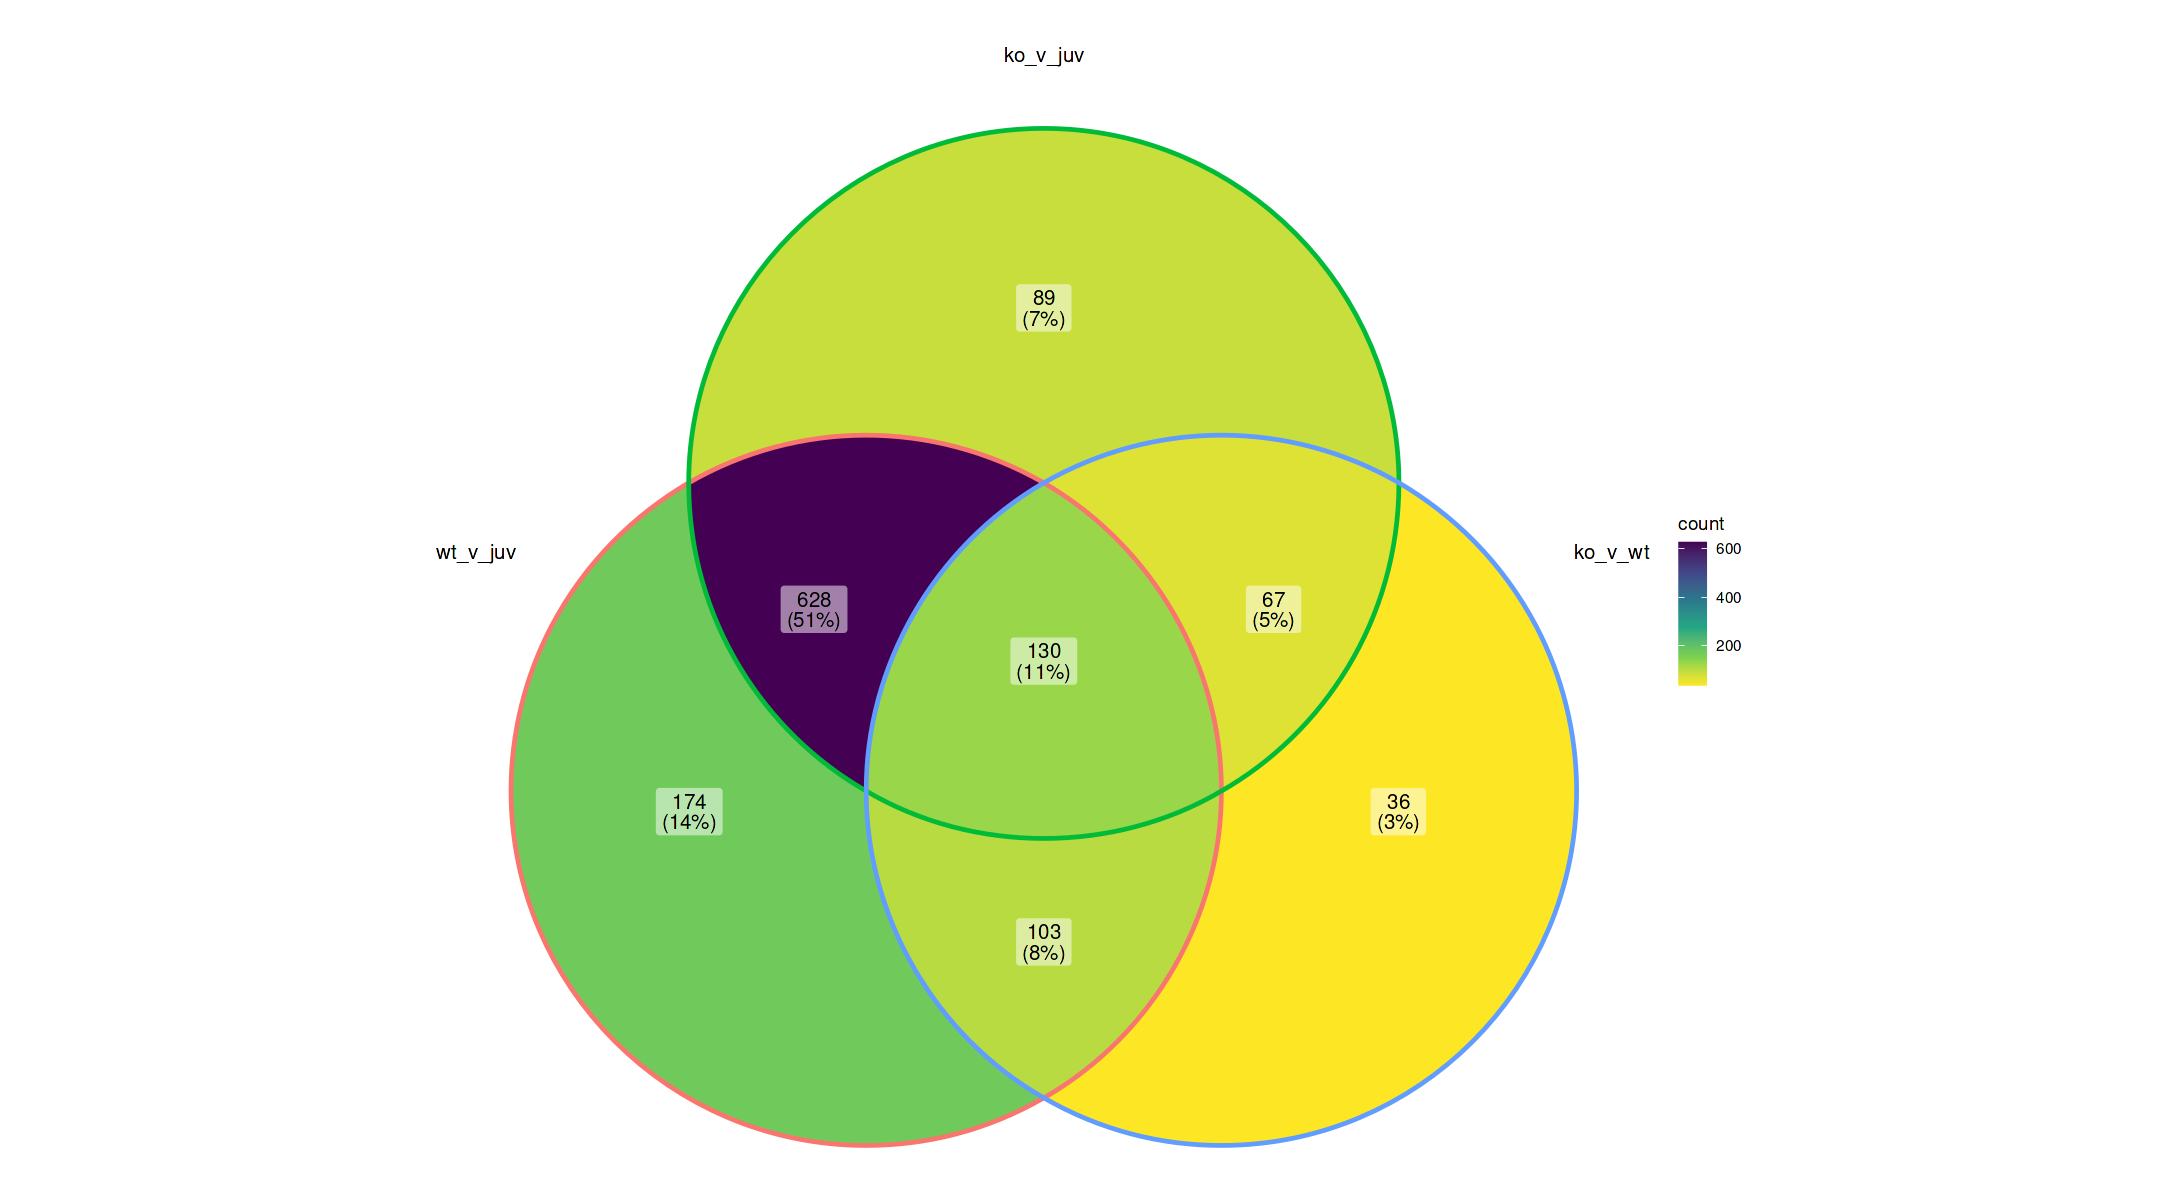

In [26]:
# make bigger graph
options(repr.plot.width=18, repr.plot.height=10)
# make venn diagram between the significant genes in the three comparisons
venn_list <- list(  wt_v_juv=adult_wt_vs_juvenile_wt_all$gene, 
                    ko_v_juv=adult_ko_vs_juvenile_wt_all$gene,
                    ko_v_wt= adult_ko_vs_adult_wt_all$gene
                    )

    plot <- ggVennDiagram(venn_list, 
    label_size = NA, 
    # set_size=8
    ) +
            scale_fill_viridis_c(option = "viridis", direction = -1) +
            theme(plot.title = element_text(hjust = 0.5),
                )
            NULL
            
    plot

In [27]:
# get the genes in the intersection of the three comparisons
ItemsList <- gplots::venn(venn_list, show.plot = FALSE) 

items <- attributes(ItemsList)$intersections # get the items in the intersection
items_df <- tibble::enframe(items)  # convert the items to a dataframe
items_df %>% head 
items_df$value <- gsub("^c\\(\"|\"\\)$", "", items_df$value) # remove the c() and "" from the items
items_df$value <- gsub('["\\)]', '', items_df$value) # remove the " and ) from the items

items_df <- separate_wider_delim(items_df, delim = ",",cols=value, names_sep = "", too_few = "align_start") # separate the items into columns
items_df <- items_df %>% t %>% as.data.frame # transpose the dataframe

colnames(items_df) <- items_df[1,] # set the first row as column names


items_df <- items_df[-1,] # remove the first row
rownames(items_df) <- NULL # remove the row names
items_df <- items_df %>% mutate_all(str_trim) # remove white spaces from all columns
items_df %>% head

name,value
<chr>,<list>
ko_v_juv:ko_v_wt,"abcd2, a...."
wt_v_juv:ko_v_wt,"adgrv1, ...."
wt_v_juv:ko_v_juv,"acaa2, a...."
wt_v_juv:ko_v_juv:ko_v_wt,"aars1, a...."
ko_v_wt,"abcb11a,...."
ko_v_juv,"ache, ac...."


,ko_v_juv:ko_v_wt,wt_v_juv:ko_v_wt,wt_v_juv:ko_v_juv,wt_v_juv:ko_v_juv:ko_v_wt,ko_v_wt,ko_v_juv,wt_v_juv
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,abcd2,adgrv1,acaa2,aars1,abcb11a,ache,aamdc
2,acta1b,aldh9a1a,acads,aclya,actbb,actc1a,abcg2d
3,anxa2a,aldh9a1a.2,acat1,aco2,adh8a,adrm1,acadsb
4,apobec2a,apom,acbd7,adh8b,ahnak,anxa1a,acadvl
5,bcar3,arhgap4a,acot13,aimp1a,aldh4a1,atp1b1a,acp1
6,btr05,atp2a1l,actn2b,aldoaa,ankrd52a,atp5if1a,acsl1b


## GSEA

In [6]:
GSEA_function <- function(df, pval_deg  = 0.05,pval_enrich=0.2, onto= "MF", prefix=""){
    
    gene_list_df <- df[df$adult_ko_vs_adult_wt_P.Value<=pval_deg,]
    gene_list_df <- gene_list_df %>% arrange(desc(adult_ko_vs_adult_wt_logFC))
    gene_list_df <- gene_list_df[!is.na(gene_list_df$gene_mouse),]
    gene_list_df <- gene_list_df[!duplicated(gene_list_df$gene_mouse),]
    gene_list <- gene_list_df %>% pull(adult_ko_vs_adult_wt_logFC)
    names(gene_list) <- gene_list_df %>% pull(gene_mouse)

    gene_list <- gene_list[!duplicated(gene_list)]
    print(head(gene_list)) 



    compGO <- gseGO(gene = gene_list, pvalueCutoff  = pval_enrich,,keyType = "SYMBOL",
                             pAdjustMethod = "BH",OrgDb = "org.Mm.eg.db", ont = onto)
    # print(compGO)
    if(is.null(compGO)|nrow(compGO@result)==0){
    message(paste0("No GSEA:",onto))
    message(paste0("****************************************************************************************"))
    message(paste0("\n"))
   
    }else {

        compGO_df <- as.data.frame(compGO)
          compGO_df <- compGO_df %>% tidyr::separate_rows(core_enrichment, sep = "/", convert = FALSE) %>%  arrange((p.adjust))

            if(nrow(compGO_df)==0){
            message(paste0("No GSEA:",onto))
            message(paste0("****************************************************************************************"))
            message(paste0("\n"))

            } else{

            write.csv(compGO_df, paste0(prefix,"_GSEA_",onto, "_pathways.csv"))


            full_name= switch(onto,
                    MF= "Moleuclar Function",
                    CC= "Cellular Components",
                    BP= "Biological Processes"
                             )                                           
            print(paste(full_name, onto))
            print(dotplot(compGO, showCategory = 15, title = paste0("DEG GO Pathway Enrichment Analysis \n",full_name ), 
                    font.size = 12) + facet_grid(.~.sign))
            dev.copy(
            pdf,
            file = paste0(prefix,"_GSEA_",onto, "_pathways.pdf"),
            width = 10,
            height = 8
            )
            dev.off ()




        message(paste0("DEG Pathway analysis GO:",onto, " done"))
        message(paste0("****************************************************************************************"))
        message(paste0("\n"))

        }
    }
}



In [ ]:
getwd()

[1] "/mnt/Data_8TB/Carolina_data/Cell_paper"

  Col1a1  Arhgap4   Col6a3   Adgrv1    Decr1     Dnm2 
4.609072 4.524977 4.040525 3.784338 3.735197 3.418267 


preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...



[1] "Moleuclar Function MF"


DEG Pathway analysis GO:MF done

****************************************************************************************






  Col1a1  Arhgap4   Col6a3   Adgrv1    Decr1     Dnm2 
4.609072 4.524977 4.040525 3.784338 3.735197 3.418267 


preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...



[1] "Cellular Components CC"


DEG Pathway analysis GO:CC done

****************************************************************************************






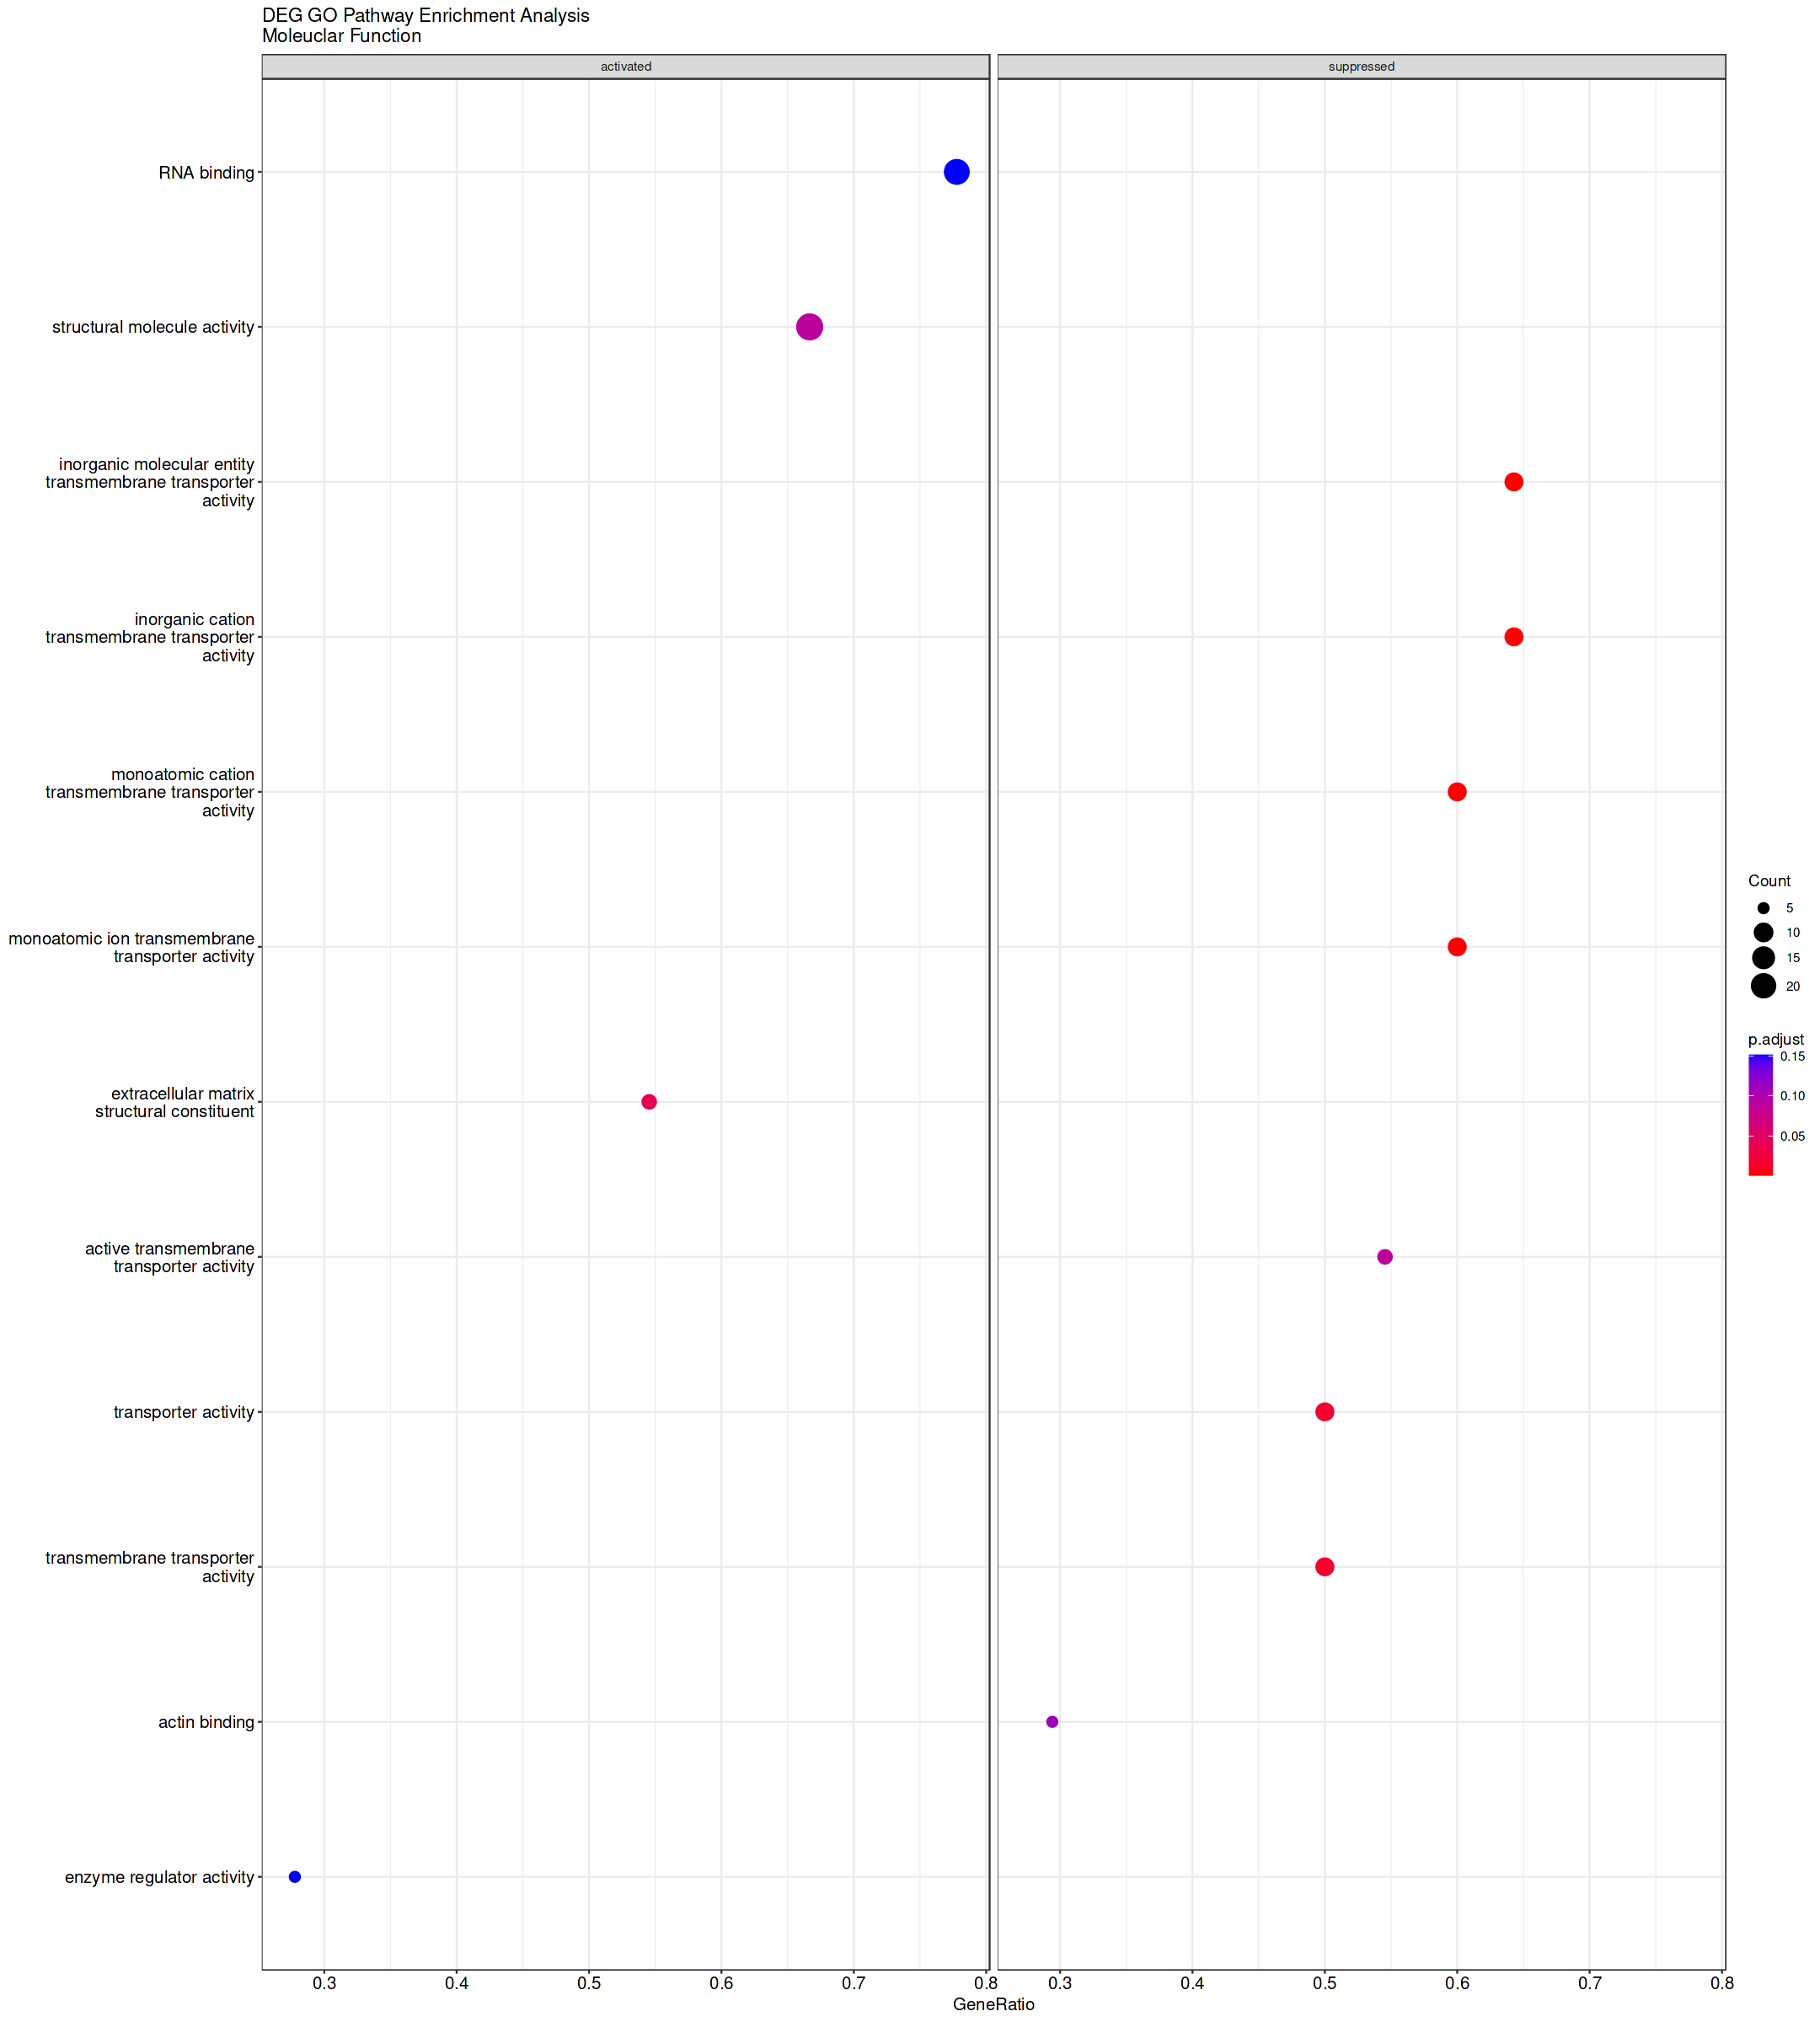

  Col1a1  Arhgap4   Col6a3   Adgrv1    Decr1     Dnm2 
4.609072 4.524977 4.040525 3.784338 3.735197 3.418267 


preparing geneSet collections...

GSEA analysis...

no term enriched under specific pvalueCutoff...

No GSEA:BP

****************************************************************************************






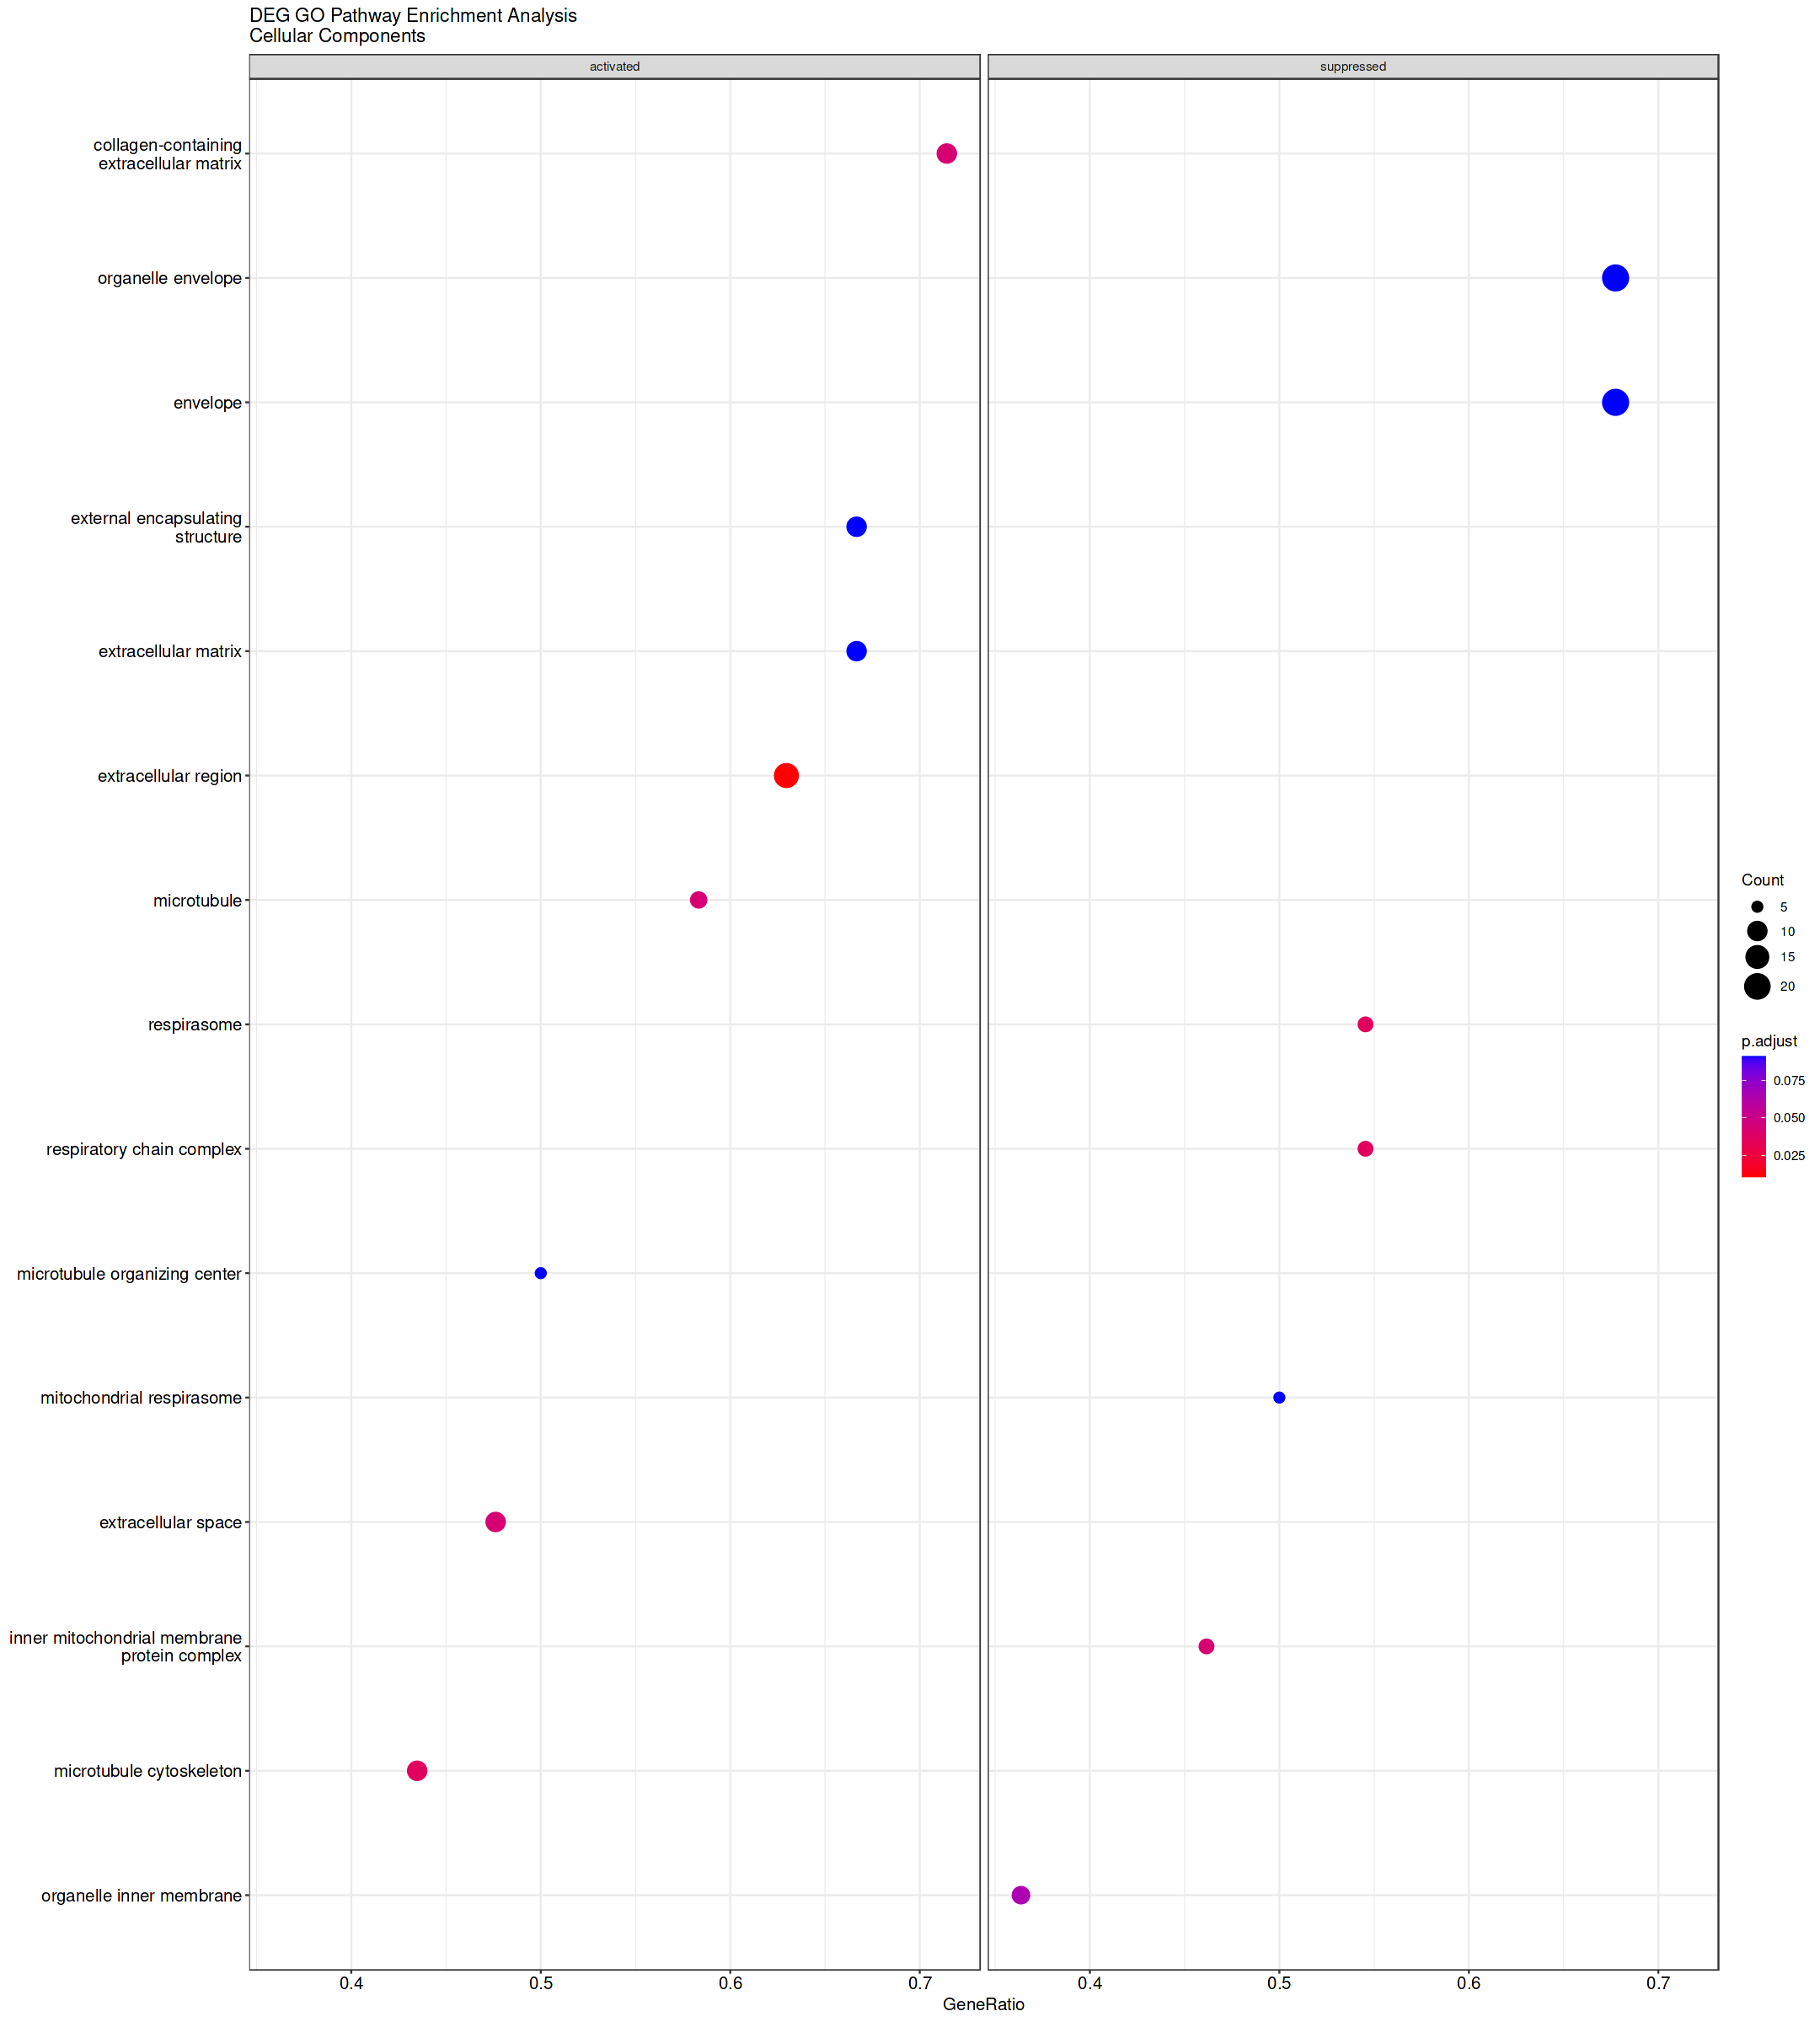

In [ ]:


dir.create("proteomics_n_3_muscle/GSEA_subcluster", showWarnings = FALSE)
dir.create("proteomics_n_3_muscle/GSEA_subcluster/Molecular_function", showWarnings = FALSE, recursive = TRUE)
dir.create("proteomics_n_3_muscle/GSEA_subcluster/Cellular_component", showWarnings = FALSE, recursive = TRUE)
dir.create("proteomics_n_3_muscle/GSEA_subcluster/Biological_processes", showWarnings = FALSE, recursive = TRUE)

GSEA_function(df = description_df_mouse_zf, onto = "MF", prefix="proteomics_n_3_muscle/GSEA_subcluster/Molecular_function/muscle_n_3_GSEA")
GSEA_function(df = description_df_mouse_zf, onto = "CC", prefix="proteomics_n_3_muscle/GSEA_subcluster/Cellular_component/muscle_n_3_GSEA")
GSEA_function(df = description_df_mouse_zf, onto = "BP", prefix="proteomics_n_3_muscle/GSEA_subcluster/Biological_processes/muscle_n_3_GSEA")

In [ ]:
mitocarta_mouse_pathways <- readxl::read_excel("Mouse.MitoCarta3.0.xls", sheet = 4)

mitocarta_mouse_pathways <- mitocarta_mouse_pathways %>% dplyr::select(MitoPathway, Genes)
# mitocarta_mouse_pathways %>% head
mitocarta_mouse_pathways_rows_list <- mitocarta_mouse_pathways %>% tidyr::separate_rows(Genes, sep = ",", convert = FALSE) %>%  arrange(MitoPathway) %>% dplyr::rename(term= MitoPathway,  gene= Genes)
# mitocarta_mouse_pathways_rows_list <- mitocarta_mouse_pathways_rows_list
# remove trailing and leading spaces
mitocarta_mouse_pathways_rows_list$gene <- gsub("^\\s+|\\s+$", "", mitocarta_mouse_pathways_rows_list$gene)
mitocarta_mouse_pathways_rows_list %>% head

term,gene
<chr>,<chr>
ABC transporters,Abca9
ABC transporters,Abcb10
ABC transporters,Abcb6
ABC transporters,Abcb7
ABC transporters,Abcb8
ABC transporters,Abcd1


In [ ]:
mitocarta_pathways <- read.delim("./MitoPathways3.0.gmx", sep = "\t", header = TRUE)
mitocarta_pathways %>% head
mitocarta_pathways %>% dim

,Mitochondrial_central_dogma,mtDNA_maintenance,mtDNA_replication,mtDNA_nucleoid,mtDNA_repair,mtDNA_modifications,mtDNA_stability_and_decay,mtRNA_metabolism,Transcription,mtRNA_granules,⋯,Fusion,Fission,Organelle_contact_sites,Intramitochondrial_membrane_interactions,Trafficking,Mitophagy,Autophagy,Apoptosis,Cristae_formation,MICOS_complex
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Mitochondrial_central_dogma,Mitochondrial_central_dogma.mtDNA_maintenance,Mitochondrial_central_dogma.mtDNA_maintenance.mtDNA_replication,Mitochondrial_central_dogma.mtDNA_maintenance.mtDNA_nucleoid,Mitochondrial_central_dogma.mtDNA_maintenance.mtDNA_repair,Mitochondrial_central_dogma.mtDNA_maintenance.mtDNA_modifications,Mitochondrial_central_dogma.mtDNA_maintenance.mtDNA_stability_and_decay,Mitochondrial_central_dogma.mtRNA_metabolism,Mitochondrial_central_dogma.mtRNA_metabolism.Transcription,Mitochondrial_central_dogma.mtRNA_metabolism.mtRNA_granules,⋯,Mitochondrial_dynamics_and_surveillance.Fusion,Mitochondrial_dynamics_and_surveillance.Fission,Mitochondrial_dynamics_and_surveillance.Organelle_contact_sites,Mitochondrial_dynamics_and_surveillance.Intramitochondrial_membrane_interactions,Mitochondrial_dynamics_and_surveillance.Trafficking,Mitochondrial_dynamics_and_surveillance.Mitophagy,Mitochondrial_dynamics_and_surveillance.Autophagy,Mitochondrial_dynamics_and_surveillance.Apoptosis,Mitochondrial_dynamics_and_surveillance.Cristae_formation,Mitochondrial_dynamics_and_surveillance.Cristae_formation.MICOS_complex
2,AARS2,APEX1,DNA2,ATAD3A,APEX1,METTL4,ENDOG,ALKBH1,MRPL12,ALKBH1,⋯,ARL2,ARMC10,AHCYL1,ATAD3A,ARMC10,BCL2L13,BCL2L13,AIFM1,APOO,APOO
3,ALKBH1,ATAD3A,EXOG,ATAD3B,EXOG,,EXOG,ANGEL2,MTERF1,DDX28,⋯,MFN1,DNM1L,ATAD3A,ATAD3B,ARMCX1,FKBP8,FKBP8,AIFM2,APOOL,APOOL
4,ANGEL2,ATAD3B,LIG3,MTERF1,LIG3,,MGME1,CDK5RAP1,MTRES1,DHX30,⋯,MFN2,FIS1,ATAD3B,CHCHD3,ARMCX3,FUNDC1,FUNDC1,AIFM3,ATP5MD,CHCHD3
5,APEX1,DNA2,MGME1,MTERF2,OGG1,,,DDX28,POLRMT,ERAL1,⋯,MIGA1,MFF,FKBP8,DNAJC11,MGARP,MARCHF5,MARCHF5,BAD,ATP5ME,CHCHD6
6,ATAD3A,ENDOG,POLG,POLDIP2,POLB,,,DHX30,TEFM,FASTK,⋯,MIGA2,MIEF1,FUNDC2,MTX1,MYO19,NIPSNAP1,NBR1,BAK1,ATP5MG,IMMT


[1] 462 149

In [ ]:
gene_list_df <- description_df_mouse_zf[description_df_mouse_zf$adult_ko_vs_adult_wt_P.Value<=0.05,]
    gene_list_df <- gene_list_df %>% arrange(desc(adult_ko_vs_adult_wt_logFC))
    gene_list_df <- gene_list_df[!is.na(gene_list_df$gene_mouse),]
    gene_list_df <- gene_list_df[!duplicated(gene_list_df$gene_mouse),]
    gene_list <- gene_list_df %>% pull(adult_ko_vs_adult_wt_logFC)
    names(gene_list) <- gene_list_df %>% pull(gene_mouse)

    gene_list <- gene_list[!duplicated(gene_list)]
    print(head(gene_list)) 


  Col1a1  Arhgap4   Col6a3   Adgrv1    Decr1     Dnm2 
4.609072 4.524977 4.040525 3.784338 3.735197 3.418267 


In [ ]:
gene_list %>% length
names(gene_list)

[1] 224

[1] "Col1a1"        "Arhgap4"       "Col6a3"        "Adgrv1"       
  [5] "Decr1"         "Dnm2"          "Hbb-y"         "Slc5a12"      
  [9] "Ltf"           "Phldb1"        "Hbb-bh1"       "Ndc80"        
 [13] "Col1a2"        "Klhl4"         "Rcor2"         "Dynll1"       
 [17] "4930415L06Rik" "Postn"         "Orm1"          "Cct2"         
 [21] "Mdh1"          "Snd1"          "Rps28"         "Larp1b"       
 [25] "Abcd2"         "Hspb1"         "Rps17"         "Cct3"         
 [29] "Aco2"          "Rps10"         "Fga"           "Ppia"         
 [33] "Opa1"          "Cltc"          "Traf1"         "Hsp90b1"      
 [37] "Mpz"           "G6pc3"         "Fgg"           "Ndufb7"       
 [41] "Tktl2"         "Serpinb8"      "Ssr3"          "Synpo2"       
 [45] "Mtx2"          "Cd99l2"        "Endou"         "Ube2k"        
 [49] "Klhl41"        "Rps14"         "Tmf1"          "Cox7a2"       
 [53] "Fxr1"          "Gm5096"        "Tmem232"       "Acly"         
 [57] "Serbp1"        "Hsp90ab1"      "Anxa5"         "Eif3j1"       
 [61] "Rrbp1"         "Hnrnpab"       "Ppp5c"         "Adh7"         
 [65] "Lamb2"         "Col12a1"       "Jup"           "Myoz3"        
 [69] "Ndufa8"        "Oxct2b"        "Rps26"         "Mybpc2"       
 [73] "Anxa2"         "Rps5"          "Gm5244"        "Rpl23"        
 [77] "Wfs1"          "Glud1"         "Myh9"          "Camk2b"       
 [81] "Aars"          "Pabpc4"        "Ilk"           "Chrna1"       
 [85] "Tln2"          "Col11a1"       "Ndufa3"        "Tcap"         
 [89] "Rpl12"         "Ddx39a"        "Dhtkd1"        "Ptges3"       
 [93] "Edf1"          "Psmb6"         "Acta1"         "Aimp1"        
 [97] "Pdlim5"        "Prkcsh"        "Cap2"          "Rbm31y"       
[101] "Prodh"         "Aldh4a1"       "Col4a2"        "Pank4"        
[105] "Cct7"          "Klhl31"        "Rpl27"         "Col6a2"       
[109] "Rps18-ps6"     "Mrpl12"        "Apoo"          "Pdk1"         
[113] "Ywhah"         "Ccdc88c"       "Vapb"          "Psmd2"        
[117] "Mlh3"          "Psmd4"         "Tnnt1"         "Myl9"         
[121] "Pklr"          "Eci3"          "Des"           "Recql"        
[125] "Eno3"          "Zdhhc5"        "Trdn"          "Pfkp"         
[129] "Bin1"          "Eif5a2"        "Ndufc2"        "Aldoart2"     
[133] "Txndc17"       "Eml3"          "Edrf1"         "Rpn2"         
[137] "Tpi1"          "Atp1a4"        "Got1"          "Spata7"       
[141] "Tmem38a"       "Pgk1"          "Slc25a20"      "Kif13b"       
[145] "G3bp1"         "Fibp"          "Dnah3"         "Chchd10"      
[149] "Pkm"           "Pebp1"         "Chchd2"        "Krt19"        
[153] "Rps6ka1"       "Rtn4"          "Ank2"          "Tpm1"         
[157] "Etfdh"         "Rab7"          "Myl2"          "Prdx3"        
[161] "Pfkm"          "Slc25a4"       "Smyd1"         "Top2a"        
[165] "Cfap58"        "Pygm"          "Rpl34"         "Slk"          
[169] "Gpd1"          "Gpd1l"         "Dvl3"          "Sorbs1"       
[173] "Shprh"         "Shank2"        "Ankrd10"       "Chd9"         
[177] "Ldha"          "Slc6a21"       "Ccn5"          "Mns1"         
[181] "Nav1"          "Gpi1"          "Golga4"        "Ankrd52"      
[185] "Flnc"          "Hibadh"        "Prmt2"         "Igdcc3"       
[189] "mt-Co2"        "Ptprb"         "Uqcrh"         "Pygb"         
[193] "Apobec2"       "Myl10"         "Scn10a"        "Cops4"        
[197] "Ddx59"         "Sh3gl1"        "Gm10358"       "Hdac7"        
[201] "Glo1"          "Cox7c"         "Sin3b"         "Pcdhac2"      
[205] "P2rx4"         "Ikzf5"         "Bcar3"         "Sbf2"         
[209] "Slc6a2"        "Cox6b2"        "Cox4i2"        "Atp5d"        
[213] "Twf1"          "Bloc1s6"       "H6pd"          "Tpm2"         
[217] "Epc1"          "Micall2"       "Mybph"         "Cox5b-ps"     
[221] "Ugt8a"         "Pvalb"         "Cox5a"         "Cox4i1"

In [ ]:
names(gene_list)[grepl("Cox7", names(gene_list))]
(mitocarta_mouse_pathways_rows_list$gene)[grepl("Cox7", (mitocarta_mouse_pathways_rows_list$gene))]

[1] "Cox7a2" "Cox7c"

[1] "Cox7a1"  "Cox7a2"  "Cox7a2l" "Cox7b"   "Cox7c"   "Cox7a1"  "Cox7a2" 
 [8] "Cox7a2l" "Cox7b"   "Cox7c"   "Cox7a1"  "Cox7a2"  "Cox7a2l" "Cox7b"  
[15] "Cox7c"   "Cox7a2l" "Cox7a1"  "Cox7a2"  "Cox7a2l" "Cox7b"   "Cox7c"  
[22] "Cox7a2l"

In [ ]:
names(gene_list)[names(gene_list) %in% mitocarta_mouse_pathways_rows_list$gene]

[1] "Decr1"    "Abcd2"    "Aco2"     "Opa1"     "Ndufb7"   "Mtx2"    
 [7] "Cox7a2"   "Acly"     "Ndufa8"   "Glud1"    "Ndufa3"   "Dhtkd1"  
[13] "Prodh"    "Aldh4a1"  "Mrpl12"   "Apoo"     "Pdk1"     "Ndufc2"  
[19] "Slc25a20" "Chchd2"   "Etfdh"    "Prdx3"    "Slc25a4"  "Hibadh"  
[25] "mt-Co2"   "Uqcrh"    "Cox7c"    "Cox6b2"   "Cox4i2"   "Atp5d"   
[31] "Cox5a"    "Cox4i1"

In [ ]:
intersect(names(gene_list), mitocarta_mouse_pathways_rows_list$gene)

[1] "Decr1"    "Abcd2"    "Aco2"     "Opa1"     "Ndufb7"   "Mtx2"    
 [7] "Cox7a2"   "Acly"     "Ndufa8"   "Glud1"    "Ndufa3"   "Dhtkd1"  
[13] "Prodh"    "Aldh4a1"  "Mrpl12"   "Apoo"     "Pdk1"     "Ndufc2"  
[19] "Slc25a20" "Chchd2"   "Etfdh"    "Prdx3"    "Slc25a4"  "Hibadh"  
[25] "mt-Co2"   "Uqcrh"    "Cox7c"    "Cox6b2"   "Cox4i2"   "Atp5d"   
[31] "Cox5a"    "Cox4i1"

In [8]:
library(viridis)

Loading required package: viridisLite



preparing geneSet collections...

GSEA analysis...



leading edge analysis...

done...

Scale for size is already present.
Adding another scale for size, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


pdf 
  3

png 
  2

,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
OXPHOS,OXPHOS,OXPHOS,13,-0.6880534,-2.210767,0.0002748124,0.0004122186,0.0001446381,37,"tags=62%, list=17%, signal=55%",mt-Co2/Uqcrh/Cox7c/Cox6b2/Cox4i2/Atp5d/Cox5a/Cox4i1
OXPHOS subunits,OXPHOS subunits,OXPHOS subunits,13,-0.6880534,-2.210767,0.0002748124,0.0004122186,0.0001446381,37,"tags=62%, list=17%, signal=55%",mt-Co2/Uqcrh/Cox7c/Cox6b2/Cox4i2/Atp5d/Cox5a/Cox4i1


****************************************************************************************






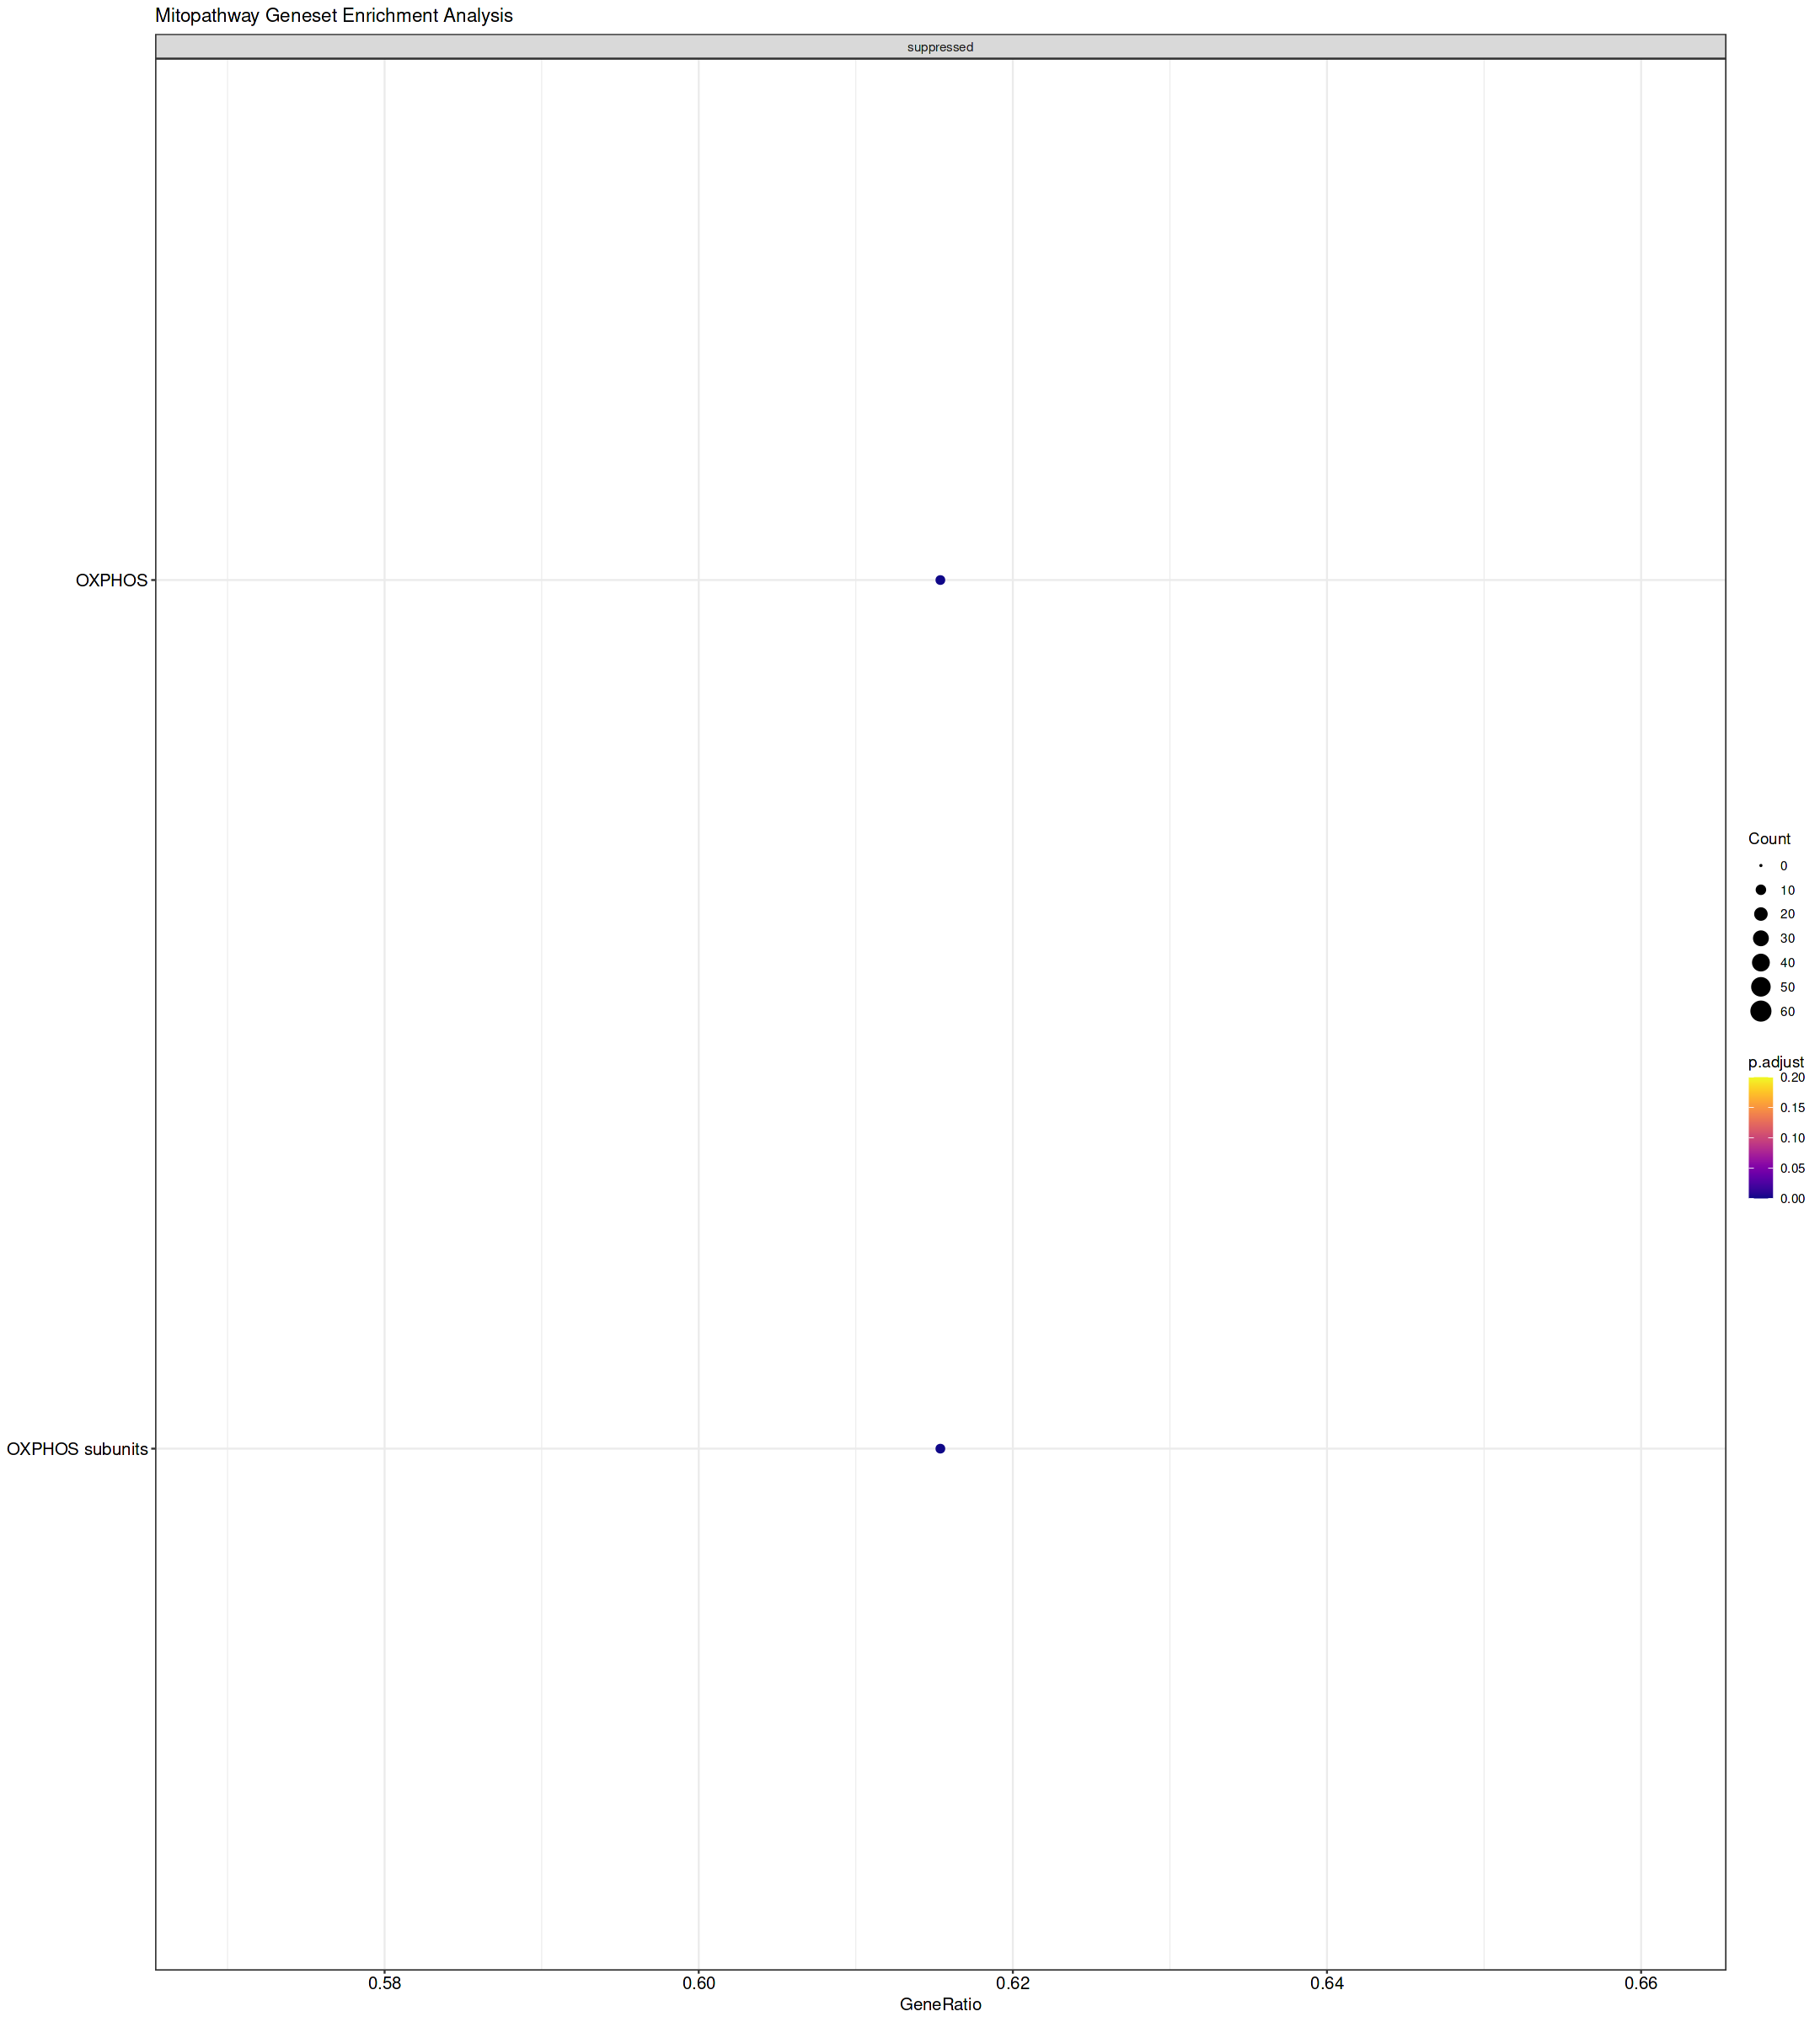

In [ ]:
gsea_mito <- GSEA(gene_list, TERM2GENE = mitocarta_mouse_pathways_rows_list, pvalueCutoff = 0.05)
 dotplot(gsea_mito, showCategory = 15, title = paste0("Mitopathway Geneset Enrichment Analysis"), 
            font.size = 12) + facet_grid(.~.sign)+ scale_size_area(limits = c(0,60))+
            scale_colour_viridis(option = "plasma", direction = 1,limits=c(0,0.2))+
            NULL
    # Save dotplot as pdf file
    dev.copy(
    pdf,
    file = paste0("proteomics_n_3_muscle/GSEA_subcluster/Mitopathway_GSEA.pdf"),
    width = 22,
    height = 8
    )
    dev.off ()

    gsea_mito_df <- as.data.frame(gsea_mito)
        gsea_mito_df

    gsea_mito_df <- gsea_mito_df %>% tidyr::separate_rows(core_enrichment, sep = "/", convert = FALSE) %>%
      arrange((p.adjust))
    
    # Save enriched pathways data frame as CSV file
    write.csv(gsea_mito_df, paste0("proteomics_n_3_muscle/GSEA_subcluster/Mitopathway_GSEA.csv"))
    
    # Print message indicating that analysis for the current cell type is complete
#     message(paste0("Cell type: ", i, " done"))
    message(paste0("****************************************************************************************"))
    message(paste0("\n"))                              

# PCA

In [3]:
# Function to plot PCA
PCA <- function(mat,color_pca="",shape_pca= "", label_pca= "",save_plot= "no", name_of_plot= "PCA", comp1=1, comp2=2, height=10, width=10){
  # mat: matrix of counts
  # color_pca: vector of colors for each sample
  # shape_pca: vector of shapes for each sample
  # label_pca: vector of labels for each sample
  # save_plot: yes or no
  # name_of_plot: name of the plot
  # comp1: component 1
  # comp2: component 2
  # height: height of the plot
  # width: width of the plot
  
  
  #1. Extract the counts.
  dt <- mat
  
  #2. Perform pca
  pca_dt <- prcomp(t(dt))
  cat("PCA running...\n")

  
  #3. Extract percentVar data.
  percentVar_dt <- pca_dt$sdev^2/sum(pca_dt$sdev^2)
  cat("Percents calculated...\n")

  
  #4. Create the new dataframe to plot.
  dt_f <- data.frame(PC1=pca_dt$x[,comp1],
                     PC2=pca_dt$x[,comp2],
                     color_pca=color_pca,
                     shape_pca=shape_pca,
                     label_pca= label_pca)
  cat("Data frame built...\n")

  
  #5. Plot it 
  cat("Plotting...\n")

  print(save_plot)
  require(ggplot2)
  require(ggrepel)
  if (save_plot== "no") {
    pca_p <- ggplot(data = dt_f, aes_string(x = paste0("PC1"),
                                          y = paste0("PC2"),
                                          color = "color_pca", 
                                          shape= "shape_pca", label="label_pca")) +
            geom_point(size = 3) +
            geom_text_repel(size= 3, max.overlaps = 50, 
                            box.padding   = 1.5,point.padding = 0.5,force = 50)+
            xlab(paste0("PC", comp1,": ", 
                        round(percentVar_dt[comp1] * 100), "% variance")) +
            ylab(paste0("PC",comp2,": ",
                        round(percentVar_dt[comp2] * 100), "% variance")) +

            theme_classic()
      NULL
  }
  if (save_plot== "yes"){
  dev.copy(pdf,paste0(name_of_plot,".pdf"),width = width,height = height)
  cat("Saving plot as: ",paste0(name_of_plot,"...\n"))
  pca_p <- ggplot(data = dt_f, aes_string(x = paste0("PC",comp1),
                                          y = paste0("PC",comp2),
                                          color = "color_pca", 
                                          shape= "shape_pca", 
                                          label="label_pca"
                                          )) +
            geom_text_repel(size= 3, max.overlaps = 50, 
                            box.padding   = 1.5,
                            point.padding = 0.5,force = 50)+
            geom_point(size = 3) +
            xlab(paste0("PC", comp1,": ", round(percentVar_dt[comp1] * 100), "% variance")) +
            ylab(paste0("PC",comp2,": ", round(percentVar_dt[comp2] * 100), "% variance")) +
            theme_classic()
    NULL
  print(pca_p)
  dev.off()
   }

  cat("Done")
  print(pca_p)

  #return(pca_p)
}

In [51]:
# prepare the data for PCA
pca_matrix <- data_merged %>% dplyr::select(c('AKO1', 'AKO2', 'AKO3', 'AWT1', 'AWT2', 'AWT3', 'JWT1', 'JWT2', 'JWT3', "gene")) # select only the counts columns
rownames(pca_matrix) <- make.unique(pca_matrix$gene) # set the gene names as row names
pca_matrix <- pca_matrix %>% dplyr::select(-gene) # remove the gene column
# make all columns numeric 
pca_matrix <- pca_matrix %>% mutate_all(as.numeric) # make all columns numeric
pca_matrix <- as.matrix(pca_matrix) # convert to matrix
pca_matrix %>% head

,AKO1,AKO2,AKO3,AWT1,AWT2,AWT3,JWT1,JWT2,JWT3
aamdc,1.4667515,-0.5739485,-1.8653050,0.26725443,-0.23076900,0.9212840,-1.5362111,-1.1748141,-2.3603862
aars1,-1.3534255,-1.5746633,-1.7947352,-2.83197660,-2.54200323,-2.6800583,3.3682986,3.3847378,3.1163859
aass,0.7297959,1.3124487,0.2894110,0.53375739,0.05744185,-0.9853736,-0.5110688,-1.3092887,1.2052643
abcb10,0.2852603,1.2430460,0.6226768,0.21875262,0.09663467,0.7806194,1.5690452,1.3093782,0.8292716
abcb11a,0.6139335,2.1746058,1.2280779,0.54923656,-5.56276938,-2.2331746,-0.3427620,-0.1275152,-0.1900068
abcb11b,0.3971808,-0.2657106,-0.6573271,-0.01452689,0.54376251,-0.5148912,1.2912932,-0.1631527,0.9774665


In [52]:
# prepare the metadata for PCA
metadata <- data.frame(samples = colnames(pca_matrix), 
                        condition= NA) # create a dataframe with samples and condition columns
# Where samples is AKO1/AKO2/AKO3 condition with Cox7a1
metadata$condition[metadata$samples %in% c("AKO1", "AKO2", "AKO3")] <- "Cox7a1"
# Where samples is AWT1/AWT2/AWT3 condition with WT
metadata$condition[metadata$samples %in% c("AWT1", "AWT2", "AWT3")] <- "WT"
# Where samples is JWT1/JWT2/JWT3 condition with Juvenile
metadata$condition[metadata$samples %in% c("JWT1", "JWT2", "JWT3")] <- "Juvenile"

metadata$condition <- factor(metadata$condition, levels = c( "Cox7a1", "WT", "Juvenile")) # set the levels of the condition column

metadata

samples,condition
<chr>,<fct>
AKO1,Cox7a1
AKO2,Cox7a1
AKO3,Cox7a1
AWT1,WT
AWT2,WT
AWT3,WT
JWT1,Juvenile
JWT2,Juvenile
JWT3,Juvenile


Warning message in dir.create("./proteomics_n_3_muscle/figures", recursive = TRUE):
“'./proteomics_n_3_muscle/figures' already exists”


PCA running...
Percents calculated...
Data frame built...
Plotting...
[1] "yes"


Loading required package: ggplot2

Loading required package: ggrepel



Saving plot as:  ./proteomics_n_3_muscle/figures/PCA_proteomics_n_3_muscle_nolabels...


Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


Done

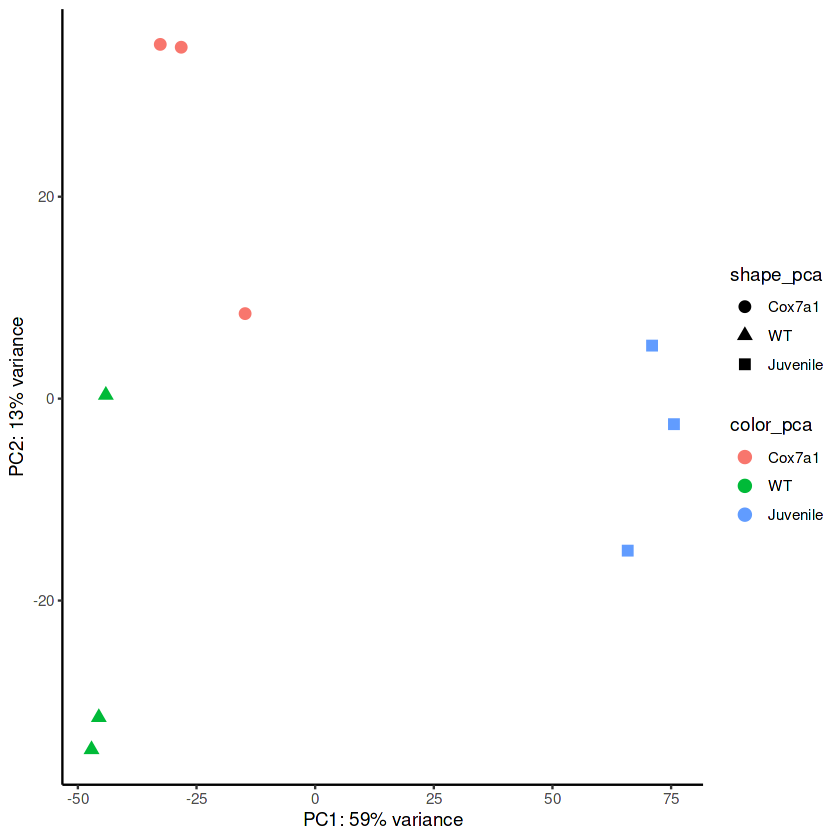

In [4]:
dir.create("./proteomics_n_3_muscle/figures", recursive = TRUE) # create a directory to save the plots
PCA(pca_matrix, color_pca = metadata$condition, 
shape_pca = metadata$condition,
 save_plot = "yes", name_of_plot = "./proteomics_n_3_muscle/figures/PCA_proteomics_n_3_muscle_nolabels", height = 6, width = 8) # perform PCA and save the plot

# Add more annotations and manual curation

In [251]:
# in the column gene remove all the numbers after the dot and the dot
df_merged_description$gene <- gsub("\\..*", "", df_merged_description$gene)

In [646]:
description_df_mouse_zf <- merge(df_merged_description,description_df_mouse[,c("gene",  # merge the description dataframe with the merged dataframe
colnames(description_df_mouse)[!(colnames(description_df_mouse) %in% colnames(df_merged_description))])] , by="gene", all.x = TRUE)
description_df_mouse_zf <-  description_df_mouse_zf %>% dplyr::rename(
            gene_full_name_zf = gene_full_name,
            GO_description_zf = GO_description,
            associated_phenotype_zf = associated_phenotype,
            GO_name_zf = GO_name,
            GO_family_zf = GO_family,

)
description_df_mouse_zf  %>% colnames()


[1] "gene"                              "protein"                          
 [3] "AKO1"                              "AKO2"                             
 [5] "AKO3"                              "AWT1"                             
 [7] "AWT2"                              "AWT3"                             
 [9] "JWT1"                              "JWT2"                             
[11] "JWT3"                              "NOP"                              
[13] "adult_ko_vs_adult_wt_logFC"        "adult_ko_vs_adult_wt_P.Value"     
[15] "adult_ko_vs_adult_wt_adj.P.Val"    "adult_ko_vs_juvenile_wt_logFC"    
[17] "adult_ko_vs_juvenile_wt_P.Value"   "adult_ko_vs_juvenile_wt_adj.P.Val"
[19] "adult_wt_vs_juvenile_wt_logFC"     "adult_wt_vs_juvenile_wt_P.Value"  
[21] "adult_wt_vs_juvenile_wt_adj.P.Val" "gene_full_name_zf"                
[23] "GO_description_zf"                 "associated_phenotype_zf"          
[25] "GO_name_zf"                        "GO_family_zf"                     
[27] "gene_mouse"                        "gene_full_name_mouse"             
[29] "GO_description_mouse"              "associated_phenotype_mouse"       
[31] "GO_name_mouse"                     "GO_family_mouse"

In [647]:
# Import the mouse mitocarta genes
mito_genes <-readxl::read_excel("Mouse.MitoCarta3.0.xls", sheet = 2)
# head(mito_genes)
mito_genes <- mito_genes %>% dplyr::select('Symbol',"Description", 'MitoCarta3.0_SubMitoLocalization','MitoCarta3.0_MitoPathways')
colnames(mito_genes)
mito_genes %>% dim
head(mito_genes)

[1] "Symbol"                           "Description"                     
[3] "MitoCarta3.0_SubMitoLocalization" "MitoCarta3.0_MitoPathways"

[1] 1140    4

Symbol,Description,MitoCarta3.0_SubMitoLocalization,MitoCarta3.0_MitoPathways
<chr>,<chr>,<chr>,<chr>
Cyc1,cytochrome c-1,MIM,OXPHOS > Complex III > CIII subunits | Metabolism > Metals and cofactors > Heme-containing proteins | Metabolism > Electron carriers > Cytochromes | OXPHOS > OXPHOS subunits
Pdha1,pyruvate dehydrogenase E1 alpha 1,Matrix,Metabolism > Carbohydrate metabolism > Pyruvate metabolism
Atp5d,"ATP synthase, H+ transporting, mitochondrial F1 complex, delta subunit",MIM,OXPHOS > Complex V > CV subunits | OXPHOS > OXPHOS subunits
Isca2,iron-sulfur cluster assembly 2,Matrix,Metabolism > Metals and cofactors > Fe-S cluster biosynthesis | Metabolism > Metals and cofactors > Fe-S-containing proteins
Pdhb,pyruvate dehydrogenase (lipoamide) beta,Matrix,Metabolism > Carbohydrate metabolism > Pyruvate metabolism
Uqcrc1,ubiquinol-cytochrome c reductase core protein 1,MIM,"Protein import, sorting and homeostasis > Protein import and sorting > Preprotein cleavage | OXPHOS > Complex III > CIII subunits | OXPHOS > OXPHOS subunits"


In [648]:
# merge the mito genes with the description dataframe
description_df_mouse_zf <- merge(description_df_mouse_zf,mito_genes, by.x="gene_mouse", by.y="Symbol", all.x = TRUE)
description_df_mouse_zf %>% dim
colnames(description_df_mouse_zf)

[1] 2511   35

[1] "gene_mouse"                        "gene"                             
 [3] "protein"                           "AKO1"                             
 [5] "AKO2"                              "AKO3"                             
 [7] "AWT1"                              "AWT2"                             
 [9] "AWT3"                              "JWT1"                             
[11] "JWT2"                              "JWT3"                             
[13] "NOP"                               "adult_ko_vs_adult_wt_logFC"       
[15] "adult_ko_vs_adult_wt_P.Value"      "adult_ko_vs_adult_wt_adj.P.Val"   
[17] "adult_ko_vs_juvenile_wt_logFC"     "adult_ko_vs_juvenile_wt_P.Value"  
[19] "adult_ko_vs_juvenile_wt_adj.P.Val" "adult_wt_vs_juvenile_wt_logFC"    
[21] "adult_wt_vs_juvenile_wt_P.Value"   "adult_wt_vs_juvenile_wt_adj.P.Val"
[23] "gene_full_name_zf"                 "GO_description_zf"                
[25] "associated_phenotype_zf"           "GO_name_zf"                       
[27] "GO_family_zf"                      "gene_full_name_mouse"             
[29] "GO_description_mouse"              "associated_phenotype_mouse"       
[31] "GO_name_mouse"                     "GO_family_mouse"                  
[33] "Description"                       "MitoCarta3.0_SubMitoLocalization" 
[35] "MitoCarta3.0_MitoPathways"

In [649]:
nadia_annotations_manual <- readxl::read_excel("new proteomics muslce and heart_NM.xlsx", sheet = 1) # read the manual annotations
colnames(nadia_annotations_manual)[22] <-  'confirmation_status_muscle'
colnames(nadia_annotations_manual)[23] <-  'info_genecards_uniprot_nadia'
colnames(nadia_annotations_manual)
nadia_annotations_manual <- nadia_annotations_manual %>% dplyr::select(gene,confirmation_status_muscle, info_genecards_uniprot_nadia)
nadia_annotations_manual$gene <- gsub("\\..*", "", nadia_annotations_manual$gene)
nadia_annotations_manual_2 <- readxl::read_excel("new proteomics muslce and heart_NM.xlsx", sheet = 4)
colnames(nadia_annotations_manual_2)[colnames(nadia_annotations_manual_2)=="COMPARISON"] <- 'confirmation_status_ventricle'
colnames(nadia_annotations_manual_2)[colnames(nadia_annotations_manual_2)=="info gene cards:uniprot"] <- 'info_genecards_uniprot_nadia'
colnames(nadia_annotations_manual_2)
nadia_annotations_manual_2 <- nadia_annotations_manual_2 %>% dplyr::select(gene,confirmation_status_ventricle, info_genecards_uniprot_nadia)
nadia_annotations_manual_2$gene <- gsub("\\..*", "", nadia_annotations_manual_2$gene)
nadia_annotations_manual <- merge(nadia_annotations_manual,nadia_annotations_manual_2, by="gene", all.x = TRUE)
nadia_annotations_manual$confirmation_status_muscle[is.na(nadia_annotations_manual$confirmation_status_muscle)] <- ""
nadia_annotations_manual$confirmation_status_ventricle[is.na(nadia_annotations_manual$confirmation_status_ventricle)] <- ""
nadia_annotations_manual$info_genecards_uniprot_nadia.x[is.na(nadia_annotations_manual$info_genecards_uniprot_nadia.x)]  <- ""
nadia_annotations_manual$info_genecards_uniprot_nadia.y[is.na(nadia_annotations_manual$info_genecards_uniprot_nadia.y)]  <- ""
# merge the columns info_genecards_uniprot_nadia.x and info_genecards_uniprot_nadia.y into one column info_genecards_uniprot_nadia only if there is an entry in either of the two columns, else take the only value available
nadia_annotations_manual$info_genecards_uniprot_nadia <- ifelse(nadia_annotations_manual$info_genecards_uniprot_nadia.x == "" & nadia_annotations_manual$info_genecards_uniprot_nadia.y == "", nadia_annotations_manual$info_genecards_uniprot_nadia.x, paste(nadia_annotations_manual$info_genecards_uniprot_nadia.x, nadia_annotations_manual$info_genecards_uniprot_nadia.y, sep = ";"))
nadia_annotations_manual$info_genecards_uniprot_nadia <- gsub("^;|;$", "", nadia_annotations_manual$info_genecards_uniprot_nadia)
nadia_annotations_manual <- nadia_annotations_manual %>% dplyr::select(gene,confirmation_status_muscle, confirmation_status_ventricle, info_genecards_uniprot_nadia)
# remove ; at the beginning of the string or at the end of the string

head(nadia_annotations_manual)

New names:
• `` -> `...22`


[1] "gene"                              "protein"                          
 [3] "AKO1"                              "AKO2"                             
 [5] "AKO3"                              "AWT1"                             
 [7] "AWT2"                              "AWT3"                             
 [9] "JWT1"                              "JWT2"                             
[11] "JWT3"                              "NOP"                              
[13] "adult_ko_vs_adult_wt_logFC"        "adult_ko_vs_adult_wt_P.Value"     
[15] "adult_ko_vs_adult_wt_adj.P.Val"    "adult_ko_vs_juvenile_wt_logFC"    
[17] "adult_ko_vs_juvenile_wt_P.Value"   "adult_ko_vs_juvenile_wt_adj.P.Val"
[19] "adult_wt_vs_juvenile_wt_logFC"     "adult_wt_vs_juvenile_wt_P.Value"  
[21] "adult_wt_vs_juvenile_wt_adj.P.Val" "confirmation_status_muscle"       
[23] "info_genecards_uniprot_nadia"

[1] "gene"                          "protein"                      
 [3] "KO1"                           "KO2"                          
 [5] "KO3"                           "WT1"                          
 [7] "WT2"                           "WT3"                          
 [9] "NOP"                           "ko_vs_wt_logFC"               
[11] "ko_vs_wt_P.Value"              "ko_vs_wt_adj.P.Val"           
[13] "confirmation_status_ventricle" "info_genecards_uniprot_nadia"

,gene,confirmation_status_muscle,confirmation_status_ventricle,info_genecards_uniprot_nadia
,<chr>,<chr>,<chr>,<chr>
1,aamdc,,,
2,aars1,,,
3,aass,,,
4,abcb10,,,
5,abcb11a,,,"ATP Binding Cassette Subfamily B Member 11,transporter activity and ATPase-coupled transmembrane transporter activity.liver"
6,abcb11b,,,


In [650]:
description_df_mouse_zf <- merge(description_df_mouse_zf,nadia_annotations_manual, by="gene", all.x = TRUE)
description_df_mouse_zf %>% dim
colnames(description_df_mouse_zf)


[1] 3896   38

[1] "gene"                              "gene_mouse"                       
 [3] "protein"                           "AKO1"                             
 [5] "AKO2"                              "AKO3"                             
 [7] "AWT1"                              "AWT2"                             
 [9] "AWT3"                              "JWT1"                             
[11] "JWT2"                              "JWT3"                             
[13] "NOP"                               "adult_ko_vs_adult_wt_logFC"       
[15] "adult_ko_vs_adult_wt_P.Value"      "adult_ko_vs_adult_wt_adj.P.Val"   
[17] "adult_ko_vs_juvenile_wt_logFC"     "adult_ko_vs_juvenile_wt_P.Value"  
[19] "adult_ko_vs_juvenile_wt_adj.P.Val" "adult_wt_vs_juvenile_wt_logFC"    
[21] "adult_wt_vs_juvenile_wt_P.Value"   "adult_wt_vs_juvenile_wt_adj.P.Val"
[23] "gene_full_name_zf"                 "GO_description_zf"                
[25] "associated_phenotype_zf"           "GO_name_zf"                       
[27] "GO_family_zf"                      "gene_full_name_mouse"             
[29] "GO_description_mouse"              "associated_phenotype_mouse"       
[31] "GO_name_mouse"                     "GO_family_mouse"                  
[33] "Description"                       "MitoCarta3.0_SubMitoLocalization" 
[35] "MitoCarta3.0_MitoPathways"         "confirmation_status_muscle"       
[37] "confirmation_status_ventricle"     "info_genecards_uniprot_nadia"

In [651]:
description_df_mouse_zf <- description_df_mouse_zf %>% dplyr::select(-contains("juv")) # remove juvenile columns as they are not needed 
# remove ; from the beginning or the end of the string across all columns
description_df_mouse_zf <- description_df_mouse_zf %>%  mutate(across(everything(), ~str_replace(., "^ ;|; $", "")))
description_df_mouse_zf %>%  colnames() %>% length()

[1] 32

In [652]:
# mitpribosome genes as per https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4501431/#:~:text=The%20model%20of%20the%20human,in%20bacteria%20have%20substantial%20extensions.
# none found
# 
df_merged_description[grepl("Malsu", df_merged_description$gene, ignore.case = TRUE),]  %>% pull(gene) 

df_merged_description[grepl("mt-Tv", df_merged_description$gene, ignore.case = TRUE),]  %>% pull(gene) 
mitoribosome <- df_merged_description[grepl("Mitochondrial Ribosomal", df_merged_description$gene_full_name, ignore.case = TRUE)|grepl("Mitochondrial Ribosomal", df_merged_description$GO_description, ignore.case = TRUE),] 

mitoribosome_2 <- df_merged_description[grepl("mitochondrial", df_merged_description$gene_full_name, ignore.case = TRUE)|grepl("mitochondrial", df_merged_description$GO_description, ignore.case = TRUE),]  %>% filter(grepl("mitochondria", gene_full_name, ignore.case = TRUE)&grepl("ribosom", GO_description, ignore.case = TRUE))  
mitoribosome_combined <- rbind(mitoribosome, mitoribosome_2)
mitoribosome_combined %>% dim
mitoribosome_combined %>% pull(gene)  %>% unique()
mitoribosome_combined %>% write.csv("./proteomics_n_3_muscle/mitoribosome_check.csv")


character(0)

character(0)

[1] 11 26

[1] "mrpl12" "mrps15" "mrps36" "mrps9"  "mul1a"  "tufm"   "vars2"

In [7]:
description_df_mouse[grepl("Malsu", description_df_mouse$gene, ignore.case = TRUE)|grepl("Malsu", description_df_mouse$gene_mouse),]  %>% pull(gene) 

description_df_mouse[grepl("mt-Tv", description_df_mouse$gene, ignore.case = TRUE)|grepl("mt-Tv", description_df_mouse$gene_mouse),]  %>% pull(gene) 

mitoribosome_mouse <- description_df_mouse_zf[grepl("Mitochondrial Ribosomal", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)|grepl("Mitochondrial Ribosomal", description_df_mouse_zf$GO_description_mouse, ignore.case = TRUE)|grepl("Mitochondrial Ribosomal", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("Mitochondrial Ribosomal", description_df_mouse_zf$GO_description_zf, ignore.case = TRUE),] 
colnames(mitoribosome_mouse)
mitoribosome_2_mouse <- description_df_mouse_zf[grepl("mitochondrial", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)|grepl("mitochondrial", description_df_mouse_zf$GO_description_mouse, ignore.case = TRUE),]  %>% filter(grepl("mitochondria", gene_full_name_mouse, ignore.case = TRUE)&grepl("ribosom", GO_description_mouse, ignore.case = TRUE)|grepl("mitochondria", gene_full_name_zf, ignore.case = TRUE)&grepl("ribosom", GO_description_zf, ignore.case = TRUE))  
colnames(mitoribosome_2_mouse)

mitoribosome_combined_mouse <- rbind(mitoribosome_mouse, mitoribosome_2_mouse)  %>% 
filter(adult_ko_vs_adult_wt_P.Value<0.05) %>% 
unique
colnames(mitoribosome_combined_mouse)
mitoribosome_combined_mouse %>% dim

mitoribosome_combined_mouse %>%  
filter(adult_ko_vs_adult_wt_P.Value<0.05)    %>% 
pull(gene) %>% unique
mitoribosome_combined_mouse %>% colnames



character(0)

character(0)

[1] "gene"                             "gene_mouse"                      
 [3] "protein"                          "AKO1"                            
 [5] "AKO2"                             "AKO3"                            
 [7] "AWT1"                             "AWT2"                            
 [9] "AWT3"                             "JWT1"                            
[11] "JWT2"                             "JWT3"                            
[13] "NOP"                              "adult_ko_vs_adult_wt_logFC"      
[15] "adult_ko_vs_adult_wt_P.Value"     "adult_ko_vs_adult_wt_adj.P.Val"  
[17] "gene_full_name_zf"                "GO_description_zf"               
[19] "associated_phenotype_zf"          "GO_name_zf"                      
[21] "GO_family_zf"                     "gene_full_name_mouse"            
[23] "GO_description_mouse"             "associated_phenotype_mouse"      
[25] "GO_name_mouse"                    "GO_family_mouse"                 
[27] "Description"                      "MitoCarta3.0_SubMitoLocalization"
[29] "MitoCarta3.0_MitoPathways"        "confirmation_status_muscle"      
[31] "confirmation_status_ventricle"    "info_genecards_uniprot_nadia"

[1] "gene"                             "gene_mouse"                      
 [3] "protein"                          "AKO1"                            
 [5] "AKO2"                             "AKO3"                            
 [7] "AWT1"                             "AWT2"                            
 [9] "AWT3"                             "JWT1"                            
[11] "JWT2"                             "JWT3"                            
[13] "NOP"                              "adult_ko_vs_adult_wt_logFC"      
[15] "adult_ko_vs_adult_wt_P.Value"     "adult_ko_vs_adult_wt_adj.P.Val"  
[17] "gene_full_name_zf"                "GO_description_zf"               
[19] "associated_phenotype_zf"          "GO_name_zf"                      
[21] "GO_family_zf"                     "gene_full_name_mouse"            
[23] "GO_description_mouse"             "associated_phenotype_mouse"      
[25] "GO_name_mouse"                    "GO_family_mouse"                 
[27] "Description"                      "MitoCarta3.0_SubMitoLocalization"
[29] "MitoCarta3.0_MitoPathways"        "confirmation_status_muscle"      
[31] "confirmation_status_ventricle"    "info_genecards_uniprot_nadia"

[1] "gene"                             "gene_mouse"                      
 [3] "protein"                          "AKO1"                            
 [5] "AKO2"                             "AKO3"                            
 [7] "AWT1"                             "AWT2"                            
 [9] "AWT3"                             "JWT1"                            
[11] "JWT2"                             "JWT3"                            
[13] "NOP"                              "adult_ko_vs_adult_wt_logFC"      
[15] "adult_ko_vs_adult_wt_P.Value"     "adult_ko_vs_adult_wt_adj.P.Val"  
[17] "gene_full_name_zf"                "GO_description_zf"               
[19] "associated_phenotype_zf"          "GO_name_zf"                      
[21] "GO_family_zf"                     "gene_full_name_mouse"            
[23] "GO_description_mouse"             "associated_phenotype_mouse"      
[25] "GO_name_mouse"                    "GO_family_mouse"                 
[27] "Description"                      "MitoCarta3.0_SubMitoLocalization"
[29] "MitoCarta3.0_MitoPathways"        "confirmation_status_muscle"      
[31] "confirmation_status_ventricle"    "info_genecards_uniprot_nadia"

[1]  7 32

[1] "mrpl12" "mrps15" "mrps36" "mrps9"  "shmt2"  "tufm"   "vars2"

[1] "gene"                             "gene_mouse"                      
 [3] "protein"                          "AKO1"                            
 [5] "AKO2"                             "AKO3"                            
 [7] "AWT1"                             "AWT2"                            
 [9] "AWT3"                             "JWT1"                            
[11] "JWT2"                             "JWT3"                            
[13] "NOP"                              "adult_ko_vs_adult_wt_logFC"      
[15] "adult_ko_vs_adult_wt_P.Value"     "adult_ko_vs_adult_wt_adj.P.Val"  
[17] "gene_full_name_zf"                "GO_description_zf"               
[19] "associated_phenotype_zf"          "GO_name_zf"                      
[21] "GO_family_zf"                     "gene_full_name_mouse"            
[23] "GO_description_mouse"             "associated_phenotype_mouse"      
[25] "GO_name_mouse"                    "GO_family_mouse"                 
[27] "Description"                      "MitoCarta3.0_SubMitoLocalization"
[29] "MitoCarta3.0_MitoPathways"        "confirmation_status_muscle"      
[31] "confirmation_status_ventricle"    "info_genecards_uniprot_nadia"

In [654]:
description_df_mouse_zf[grepl("mitosis", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("mitosis", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE),] %>% dplyr::select(gene,contains("mouse")) %>% pull(gene)

[1] "phb2a" "phb2b" "rpl24"

In [655]:
cell_cycle_genes <- df_merged_description[grepl("cell cycle", df_merged_description$GO_name, ignore.case = TRUE),]%>% unique


# cell_cycle_genes %>% pull(gene) %>% unique

cell_cycle_genes_mouse <- description_df_mouse_zf[grepl("cell cycle|proliferation|mitotic|mitosis|spindle|kinesin",
description_df_mouse_zf$GO_description_mouse, ignore.case = TRUE)|grepl("cell cycle|proliferation|mitotic|mitosis|spindle|kinesin",
description_df_mouse_zf$GO_description_zf, ignore.case = TRUE)|grepl("cell cycle|proliferation|mitotic|mitosis|spindle|kinesin",
description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|grepl("cell cycle|proliferation|mitotic|mitosis|spindle|kinesin",
description_df_mouse_zf$GO_name_zf, ignore.case = TRUE),]  %>% filter(adult_ko_vs_adult_wt_P.Value<0.05) %>% unique()
cell_cycle_genes_mouse  %>% pull(gene)


[1] "aimp1a"   "ank2a"    "anxa2a"   "arhgap4a" "bin1b"    "camk2b1" 
 [7] "ccdc88c"  "cct2"     "cct2"     "cct3"     "cct7"     "cfap58"  
[13] "cltcb"    "col4a2"   "dnah3"    "dynll1"   "dynll1"   "edf1"    
[19] "eml3"     "epc1b"    "got1"     "gpib"     "hsp90ab1" "hspb1"   
[25] "ilk"      "jupa"     "kif13bb"  "klhl41b"  "mdh1aa"   "mlh3"    
[31] "mns1"     "mtx2"     "myh9b"    "nav1b"    "ndc80"    "opa1"    
[37] "pdk1"     "pebp1"    "ppp4r3b"  "prdx3"    "ptges3b"  "ptprb"   
[43] "rab7a"    "rpl12"    "rpl23"    "rpl27"    "rpl34"    "rps10"   
[49] "rps14"    "rps17"    "rps28"    "rps6ka1"  "rtn4a"    "rtn4a"   
[55] "rtn4a"    "shank2a"  "sin3b"    "smyd1b"   "snd1"     "tfa"     
[61] "top2a"    "tpm1"     "trdn"     "trdn"     "tubb4bl"  "wfs1a"   
[67] "ywhah"

In [656]:
ecm_genes <- df_merged_description[(grepl("extracellular matrix", df_merged_description$GO_name, ignore.case = TRUE))|(grepl("col", df_merged_description$gene, ignore.case = TRUE)),] %>% filter(adult_ko_vs_adult_wt_P.Value<0.05) %>% unique
ecm_genes %>% pull(gene) %>% unique %>% length
ecm_genes %>% pull(gene) %>% unique()


[1] 11

[1] "atp1a1a"  "col11a1b" "col12a1a" "col12a1b" "col1a1a"  "col1a1b" 
 [7] "col1a2"   "col4a2"   "col6a2"   "col6a3"   "postnb"

In [658]:
ecm_genes_mouse <- description_df_mouse_zf[(grepl("extracellular matrix", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE))|(grepl("extracellular matrix", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)),] %>% filter(adult_ko_vs_adult_wt_P.Value<0.05) %>% unique()
ecm_genes_mouse %>% pull(gene) #%>% unique %>% length
ecm_genes_mouse %>% colnames


[1] "anxa2a"   "anxa5b"   "atp1a1a"  "col11a1b" "col12a1a" "col12a1b"
 [7] "col1a1a"  "col1a1b"  "col1a2"   "col4a2"   "col6a2"   "col6a3"  
[13] "col6a3"   "fga"      "fga"      "fgg"      "lamb2"    "pkmb"    
[19] "postnb"   "postnb"

[1] "gene"                             "gene_mouse"                      
 [3] "protein"                          "AKO1"                            
 [5] "AKO2"                             "AKO3"                            
 [7] "AWT1"                             "AWT2"                            
 [9] "AWT3"                             "JWT1"                            
[11] "JWT2"                             "JWT3"                            
[13] "NOP"                              "adult_ko_vs_adult_wt_logFC"      
[15] "adult_ko_vs_adult_wt_P.Value"     "adult_ko_vs_adult_wt_adj.P.Val"  
[17] "gene_full_name_zf"                "GO_description_zf"               
[19] "associated_phenotype_zf"          "GO_name_zf"                      
[21] "GO_family_zf"                     "gene_full_name_mouse"            
[23] "GO_description_mouse"             "associated_phenotype_mouse"      
[25] "GO_name_mouse"                    "GO_family_mouse"                 
[27] "Description"                      "MitoCarta3.0_SubMitoLocalization"
[29] "MitoCarta3.0_MitoPathways"        "confirmation_status_muscle"      
[31] "confirmation_status_ventricle"    "info_genecards_uniprot_nadia"

In [660]:
actin_genes_mouse <- description_df_mouse_zf %>% filter(grepl("actin", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|grepl("actin", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)) %>% filter(adult_ko_vs_adult_wt_P.Value<0.05) %>% unique() #%>% dplyr::select(gene, gene_mouse, gene_full_name_mouse, GO_name_mouse, GO_description_mouse)   
actin_genes_mouse %>%  pull(gene)   %>% unique() %>% length
actin_genes_mouse %>%  pull(gene)   %>% unique() 

# actin_genes_mouse[grepl("aldo", actin_genes_mouse$gene_mouse, ignore.case = TRUE),] 

[1] 45

[1] "aars1"    "acta1b"   "adh8a"    "adh8b"    "aldh4a1"  "aldh9a1a"
 [7] "aldoaa"   "aldoab"   "anxa5b"   "bin1b"    "camk2b1"  "cap2"    
[13] "dhtkd1"   "flnca"    "gapdh"    "glud1a"   "gpd1a"    "gpd1b"   
[19] "gpd1l"    "h6pd"     "hibadhb"  "hsp90b1"  "ilk"      "jupa"    
[25] "ldha"     "mdh1aa"   "micall2b" "mybpc2a"  "myh9b"    "myl2a"   
[31] "pdlim5a"  "pfn2b"    "ptges3b"  "rpl23"    "scinla"   "slc6a2"  
[37] "synpo2b"  "tln2a"    "top2a"    "tpm1"     "tpm2"     "tpm3"    
[43] "tpm4a"    "twf1b"    "ywhah"

In [661]:
muscle_genes_mouse <- description_df_mouse_zf %>% filter(grepl("muscle", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|grepl("muscle", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)) %>% filter(adult_ko_vs_adult_wt_P.Value<0.05)  %>% unique#%>% dplyr::select(gene, gene_mouse, gene_full_name_mouse, GO_name_mouse, GO_description_mouse)   
muscle_genes_mouse %>%  pull(gene)   %>% unique() %>% length
muscle_genes_mouse %>%  pull(gene)   %>% unique() 

[1] 46

[1] "acta1b"   "aldoaa"   "aldoab"   "ank2a"    "bin1b"    "chrna1"  
 [7] "col11a1b" "desma"    "epc1b"    "fga"      "flnca"    "fxr1"    
[13] "gapdh"    "gpd1l"    "gpib"     "hdac7b"   "ilk"      "jupa"    
[19] "klhl41b"  "krt94"    "lamb2"    "mybpc2a"  "myh9b"    "myl2a"   
[25] "ndc80"    "p2rx4b"   "pdlim5a"  "pfkma"    "pfkmb"    "pkmb"    
[31] "postnb"   "pygmb"    "scn5lab"  "sin3b"    "slc25a4"  "smyd1b"  
[37] "synpo2b"  "tcap"     "tmem38a"  "tnnt1"    "tpm1"     "tpm2"    
[43] "tpm3"     "tpm4a"    "trdn"     "twf1b"

In [662]:
intersect(actin_genes_mouse$gene, muscle_genes_mouse$gene) %>% length

[1] 19

In [663]:
glycolysis_genes_mouse <- description_df_mouse_zf %>% filter(grepl("glycolysis", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|grepl("glycolysis", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)) %>% filter(adult_ko_vs_adult_wt_P.Value<0.05) %>% unique()#%>% dplyr::select(gene, gene_mouse, gene_full_name_mouse, GO_name_mouse, GO_description_mouse)   
glycolysis_genes_mouse %>%  pull(gene)   %>% unique() %>% length
glycolysis_genes_mouse %>%  pull(gene)   %>% unique() 

[1] 11

[1] "aldoaa" "aldoab" "eno3"   "gapdh"  "gpib"   "pfkma"  "pfkmb"  "pfkpb" 
 [9] "pgk1"   "pkmb"   "tpi1b"

In [664]:
gluconeo_genes_mouse <- description_df_mouse_zf %>% filter(grepl("gluconeo", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|grepl("gluconeo", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)) %>% filter(adult_ko_vs_adult_wt_P.Value<0.05) %>% unique()#%>% dplyr::select(gene, gene_mouse, gene_full_name_mouse, GO_name_mouse, GO_description_mouse)   
gluconeo_genes_mouse %>%  pull(gene)   %>% unique() %>% length
gluconeo_genes_mouse %>%  pull(gene)   %>% unique() 

[1] 10

[1] "g6pc3"   "gapdh"   "got1"    "gpd1a"   "gpd1b"   "gpib"    "mdh1aa" 
 [8] "pgk1"    "ppp4r3b" "tpi1b"

In [665]:
fatty_genes_mouse <- description_df_mouse_zf %>% filter(grepl("fatty", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|grepl("fatty", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)) %>% filter(adult_ko_vs_adult_wt_P.Value<0.05)  %>% unique()
fatty_genes_mouse %>% dplyr::select(gene, gene_mouse, gene_full_name_mouse, GO_name_mouse, GO_description_mouse)  %>% pull(gene)   %>% unique() %>% length
fatty_genes_mouse %>%  pull(gene)   %>% unique() 
# fatty_genes_mouse[grepl("c3a.1", fatty_genes_mouse$gene, ignore.case = TRUE),] 

[1] 8

[1] "abcd2"   "aclya"   "adh8a"   "adh8b"   "eci2"    "etfdh"   "got1"   
[8] "ptges3b"

In [666]:
proteolysis_genes_mouse <- description_df_mouse_zf %>% filter(grepl("proteolysis", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|grepl("proteolysis", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)) %>% filter(adult_ko_vs_adult_wt_P.Value<0.05)  %>% unique()
proteolysis_genes_mouse %>% dplyr::select(gene, gene_mouse, gene_full_name_mouse, GO_name_mouse, GO_description_mouse)  %>% pull(gene)   %>% unique() %>% length
proteolysis_genes_mouse %>%  pull(gene)   %>% unique() 
# proteolysis_genes_mouse %>% colnames

[1] 5

[1] "adgrv1" "endou"  "myh9b"  "psmb6"  "tfa"

In [667]:
tca_genes_mouse <- description_df_mouse_zf %>% filter(grepl("citric|tca", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|grepl("citric|tca", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)) %>% filter(adult_ko_vs_adult_wt_P.Value<0.05)  %>% unique()
tca_genes_mouse %>% dplyr::select(gene, gene_mouse, gene_full_name_mouse, GO_name_mouse, GO_description_mouse)  %>% pull(gene)   %>% unique() %>% length
tca_genes_mouse %>%  pull(gene)   %>% unique() 

[1] 0

character(0)

In [668]:
epigenetic_genes_mouse <- description_df_mouse_zf %>% filter(grepl("chromatin remodel|histone|methylation|acetylation", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|grepl("chromatin remodel|histone|methylation|acetylation", description_df_mouse_zf$GO_description_mouse, ignore.case = TRUE)|

grepl("chromatin remodel|histone|methylation|acetylation", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("chromatin remodel|histone|methylation|acetylation", description_df_mouse_zf$GO_description_zf, ignore.case = TRUE)) %>% filter(adult_ko_vs_adult_wt_P.Value<0.05)  %>% unique()
epigenetic_genes_mouse %>% dplyr::select(gene, gene_mouse, gene_full_name_mouse, GO_name_mouse, GO_description_mouse)  %>% pull(gene)   %>% unique() %>% length
epigenetic_genes_mouse %>%  pull(gene)   %>% unique() 
# epigenetic_genes_mouse %>% colnames

[1] 21

[1] "apobec2a" "bhmt"     "chd9"     "ddx39ab"  "edf1"     "epc1b"   
 [7] "hdac7b"   "hmga1a"   "hnrnpabb" "hsp90ab1" "jupa"     "ndc80"   
[13] "pkmb"     "prmt2"    "rcor2"    "recql"    "shprh"    "sin3b"   
[19] "slka"     "smyd1b"   "tmf1"

In [669]:
one_carbon_genes_mouse <- description_df_mouse_zf %>% filter(grepl("tetrahydrofolate|one-carbon|carbonic", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|grepl("tetrahydrofolate|one-carbon|carbonic", description_df_mouse_zf$GO_description_mouse, ignore.case = TRUE)|
grepl("tetrahydrofolate|one-carbon|carbonic", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("tetrahydrofolate|one-carbon|carbonic", description_df_mouse_zf$GO_description_zf, ignore.case = TRUE)|grepl("tetrahydrofolate|one-carbon|carbonic", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("tetrahydrofolate|one-carbon|carbonic", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)
) %>% filter(adult_ko_vs_adult_wt_P.Value<0.05)  %>% unique()
one_carbon_genes_mouse %>%  pull(gene)   %>% unique() %>% length
one_carbon_genes_mouse %>%  pull(gene)   %>% unique() 
# one_carbon_genes_mouse %>% colnames

[1] 2

[1] "bhmt"  "ca15b"

In [670]:
insulin_genes_mouse <- description_df_mouse_zf %>% filter(grepl("insulin", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("insulin", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("insulin", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("insulin", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)
) %>% filter(adult_ko_vs_adult_wt_P.Value<0.05)  %>% unique()
insulin_genes_mouse %>%  pull(gene)   %>% unique() %>% length
insulin_genes_mouse %>%  pull(gene)   %>% unique() 
# insulin_genes_mouse %>% colnames

[1] 14

[1] "bcar3"   "col1a1a" "col1a1b" "dynll1"  "glud1a"  "got1"    "hsp90b1"
 [8] "myh9b"   "opa1"    "oxct1a"  "pfkma"   "pfkmb"   "pklr"    "pkmb"

In [671]:
microtubule_genes_mouse <- description_df_mouse_zf %>% filter(grepl("microtubule", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("microtubule", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("microtubule", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("microtubule", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)
) %>% filter(adult_ko_vs_adult_wt_P.Value<0.05)  %>% unique()
microtubule_genes_mouse %>%  pull(gene)   %>% unique() %>% length
microtubule_genes_mouse %>%  pull(gene)   %>% unique() 
# microtubule_genes_mouse %>% colnames

[1] 28

[1] "arhgap4a" "bin1b"    "camk2b1"  "ccdc88c"  "cct2"     "cct3"    
 [7] "cct7"     "cfap58"   "cltcb"    "dnah3"    "dynll1"   "eml3"    
[13] "gapdh"    "kif13bb"  "kif18a"   "klhl4"    "mns1"     "nav1b"   
[19] "ndc80"    "opa1"     "phldb1a"  "ppp4r3b"  "ppp5c"    "slka"    
[25] "spata7"   "trdn"     "tubb4bl"  "vapb"

In [672]:
gpcr_genes_mouse <- description_df_mouse_zf %>% filter(grepl("G Protein-Coupled Receptor", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("G Protein-Coupled Receptor", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("G Protein-Coupled Receptor", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("G Protein-Coupled Receptor", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)
) %>% filter(adult_ko_vs_adult_wt_P.Value<0.05)  %>% unique()
gpcr_genes_mouse %>%  pull(gene)   %>% unique() %>% length
gpcr_genes_mouse %>%  pull(gene)   %>% unique() 


[1] 4

[1] "adgrv1"  "camk2b1" "myh9b"   "tas1r2"

In [673]:
description_df_mouse_zf[grepl("nme", description_df_mouse_zf$gene, ignore.case = TRUE)|grepl("pyrimidine", description_df_mouse_zf$gene_mouse, ignore.case = TRUE),] %>% pull(gene) %>% unique()

[1] "nme2b"

In [5]:
nucleotide_genes_mouse <- description_df_mouse_zf %>% filter(grepl("nucleotide|pyrimidine|purine|nucleoside", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("nucleotide|pyrimidine|purine|nucleoside", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("nucleotide|pyrimidine|purine|nucleoside", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("nucleotide|pyrimidine|purine|nucleoside", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)) %>% filter(adult_ko_vs_adult_wt_P.Value<0.05)  %>% unique()
nucleotide_genes_mouse %>%  pull(gene)   %>% unique() %>% length
nucleotide_genes_mouse %>%  pull(gene)   %>% unique() 
# nucleotide_genes_mouse %>% colnames

[1] 48

[1] "aars1"    "abcd2"    "aclya"    "acta1b"   "atp1a1a"  "atp2a1l" 
 [7] "bcar3"    "camk2b1"  "ccdc88c"  "cct2"     "cct3"     "cct7"    
[13] "chd9"     "ddx39ab"  "ddx59"    "dhdh"     "dnah3"    "eef2b"   
[19] "g3bp1"    "gapdh"    "glud1a"   "hsp90ab1" "hsp90b1"  "ilk"     
[25] "kif13bb"  "myh9b"    "nme2b"    "opa1"     "p2rx4b"   "pank4"   
[31] "pdk1"     "pebp1"    "pfkma"    "pfkmb"    "pfkpb"    "pgk1"    
[37] "pklr"     "pkmb"     "pygmb"    "rab7a"    "recql"    "rps6ka1" 
[43] "sbf2"     "shprh"    "slc25a4"  "slka"     "top2a"    "ube2kb"

In [6]:
biosynthetic_genes_mouse <- description_df_mouse_zf %>% filter(grepl("biosynthetic", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("biosynthetic", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("biosynthetic", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("biosynthetic", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)) %>% filter(adult_ko_vs_adult_wt_P.Value<0.05)  %>% unique()
biosynthetic_genes_mouse %>%  pull(gene)   %>% unique() %>% length
biosynthetic_genes_mouse %>%  pull(gene)   %>% unique() 


# biosynthetic_genes_mouse %>% colnames

[1] 30

[1] "abcd2"    "aclya"    "adh8a"    "adh8b"    "aldoaa"   "aldoab"  
 [7] "atp5f1d"  "bhmt"     "cltcb"    "col1a1a"  "col1a1b"  "dynll1"  
[13] "got1"     "h6pd"     "hsp90ab1" "ldha"     "mdh1aa"   "mt-co2"  
[19] "myh9b"    "ndufc2"   "nme2b"    "pank4"    "pbldp"    "pdk1"    
[25] "pklr"     "pkmb"     "ptges3b"  "tfa"      "tpi1b"    "ugt8"

In [7]:
arginine_genes_mouse <- description_df_mouse_zf %>% filter(grepl("arginine", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("arginine", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("arginine", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("arginine", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)) %>% filter(adult_ko_vs_adult_wt_P.Value<0.05)  %>% unique()
arginine_genes_mouse %>%  pull(gene)   %>% unique() %>% length
arginine_genes_mouse %>%  pull(gene)   %>% unique() 


# arginine_genes_mouse %>% colnames

[1] 1

[1] "prmt2"

In [8]:
description_df_mouse_zf[grepl("ndufa4a", description_df_mouse_zf$gene, ignore.case = TRUE)|grepl("ndufa4a", description_df_mouse_zf$gene_mouse, ignore.case = TRUE),]  #%>% pull(gene) %>% unique()

,gene,gene_mouse,protein,AKO1,AKO2,AKO3,AWT1,AWT2,AWT3,JWT1,⋯,GO_description_mouse,associated_phenotype_mouse,GO_name_mouse,GO_family_mouse,Description,MitoCarta3.0_SubMitoLocalization,MitoCarta3.0_MitoPathways,confirmation_status_muscle,confirmation_status_ventricle,info_genecards_uniprot_nadia
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2018,ndufa4a,NA,A0A2R8QLN3,-1.6994927259999999,-6.801685516,-6.9750457209999999,1.225216817,2.1741390030000001,1.7428473799999999,-1.755530896,⋯,NA,NA,NA,NA,NA,NA,NA,,confirmed,CIV;CIV


In [9]:
NADH_genes_mouse <- description_df_mouse_zf %>% filter(grepl("NADH", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("NADH", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("NADH", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("NADH", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)) %>% filter(adult_ko_vs_adult_wt_P.Value<0.05)  %>% unique()
NADH_genes_mouse %>%  pull(gene)   %>% unique() %>% length
NADH_genes_mouse %>%  pull(gene)   %>% unique() 


# NADH_genes_mouse %>% colnames

[1] 8

[1] "gpd1a"  "gpd1b"  "gpd1l"  "mdh1aa" "ndufa3" "ndufa8" "ndufb7" "ndufc2"

In [10]:

complement_genes_mouse <- description_df_mouse_zf %>% filter(grepl("complement", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("complement", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("complement", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("complement", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)) %>% filter(adult_ko_vs_adult_wt_P.Value<0.05)  %>% unique()
complement_genes_mouse %>%  pull(gene)   %>% unique() %>% length
complement_genes_mouse %>%  pull(gene)   %>% unique() 


# complement_genes_mouse %>% colnames

[1] 2

[1] "c3a"      "hsp90ab1"

In [11]:

telomere_genes_mouse <- description_df_mouse_zf %>% filter(grepl("telomere", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("telomere", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("telomere", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("telomere", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)) %>% filter(adult_ko_vs_adult_wt_P.Value<0.05)  %>% unique()
telomere_genes_mouse %>%  pull(gene)   %>% unique() %>% length
telomere_genes_mouse %>%  pull(gene)   %>% unique() 


# telomere_genes_mouse %>% colnames

[1] 5

[1] "cct2"     "cct3"     "cct7"     "hsp90ab1" "ptges3b"

In [12]:

epiderm_genes_mouse <- description_df_mouse_zf %>% filter(grepl("epiderm", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("epiderm", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("epiderm", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("epiderm", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)) %>% filter(adult_ko_vs_adult_wt_P.Value<0.05)  %>% unique()
epiderm_genes_mouse %>%  pull(gene)   %>% unique() %>% length
epiderm_genes_mouse %>%  pull(gene)   %>% unique() 


# epiderm_genes_mouse %>% colnames

[1] 4

[1] "bcar3"   "col1a1a" "col1a1b" "rab7a"

In [13]:

golgi_genes_mouse <- description_df_mouse_zf %>% filter(grepl("golgi", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("golgi", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("golgi", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("golgi", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)) %>% filter(adult_ko_vs_adult_wt_P.Value<0.05)  %>% unique()
golgi_genes_mouse %>%  pull(gene)   %>% unique() %>% length
golgi_genes_mouse %>%  pull(gene)   %>% unique() 


# golgi_genes_mouse %>% colnames

[1] 12

[1] "aimp1a"   "apooa"    "arhgap4a" "cltcb"    "col1a1a"  "col1a1b" 
 [7] "golga4"   "pebp1"    "postnb"   "rab7a"    "tmf1"     "vapb"

In [14]:

adhesion_genes_mouse <- description_df_mouse_zf %>% filter(grepl("adhesion", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("adhesion", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("adhesion", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("adhesion", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)) %>% filter(adult_ko_vs_adult_wt_P.Value<0.05)  %>% unique()
adhesion_genes_mouse %>%  pull(gene)   %>% unique() %>% length
adhesion_genes_mouse %>%  pull(gene)   %>% unique() 


# adhesion_genes_mouse %>% colnames

[1] 29

[1] "adgrv1"    "bcar3"     "cd99l2"    "col12a1a"  "col12a1b"  "col1a1a"  
 [7] "col1a1b"   "col6a2"    "col6a3"    "fga"       "fgg"       "igdcc3"   
[13] "ilk"       "jupa"      "lamb2"     "micall2b"  "mpz"       "mybpc2a"  
[19] "myh9b"     "pcdh2ab9"  "postnb"    "ppiaa"     "ppiab"     "rtn4a"    
[25] "serpinb14" "slka"      "synpo2b"   "tln2a"     "tpm1"

In [15]:
mit_genes_mouse <- description_df_mouse_zf[description_df_mouse_zf$gene_mouse %in% mito_genes$Symbol,] %>% filter(adult_ko_vs_adult_wt_P.Value<0.05)   %>% unique
mit_genes_mouse %>% dim
mit_genes_mouse %>% pull(gene) %>% unique() %>% length
mit_genes_mouse %>% pull(gene) %>% unique()


[1] 36 32

[1] 34

[1] "abcd2"    "aclya"    "aco2"     "aldh4a1"  "apooa"    "atp5f1d" 
 [7] "chchd10"  "chchd2"   "cox5b2"   "cox6b1"   "cox6b2"   "cox7a2a" 
[13] "cox7c"    "dhtkd1"   "eci2"     "etfdh"    "glud1a"   "hibadhb" 
[19] "mrpl12"   "mt-co2"   "mtx2"     "ndufa3"   "ndufa8"   "ndufb7"  
[25] "ndufc2"   "opa1"     "oxct1a"   "pdk1"     "prdx3"    "prodhb"  
[31] "slc25a20" "slc25a4"  "snd1"     "uqcrh"

In [16]:

calcium_genes_mouse <- description_df_mouse_zf %>% filter(grepl("calcium", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("calcium", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("calcium", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("calcium", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)) %>% filter(adult_ko_vs_adult_wt_P.Value<0.05)  %>% unique()
calcium_genes_mouse %>%  pull(gene)   %>% unique() %>% length
calcium_genes_mouse %>%  pull(gene)   %>% unique() 


# calcium_genes_mouse %>% colnames

[1] 29

[1] "adgrv1"   "ank2a"    "anxa2a"   "anxa5b"   "atp2a1l"  "bin1b"   
 [7] "calr3a"   "camk2b1"  "desma"    "fga"      "fgg"      "got1"    
[13] "myh9b"    "myl10"    "myl13"    "myl2a"    "myl9b"    "opa1"    
[19] "p2rx4b"   "pcdh2ab9" "prkcsh"   "pvalb4"   "pvalb7"   "pygmb"   
[25] "tmem38a"  "tnnc1a"   "trdn"     "vapb"     "wfs1a"

In [17]:

cardiac_genes_mouse <- description_df_mouse_zf %>% filter(grepl("cardiac", description_df_mouse_zf$GO_name_mouse, ignore.case = TRUE)|
grepl("cardiac", description_df_mouse_zf$GO_name_zf, ignore.case = TRUE)|grepl("cardiac", description_df_mouse_zf$gene_full_name_zf, ignore.case = TRUE)|grepl("cardiac", description_df_mouse_zf$gene_full_name_mouse, ignore.case = TRUE)) %>% filter(adult_ko_vs_adult_wt_P.Value<0.05)  %>% unique()
cardiac_genes_mouse %>%  pull(gene)   %>% unique() %>% length
cardiac_genes_mouse %>%  pull(gene)   %>% unique() 


# cardiac_genes_mouse %>% colnames

[1] 22

[1] "ank2a"    "bin1b"    "col11a1b" "desma"    "gpd1l"    "hspb1"   
 [7] "ilk"      "jupa"     "myl2a"    "p2rx4b"   "pdlim5a"  "rtn4a"   
[13] "scn5lab"  "sin3b"    "slc25a4"  "smyd1b"   "tcap"     "tmem38a" 
[19] "tpm1"     "tpm4a"    "trdn"     "twf1b"

In [18]:
# write an excel file with all the genes in different tabs
library(openxlsx)
wb <- createWorkbook()
addWorksheet(wb, "mitoribosome")
writeData(wb, "mitoribosome", mitoribosome_combined_mouse)
addWorksheet(wb, "cell_cycle")
writeData(wb, "cell_cycle", cell_cycle_genes_mouse)
addWorksheet(wb, "ecm")
writeData(wb, "ecm", ecm_genes_mouse)
addWorksheet(wb, "actin")
writeData(wb, "actin", actin_genes_mouse)
addWorksheet(wb, "muscle")
writeData(wb, "muscle", muscle_genes_mouse)
addWorksheet(wb, "glycolysis")
writeData(wb, "glycolysis", glycolysis_genes_mouse)
addWorksheet(wb, "gluconeo")
writeData(wb, "gluconeo", gluconeo_genes_mouse)
addWorksheet(wb, "fatty")
writeData(wb, "fatty", fatty_genes_mouse)
addWorksheet(wb, "proteolysis")
writeData(wb, "proteolysis", proteolysis_genes_mouse)
addWorksheet(wb, "tca")
writeData(wb, "tca", tca_genes_mouse)
addWorksheet(wb, "epigenetic")
writeData(wb, "epigenetic", epigenetic_genes_mouse)
addWorksheet(wb, "one_carbon")
writeData(wb, "one_carbon", one_carbon_genes_mouse)
addWorksheet(wb, "insulin")
writeData(wb, "insulin", insulin_genes_mouse)
addWorksheet(wb, "microtubule")
writeData(wb, "microtubule", microtubule_genes_mouse)
addWorksheet(wb, "gpcr")
writeData(wb, "gpcr", gpcr_genes_mouse)
addWorksheet(wb, "nucleotide")
writeData(wb, "nucleotide", nucleotide_genes_mouse)
addWorksheet(wb, "biosynthetic")
writeData(wb, "biosynthetic", biosynthetic_genes_mouse)
addWorksheet(wb, "arginine")
writeData(wb, "arginine", arginine_genes_mouse)
addWorksheet(wb, "NADH")
writeData(wb, "NADH", NADH_genes_mouse)
addWorksheet(wb, "complement")
writeData(wb, "complement", complement_genes_mouse)
addWorksheet(wb, "telomere")
writeData(wb, "telomere", telomere_genes_mouse)
addWorksheet(wb, "epiderm")
writeData(wb, "epiderm", epiderm_genes_mouse)
addWorksheet(wb, "golgi")
writeData(wb, "golgi", golgi_genes_mouse)
addWorksheet(wb, "adhesion")
writeData(wb, "adhesion", adhesion_genes_mouse)
addWorksheet(wb, "mitocarta")
writeData(wb, "mitocarta", mit_genes_mouse)
addWorksheet(wb, "calcium")
writeData(wb, "calcium", calcium_genes_mouse)
addWorksheet(wb, "cardiac")
writeData(wb, "cardiac", cardiac_genes_mouse)

saveWorkbook(wb, "./proteomics_n_3_muscle/annotation_genes_proteomics_n_3_muscle_calcium_cardiac_.xlsx", overwrite = TRUE)



# Heatmaps

In [26]:

description_df_mouse_adult_ko_vs_adult_wt <- description_df_mouse %>% filter(adult_ko_vs_adult_wt_P.Value<0.05) %>% 
dplyr::select("gene",'protein','AKO1','AKO2', 'AKO3', 'AWT1', 'AWT2', 'AWT3')
description_df_mouse_adult_ko_vs_adult_wt %>% dim()
description_df_mouse_adult_ko_vs_adult_wt  <- description_df_mouse_adult_ko_vs_adult_wt %>% distinct()

description_df_mouse_adult_ko_vs_adult_wt$unique_rownames <- make.unique(description_df_mouse_adult_ko_vs_adult_wt$gene,sep="_")
description_df_mouse_adult_ko_vs_adult_wt <-description_df_mouse_adult_ko_vs_adult_wt %>%  dplyr::select("unique_rownames", everything())
description_df_mouse_adult_ko_vs_adult_wt %>% dim()
description_df_mouse_adult_ko_vs_adult_wt[duplicated(description_df_mouse_adult_ko_vs_adult_wt$gene)|duplicated(description_df_mouse_adult_ko_vs_adult_wt$gene,fromLast = TRUE),]


[1] 389   8

[1] 346   9

,unique_rownames,gene,protein,AKO1,AKO2,AKO3,AWT1,AWT2,AWT3
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
46,cct2,cct2,A0A1L1QZG0,-1.1897050179999999,-2.467335405,-1.6124461219999999,-2.21193441,-4.1315945440000004,-3.9378552779999998
47,cct2_1,cct2,A0A0G2KUJ0,-0.16838325100000001,-1.357529931,-0.71999553000000005,-2.595914455,-2.5337657720000002,-3.9817507170000002
66,col6a3,col6a3,F1Q4X1,2.2490576189999998,2.462744952,2.1370461019999998,0.95359148100000002,1.2246735769999999,1.4491220520000001
67,col6a3_1,col6a3,F1QKE8,3.754599029,5.5415014769999997,4.4753233769999996,0.93050367599999995,0.47072753699999997,0.24861651500000001
187,obscnb,obscnb,A0A140LFP6,-1.0027332579999999,-1.6268986240000001,-1.8242678459999999,-1.4693844549999999,1.4302293770000001,0.932501939
188,obscnb_1,obscnb,X1WFS0,-1.531034577,-1.703972504,-1.905559706,-1.0168439330000001,1.288432198,0.88009768399999999
189,obscnb_2,obscnb,A0A140LGX4,-2.4297810740000001,-3.9373601659999999,-5.2097718449999997,-2.6976067819999998,0.89489831799999997,1.1171038639999999
190,obscnb_3,obscnb,A0A140LFP0,-2.0188504140000001,-3.794056871,-4.4081313790000003,-2.9818929789999999,1.7766386059999999,1.3659696299999999
195,ORFNames=zgc:162509 {ECO:0000313|ZFIN:ZDB-GENE-050809-100};,ORFNames=zgc:162509 {ECO:0000313|ZFIN:ZDB-GENE-050809-100};,F1QY25,1.986491735,3.0998001039999998,2.2455360500000001,1.5061811629999999,1.134724649,0.41864293499999999


In [31]:
adult_ko_vs_adult_wt_mat <- description_df_mouse_adult_ko_vs_adult_wt
rownames(adult_ko_vs_adult_wt_mat) <- description_df_mouse_adult_ko_vs_adult_wt$unique_rownames
adult_ko_vs_adult_wt_mat <- adult_ko_vs_adult_wt_mat %>% dplyr::select(-unique_rownames, -gene, -protein)
# make all columns numeric
adult_ko_vs_adult_wt_mat <- adult_ko_vs_adult_wt_mat %>% mutate_all(as.numeric)
adult_ko_vs_adult_wt_mat <- as.matrix(adult_ko_vs_adult_wt_mat)
adult_ko_vs_adult_wt_mat %>% head

,AKO1,AKO2,AKO3,AWT1,AWT2,AWT3
aars1,-1.3534255,-1.57466334,-1.79473520,-2.8319766,-2.5420032,-2.68005827
abcb11a,0.6139335,2.17460578,1.22807794,0.5492366,-5.5627694,-2.23317459
abcd2,1.9115116,4.89578943,1.93462670,1.7566192,0.8851672,-0.21348279
aclya,-0.7835549,-0.02263724,-0.04294958,-1.9327479,-1.1844248,-2.04807657
aco2,3.3997626,2.33558737,3.02802187,1.5014695,-0.1329592,1.77908961
acta1b,0.7253859,1.07200672,0.92540279,-0.5457693,0.1424129,0.08422017


In [22]:
heatmap_list <- read.xlsx("muscle_for_heat_map.xlsx", sheet = "Combined", colNames = TRUE, detectDates = FALSE, skipEmptyRows = TRUE)
heatmap_list$NOP[is.na(heatmap_list$NOP)] <- 0
# Make the 1st letter of each word in the column OXPHOS.Complex	capital without using stringr::str_to_title
heatmap_list$OXPHOS.Complex <- sapply(strsplit(as.character(heatmap_list$OXPHOS.Complex), " "), function(x) paste(toupper(substring(x, 1,1)), substring(x, 2), sep="", collapse=" "))


heatmap_list %>% head
heatmap_list %>% dim

,Protein,AKO1,AKO2,AKO3,AWT1,AWT2,AWT3,NOP,adult_ko_vs_adult_wt_logFC,OXPHOS.Complex,Label
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ndufa3,1.1054797,0.012593261,1.137783118,-0.326734128999999,-0.4195386593,-0.432190579,1,1.07005579333333,Complex I,CI
2,ndufa8,1.594717603,1.501586096,0.150963366999999,0.621726396999999,-0.376139779,-0.784483896,9,1.26205478133333,Complex I,CI
3,ndufb7,1.856295654,-0.061710999,-1.235054364,-1.317484943,-1.361814604,-1.620671223,5,1.619833687,Complex I,CI
4,ndufc2,-0.99685305,-1.17236300099999,-0.994636413,0.567605263,-0.483926964999999,0.153062245,6,-1.13353100233333,Complex I,CI
5,uqcrh,-2.320787564,1.053185371,-0.206646588999999,2.29753711399999,1.78187345199999,1.407000156,7,-2.32021983466667,Complex III,CIII
6,cox5b2,-1.239462898,-4.12699089799999,-4.23119880099999,1.29610152599999,1.901800391,0.969047741,9,-4.58820075166667,Complex IV,CIV


[1] 204  11

In [23]:
# if a protein is duplicated in a OXPHOS.Complex, select the one with the highest NOP
heatmap_list$OXPHOS.Complex %>% unique
heatmap_list$OXPHOS.Complex %>% unique %>% length
heatmap_list_unique <- heatmap_list %>% group_by(OXPHOS.Complex, Protein) %>% filter(NOP == max(NOP)) %>% ungroup()
# if two proteins are duplicated in a OXPHOS.Complex still and have same NOP then select the top one
heatmap_list_unique <- heatmap_list_unique %>% group_by(OXPHOS.Complex, Protein) %>% filter(adult_ko_vs_adult_wt_logFC == max(adult_ko_vs_adult_wt_logFC)) %>% ungroup()
# if still two proteins are duplicated in a OXPHOS.Complex, then select the first one
heatmap_list_unique <- heatmap_list_unique %>% group_by(OXPHOS.Complex, Protein) %>% filter(row_number() == 1) %>% ungroup()
heatmap_list_unique$OXPHOS.Complex %>% unique# %>% dim
heatmap_list_unique$OXPHOS.Complex %>% unique %>% length
heatmap_list_unique[duplicated(heatmap_list_unique$Protein)|duplicated(heatmap_list_unique$Protein,fromLast = TRUE),] %>% dim
# arrange by first alphabetically OXPHOS.Complexs then by log2fc
heatmap_list_unique <- heatmap_list_unique %>% arrange(OXPHOS.Complex, adult_ko_vs_adult_wt_logFC)

heatmap_list_unique$unique_rownames <- make.unique(heatmap_list_unique$Protein,sep="_")
heatmap_list_unique <-heatmap_list_unique %>%  dplyr::select("unique_rownames", everything())
heatmap_list_unique %>% head
# make a matrix with the unique proteins
heatmap_mat <- heatmap_list_unique %>% as.data.frame()
rownames(heatmap_mat) <- heatmap_list_unique$unique_rownames
heatmap_mat <- heatmap_mat %>% dplyr::select(-unique_rownames, -Protein, -OXPHOS.Complex, -NOP,	-adult_ko_vs_adult_wt_logFC,	-Label)
# make all columns numeric
heatmap_mat <- heatmap_mat %>% mutate_all(as.numeric)
heatmap_mat <- heatmap_mat %>% dplyr::select(contains("WT"), contains("KO"))
heatmap_mat <- as.matrix(heatmap_mat)
# make columns WT and then KO


heatmap_mat %>% head

[1] "Complex I"                  "Complex III"               
 [3] "Complex IV"                 "Complex V"                 
 [5] "BCAA Metabolism"            "Glu Metabolism"            
 [7] "Lys Metabolism"             "Pro Metabolism"            
 [9] "Keton Metabolism"           "Pyr Metabolism"            
[11] "TCA"                        "ROS/Gluthathione"          
[13] "Fatty Acid Oxidation"       "Nucleotide Metabolism"     
[15] "Mitoribosome"               "Apoptosis"                 
[17] "Cristae Formation"          "Fusion"                    
[19] "Protein Import"             "ABC Transporter"           
[21] "Glycolysis"                 "Gluconeogenesis"           
[23] "Fatty Acid Metabolism"      "Methionin Biosynthesis/1C" 
[25] "Valin Catabolism"           "1C"                        
[27] "NADH Pathway"               "Proteolysis"               
[29] "Extra Cellular Membrane"    "Cell Cycle"                
[31] "Calcium Signalling/Related"

[1] 31

[1] "Complex I"                  "Complex III"               
 [3] "Complex IV"                 "Complex V"                 
 [5] "BCAA Metabolism"            "Glu Metabolism"            
 [7] "Lys Metabolism"             "Pro Metabolism"            
 [9] "Keton Metabolism"           "Pyr Metabolism"            
[11] "TCA"                        "ROS/Gluthathione"          
[13] "Fatty Acid Oxidation"       "Nucleotide Metabolism"     
[15] "Mitoribosome"               "Apoptosis"                 
[17] "Cristae Formation"          "Fusion"                    
[19] "Protein Import"             "ABC Transporter"           
[21] "Glycolysis"                 "Gluconeogenesis"           
[23] "Fatty Acid Metabolism"      "Methionin Biosynthesis/1C" 
[25] "Valin Catabolism"           "1C"                        
[27] "NADH Pathway"               "Proteolysis"               
[29] "Extra Cellular Membrane"    "Cell Cycle"                
[31] "Calcium Signalling/Related"

[1] 31

[1] 73 11

unique_rownames,Protein,AKO1,AKO2,AKO3,AWT1,AWT2,AWT3,NOP,adult_ko_vs_adult_wt_logFC,OXPHOS.Complex,Label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ca15b,ca15b,-3.0425373339999999,-3.6847031299999999,-4.3308193990000001,-2.3226961689999999,3.644001684,0.82110578199999995,0,-4.40015705333333,1C,Metabolism
abcd2,abcd2,1.91151158,4.8957894270000004,1.9346266990000001,1.7566192009999999,0.88516715199999996,-0.21348279100000001,0,2.10454138133333,ABC Transporter,ABC transporter
chchd2,chchd2,-0.80416052400000004,-1.2628537980000001,-1.5134332530000001,0.35538665600000002,0.38619386500000003,-0.11666600000000001,3,-1.40178736533333,Apoptosis,apoptosis
hibadhb,hibadhb,-0.62647845999999996,-1.103564789,-1.596652081,1.1568959990000001,1.223353962,0.71223345800000004,19,-2.13972624966667,BCAA Metabolism,BCAA metab
vapb,vapb,0.21597680399999999,-2.9293949999999999E-2,-6.8160052999999998E-2,0.63401761899999998,1.2565735339999999,0.76025362200000002,5,-0.844107324666667,Calcium Signalling/Related,Calcium Signalling/Related
myl9b,myl9b,-1.567959699,-0.88565754799999996,-1.1051936849999999,0.109372496,-0.53478658999999995,-0.46175086999999998,9,-0.890548656,Calcium Signalling/Related,Calcium Signalling/Related


,AWT1,AWT2,AWT3,AKO1,AKO2,AKO3
ca15b,-2.3226962,3.6440017,0.8211058,-3.0425373,-3.68470313,-4.33081940
abcd2,1.7566192,0.8851672,-0.2134828,1.9115116,4.89578943,1.93462670
chchd2,0.3553867,0.3861939,-0.1166660,-0.8041605,-1.26285380,-1.51343325
hibadhb,1.1568960,1.2233540,0.7122335,-0.6264785,-1.10356479,-1.59665208
vapb,0.6340176,1.2565735,0.7602536,0.2159768,-0.02929395,-0.06816005
myl9b,0.1093725,-0.5347866,-0.4617509,-1.5679597,-0.88565755,-1.10519368


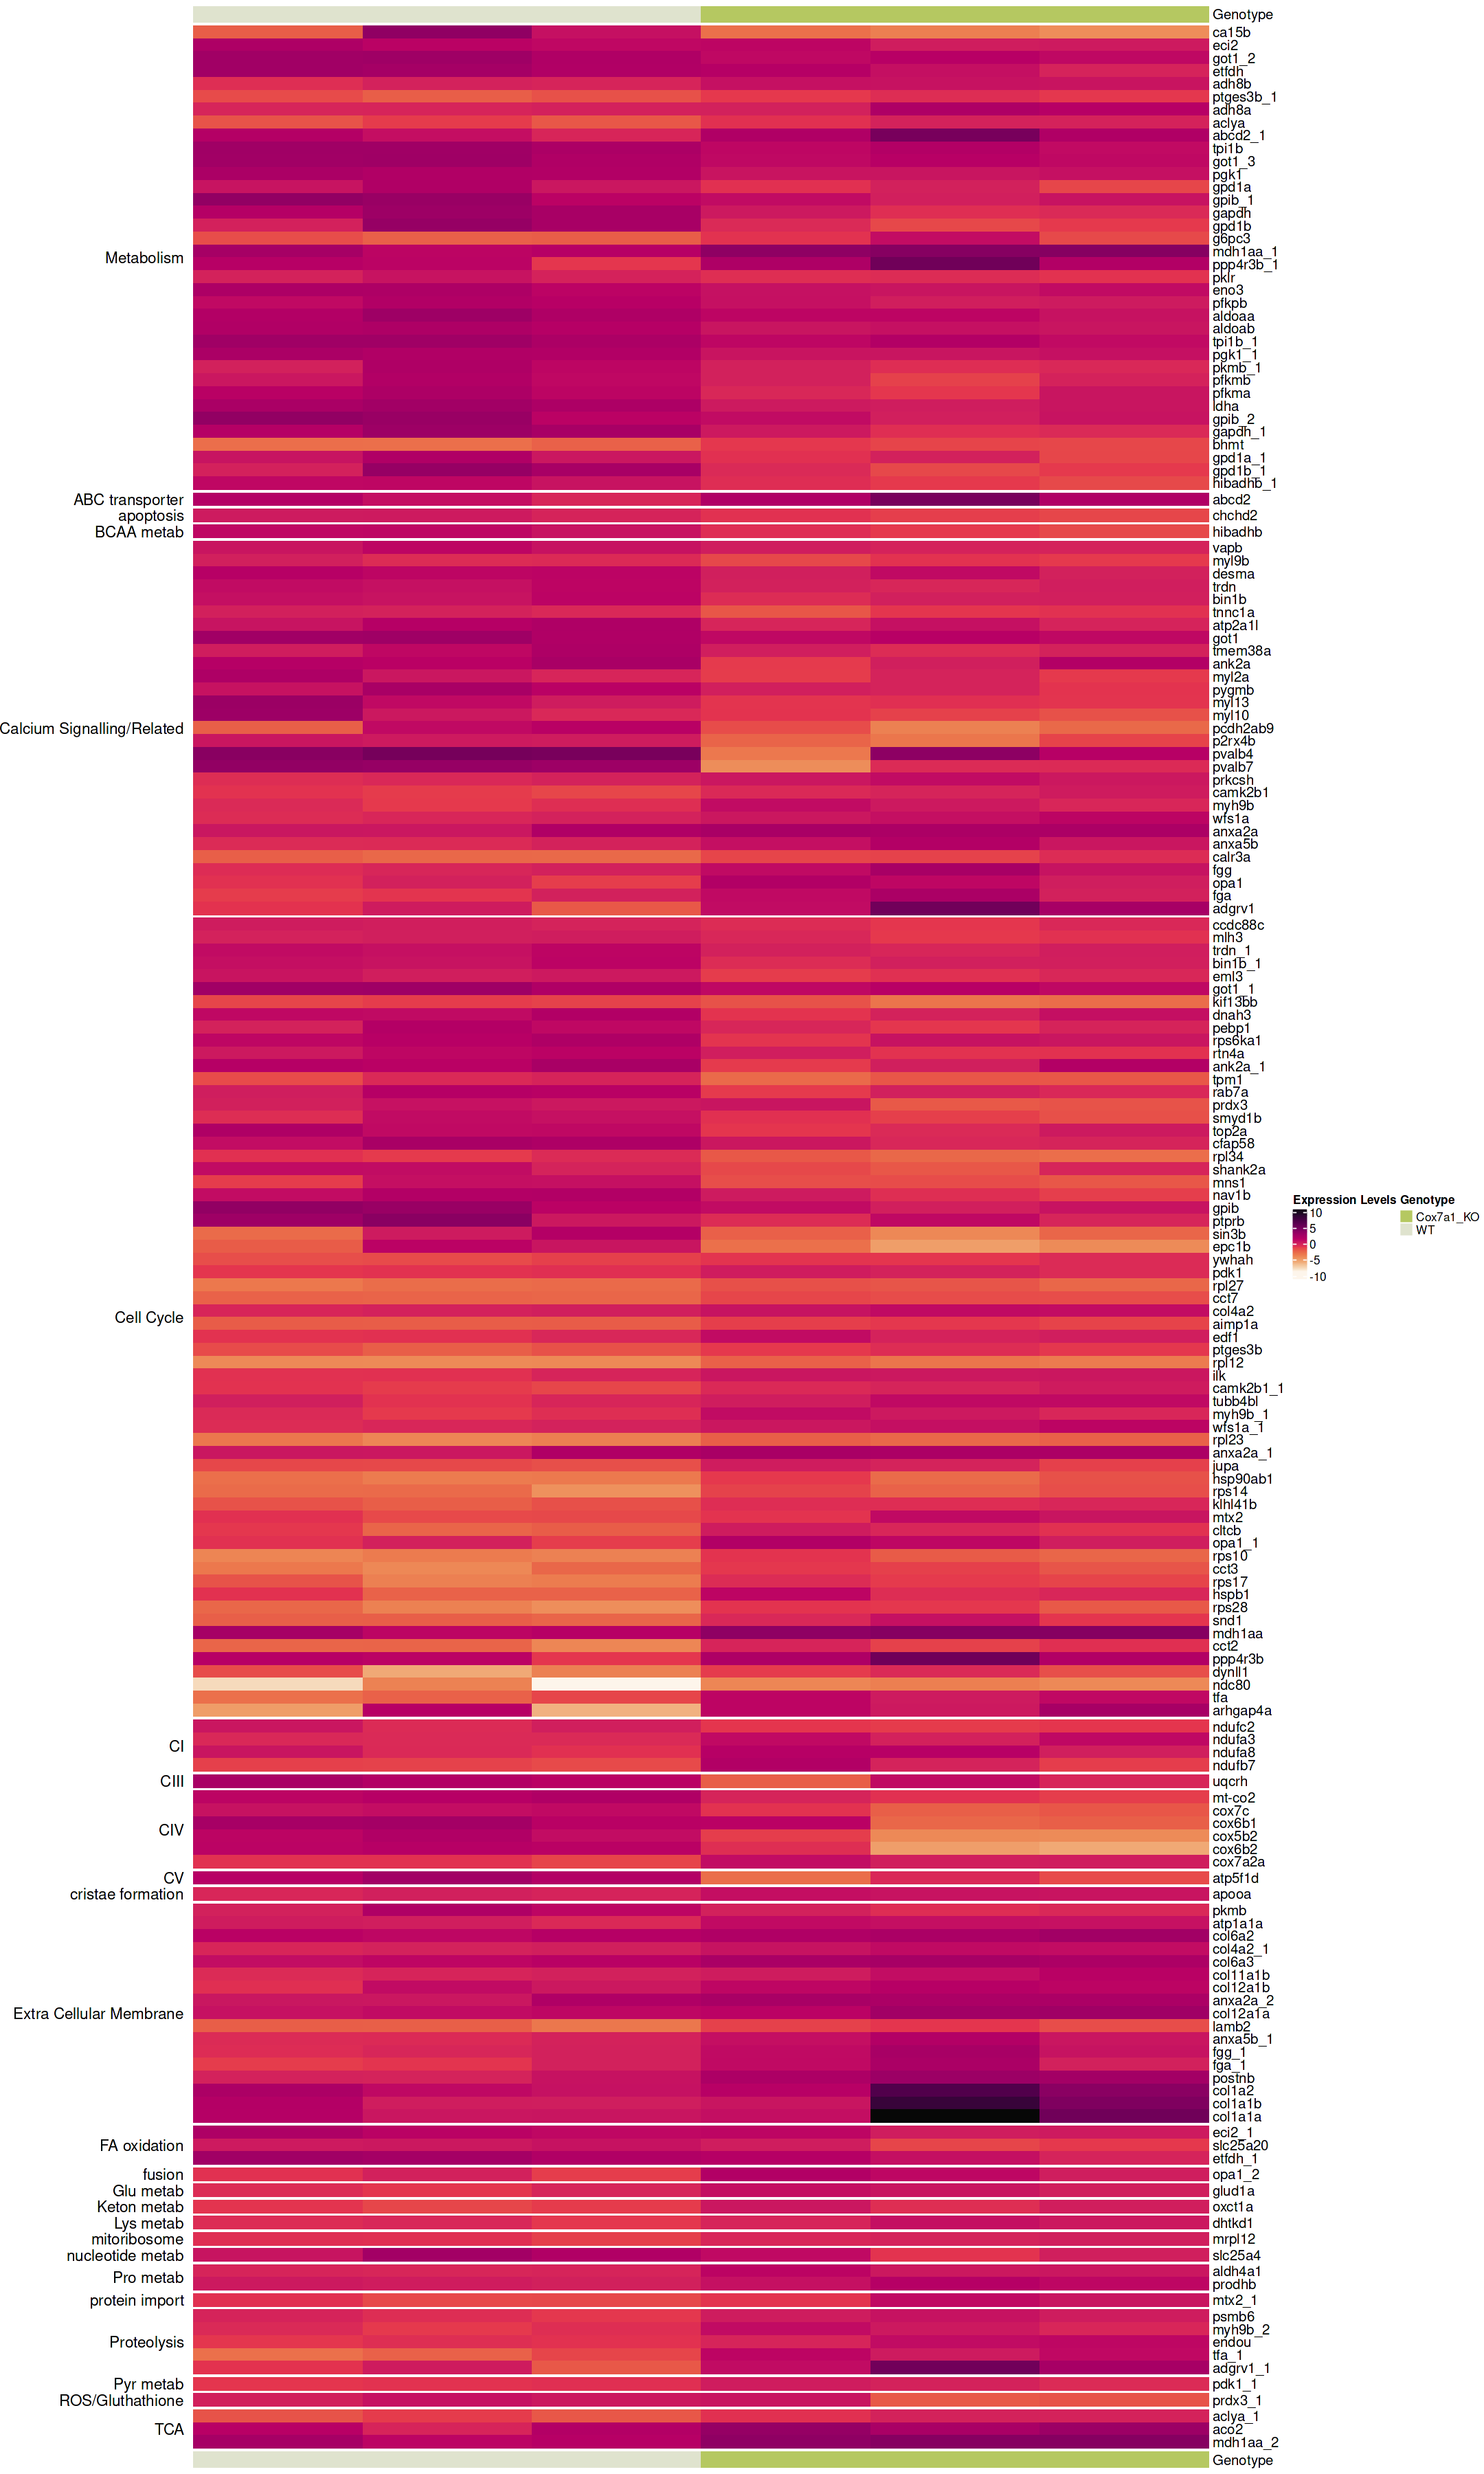

In [24]:
# make bigger graph
options(repr.plot.width=18, repr.plot.height=30)
ha = HeatmapAnnotation(
    Genotype = rep(c("WT","Cox7a1_KO" ), each=3), 
    col = list(Genotype = c(
                            "WT"=paletteer::paletteer_d("calecopal::arbutus", n=2)[1],
                            "Cox7a1_KO"=paletteer::paletteer_d("calecopal::arbutus", n=2)[2])
                
               )
)
Heatmap(heatmap_mat, name="Expression Levels",
 cluster_columns = FALSE,  
 cluster_rows = FALSE,  
row_dend_width = unit(0, "cm"), 
# col = viridis::viridis(100, direction = -1),
col= paletteer::paletteer_c("grDevices::Rocket", n=100, direction=-1),
show_column_names = FALSE,
top_annotation = ha,
row_split = factor(heatmap_list_unique$Label, levels = unique(heatmap_list_unique$Label)),
# order the splits by the order of the labels
# row_split_order = factor(heatmap_list_unique$Label),
row_title_rot = 0, 
# turn off the dendrogram

bottom_annotation = ha) 

pdf 
  3

png 
  2

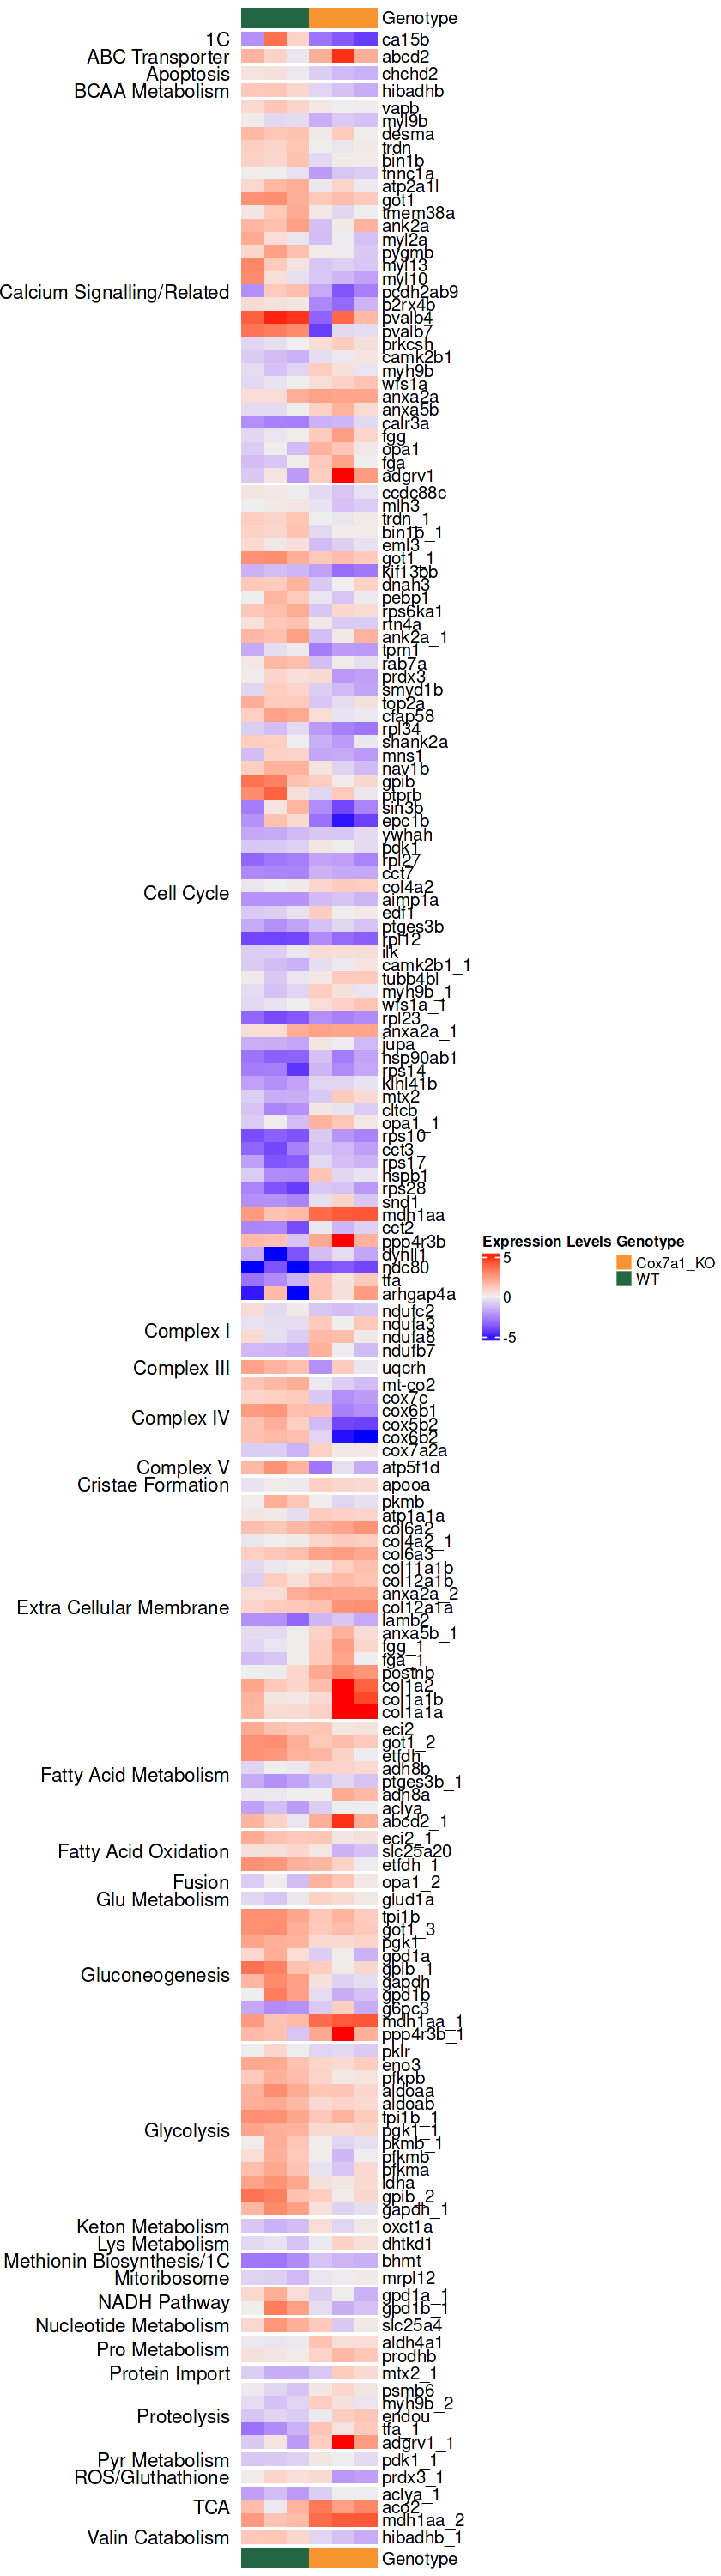

In [6]:
# make bigger graph
options(repr.plot.width=7, repr.plot.height=25)
ha = HeatmapAnnotation(
    Genotype = rep(c("WT","Cox7a1_KO" ), each=3), 
    col = list(Genotype = c(
                            "WT"="#226741",

                            "Cox7a1_KO"="#f69431")
               )
)

Heatmap(heatmap_mat, name="Expression Levels", 
 cluster_columns = FALSE,  
 cluster_rows = FALSE,  
row_dend_width = unit(0, "cm"), 
# col = viridis::viridis(100, direction = -1),
# col= paletteer::paletteer_c("grDevices::Rocket", n=100, direction=-1),
show_column_names = FALSE,
top_annotation = ha,
row_split = factor(heatmap_list_unique$OXPHOS.Complex, levels = unique(heatmap_list_unique$OXPHOS.Complex)),
row_title_rot = 0, 
bottom_annotation = ha)
dev.copy(pdf, file = "proteomics_n_3_muscle/muscle_heatmap_annotated.pdf", width = 7, height = 25)
dev.off()

In [13]:
heatmap_list_v2 <- read.xlsx("muscle for heat map_v2.xlsx", sheet = "Mitocarta", colNames = TRUE, detectDates = FALSE, skipEmptyRows = TRUE)
heatmap_list_v2$NOP[is.na(heatmap_list_v2$NOP)] <- 0
# Make the 1st letter of each word in the column OXPHOS.Complex	capital without using stringr::str_to_title
heatmap_list_v2$OXPHOS.Complex <- sapply(strsplit(as.character(heatmap_list_v2$OXPHOS.Complex), " "), function(x) paste(toupper(substring(x, 1,1)), substring(x, 2), sep="", collapse=" "))


heatmap_list_v2 %>% head
heatmap_list_v2 %>% dim

,Protein,AKO1,AKO2,AKO3,AWT1,AWT2,AWT3,NOP,adult_ko_vs_adult_wt_logFC,OXPHOS.Complex,Label
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
1,ndufa3,1.1054797,0.012593261,1.137783118,-0.326734128999999,-0.4195386593,-0.432190579,1,1.070056,Complex I,NA
2,ndufa8,1.594717603,1.501586096,0.150963366999999,0.621726396999999,-0.376139779,-0.784483896,9,1.262055,Complex I,NA
3,ndufb7,1.856295654,-0.061710999,-1.235054364,-1.317484943,-1.361814604,-1.620671223,5,1.619834,Complex I,NA
4,ndufc2,-0.99685305,-1.17236300099999,-0.994636413,0.567605263,-0.483926964999999,0.153062245,6,-1.133531,Complex I,NA
5,uqcrh,-2.320787564,1.053185371,-0.206646588999999,2.29753711399999,1.78187345199999,1.407000156,7,-2.320220,Complex III,NA
6,cox5b2,-1.239462898,-4.12699089799999,-4.23119880099999,1.29610152599999,1.901800391,0.969047741,9,-4.588201,Complex IV,NA


[1] 35 11

In [14]:
# if a protein is duplicated in a OXPHOS.Complex, select the one with the highest NOP
heatmap_list_v2$OXPHOS.Complex %>% unique
heatmap_list_v2$OXPHOS.Complex %>% unique %>% length
heatmap_list_v2_unique <- heatmap_list_v2 %>% group_by(OXPHOS.Complex, Protein) %>% filter(NOP == max(NOP)) %>% ungroup()
# if two proteins are duplicated in a OXPHOS.Complex still and have same NOP then select the top one
heatmap_list_v2_unique <- heatmap_list_v2_unique %>% group_by(OXPHOS.Complex, Protein) %>% filter(adult_ko_vs_adult_wt_logFC == max(adult_ko_vs_adult_wt_logFC)) %>% ungroup()
# if still two proteins are duplicated in a OXPHOS.Complex, then select the first one
heatmap_list_v2_unique <- heatmap_list_v2_unique %>% group_by(OXPHOS.Complex, Protein) %>% filter(row_number() == 1) %>% ungroup()
order_heatmap <- heatmap_list_v2_unique$OXPHOS.Complex %>% unique# %>% dim
unique(heatmap_list_v2_unique$OXPHOS.Complex)
heatmap_list_v2_unique$OXPHOS.Complex %>% unique %>% length
heatmap_list_v2_unique[duplicated(heatmap_list_v2_unique$Protein)|duplicated(heatmap_list_v2_unique$Protein,fromLast = TRUE),] %>% dim


# arrange by first alphabetically OXPHOS.Complex as in order_heatmap and then by log2fc
heatmap_list_v2_unique <- heatmap_list_v2_unique %>% arrange(factor(OXPHOS.Complex, levels = order_heatmap), adult_ko_vs_adult_wt_logFC)



# heatmap_list_v2_unique <- heatmap_list_v2_unique %>% arrange(adult_ko_vs_adult_wt_logFC)



heatmap_list_v2_unique$unique_rownames <- make.unique(heatmap_list_v2_unique$Protein,sep="_")
heatmap_list_v2_unique <-heatmap_list_v2_unique %>%  dplyr::select("unique_rownames", everything())
heatmap_list_v2_unique %>% head
# make a matrix with the unique proteins
heatmap_mat_v2 <- heatmap_list_v2_unique %>% as.data.frame()
rownames(heatmap_mat_v2) <- heatmap_list_v2_unique$unique_rownames
heatmap_mat_v2 <- heatmap_mat_v2 %>% dplyr::select(-unique_rownames, -Protein, -OXPHOS.Complex, -NOP,	-adult_ko_vs_adult_wt_logFC,	-Label)



# make all columns numeric
heatmap_mat_v2 <- heatmap_mat_v2 %>% mutate_all(as.numeric)
heatmap_mat_v2 <- heatmap_mat_v2 %>% dplyr::select(contains("WT"), contains("KO"))
heatmap_mat_v2 <- as.matrix(heatmap_mat_v2)
# make columns WT and then KO


# heatmap_mat_v2 %>% head

[1] "Complex I"             "Complex III"           "Complex IV"           
 [4] "Complex V"             "BCAA Metabolism"       "Glu Metabolism"       
 [7] "Lys Metabolism"        "Pro Metabolism"        "Ketone Metabolism"    
[10] "Pyr Metabolism"        "TCA"                   "ROS/Gluthathione"     
[13] "Fatty Acid Oxidation"  "Nucleotide Metabolism" "Mitoribosome"         
[16] "Apoptosis"             "Cristae Formation"     "Fusion"               
[19] "Protein Import"        "ABC Transporter"

[1] 20

[1] "Complex I"             "Complex III"           "Complex IV"           
 [4] "Complex V"             "BCAA Metabolism"       "Glu Metabolism"       
 [7] "Lys Metabolism"        "Pro Metabolism"        "Ketone Metabolism"    
[10] "Pyr Metabolism"        "TCA"                   "ROS/Gluthathione"     
[13] "Fatty Acid Oxidation"  "Nucleotide Metabolism" "Mitoribosome"         
[16] "Apoptosis"             "Cristae Formation"     "Fusion"               
[19] "Protein Import"        "ABC Transporter"

[1] 20

[1]  0 11

unique_rownames,Protein,AKO1,AKO2,AKO3,AWT1,AWT2,AWT3,NOP,adult_ko_vs_adult_wt_logFC,OXPHOS.Complex,Label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
ndufc2,ndufc2,-0.99685305,-1.17236300099999,-0.994636413,0.567605263,-0.483926964999999,0.153062245,6,-1.133531,Complex I,NA
ndufa3,ndufa3,1.1054797,0.012593261,1.137783118,-0.326734128999999,-0.4195386593,-0.432190579,1,1.070056,Complex I,NA
ndufa8,ndufa8,1.594717603,1.501586096,0.150963366999999,0.621726396999999,-0.376139779,-0.784483896,9,1.262055,Complex I,NA
ndufb7,ndufb7,1.856295654,-0.061710999,-1.235054364,-1.317484943,-1.361814604,-1.620671223,5,1.619834,Complex I,NA
uqcrh,uqcrh,-2.320787564,1.053185371,-0.206646588999999,2.29753711399999,1.78187345199999,1.407000156,7,-2.320220,Complex III,NA
cox7a1,cox7a1,-4.97990809499999,-5.99686505499999,-6.519969016,0.857542129,1.55188729,1.36497544899999,2,-7.090382,Complex IV,NA


In [15]:
unique(heatmap_list_v2_unique$OXPHOS.Complex)

[1] "Complex I"             "Complex III"           "Complex IV"           
 [4] "Complex V"             "BCAA Metabolism"       "Glu Metabolism"       
 [7] "Lys Metabolism"        "Pro Metabolism"        "Ketone Metabolism"    
[10] "Pyr Metabolism"        "TCA"                   "ROS/Gluthathione"     
[13] "Fatty Acid Oxidation"  "Nucleotide Metabolism" "Mitoribosome"         
[16] "Apoptosis"             "Cristae Formation"     "Fusion"               
[19] "Protein Import"        "ABC Transporter"

pdf 
  3

png 
  2

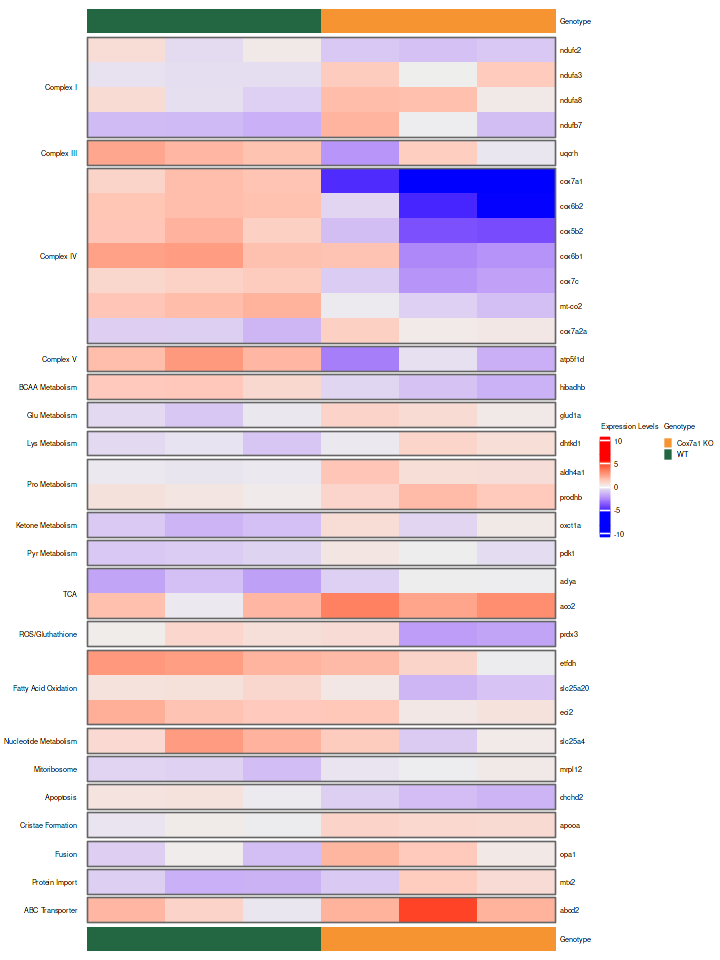

In [16]:
# make bigger graph
options(repr.plot.width=6, repr.plot.height=8)
ha = HeatmapAnnotation(
    Genotype = rep(c("WT","Cox7a1 KO" ), each=3), 
    col = list(Genotype = c(
                # "WT"=paletteer::paletteer_d("calecopal::arbutus", n=2)[1],
                            "WT"="#226741",
                            # "Cox7a1_KO"=paletteer::paletteer_d("calecopal::arbutus", n=2)[2])
                            "Cox7a1 KO"="#f69431")
                
               ),
               # change font size of the annotation
                annotation_name_gp = grid::gpar(fontsize = 4),
                annotation_legend_param = list(
        # title = "Expression Levels",
        title_gp = gpar(fontsize = 4),
        labels_gp = gpar(fontsize = 4),
        grid_width	= unit(5,"point"),
        grid_height	= unit(5,"point")),
        height=unit(0,"point")
        )

Heatmap(heatmap_mat_v2, name="Expression Levels", 
 cluster_columns = FALSE,  
 cluster_rows = FALSE,  
row_dend_width = unit(0, "point"), 

show_column_names = FALSE,
top_annotation = ha,
row_split = factor(heatmap_list_v2_unique$OXPHOS.Complex, levels = unique(heatmap_list_v2_unique$OXPHOS.Complex)),
gap=unit(2, "point"),
border= TRUE,
 border_gp = gpar(col = "grey40"),
row_title_gp = gpar(fontsize = 4), # change row split font size
row_title_rot = 0, 
bottom_annotation = ha,
heatmap_legend_param = list(
        title = "Expression Levels",
        title_gp = gpar(fontsize = 4),
        labels_gp = gpar(fontsize = 4),
        grid_width	= unit(5, "point"),
        grid_height	= unit(5, "point")
    ),
row_names_gp = grid::gpar(fontsize = 4))

dev.copy(pdf, file = "proteomics_n_3_muscle/muscle_heatmap_annotated_v5_mitocarta.pdf", width = 2.5, height = 3)
dev.off()

In [18]:
heatmap_list_v2_others <- read.xlsx("muscle for heat map_v2.xlsx", sheet = "other", colNames = TRUE, detectDates = FALSE, skipEmptyRows = TRUE)
heatmap_list_v2_others$NOP[is.na(heatmap_list_v2_others$NOP)] <- 0
# rename column X10 to Oxphos.Complex
heatmap_list_v2_others <- heatmap_list_v2_others %>% dplyr::rename(OXPHOS.Complex = X10)
# Make the 1st letter of each word in the column OXPHOS.Complex	capital without using stringr::str_to_title
heatmap_list_v2_others$OXPHOS.Complex <- sapply(strsplit(as.character(heatmap_list_v2_others$OXPHOS.Complex), " "), function(x) paste(toupper(substring(x, 1,1)), substring(x, 2), sep="", collapse=" "))


heatmap_list_v2_others %>% head
heatmap_list_v2_others %>% dim

,Protein,AKO1,AKO2,AKO3,AWT1,AWT2,AWT3,NOP,adult_ko_vs_adult_wt_logFC,OXPHOS.Complex,Label
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ca15b,-3.0425373339999999,-3.6847031299999999,-4.3308193990000001,-2.3226961689999999,3.644001684,0.82110578199999995,0,-4.40015705333333,Methionine Biosynthesis/1 Carbon Cycle,Metabolism
2,prodhb,0.825963545,1.645838796,1.194595321,0.416171817,0.269526692,0.0835982239999999,5,0.965700309666667,Amino Acid Metabolism,Metabolism
3,got1,1.1399147060000001,1.514717678,1.119664945,2.7383690619999999,2.8757712679999998,1.9455511379999999,25,-1.26179804633333,Amino Acid Metabolism,Metabolism
4,eci2,1.2319295400000001,0.23109229000000001,0.39795231199999997,2.045460442,1.3779658100000001,1.1515149360000001,18,-0.904655682,Fatty Acid Metabolism,Metabolism
5,eci2,1.2319295400000001,0.23109229000000001,0.39795231199999997,2.045460442,1.3779658100000001,1.1515149360000001,18,-0.904655682,Fatty Acid Metabolism,Metabolism
6,adh8b,0.807751412,0.75740625500000003,0.65509607199999997,-0.63396158999999996,2.5298880000000001E-3,-0.16807915500000001,10,1.00658819866667,Fatty Acid Metabolism,Metabolism


[1] 151  11

In [19]:
# if a protein is duplicated in a OXPHOS.Complex, select the one with the highest NOP
heatmap_list_v2_others$OXPHOS.Complex %>% unique
heatmap_list_v2_others$OXPHOS.Complex %>% unique %>% length
heatmap_list_v2_others_unique <- heatmap_list_v2_others %>% group_by(OXPHOS.Complex, Protein) %>% filter(NOP == max(NOP)) %>% ungroup()
# if two proteins are duplicated in a OXPHOS.Complex still and have same NOP then select the top one
heatmap_list_v2_others_unique <- heatmap_list_v2_others_unique %>% group_by(OXPHOS.Complex, Protein) %>% filter(adult_ko_vs_adult_wt_logFC == max(adult_ko_vs_adult_wt_logFC)) %>% ungroup()
# if still two proteins are duplicated in a OXPHOS.Complex, then select the first one
heatmap_list_v2_others_unique <- heatmap_list_v2_others_unique %>% group_by(OXPHOS.Complex, Protein) %>% filter(row_number() == 1) %>% ungroup()
order_heatmap <- heatmap_list_v2_others_unique$OXPHOS.Complex %>% unique# %>% dim
unique(heatmap_list_v2_others_unique$OXPHOS.Complex)
heatmap_list_v2_others_unique$OXPHOS.Complex %>% unique %>% length
heatmap_list_v2_others_unique[duplicated(heatmap_list_v2_others_unique$Protein)|duplicated(heatmap_list_v2_others_unique$Protein,fromLast = TRUE),] %>% dim


# arrange by first alphabetically OXPHOS.Complex as in order_heatmap and then by log2fc
heatmap_list_v2_others_unique <- heatmap_list_v2_others_unique %>% arrange(factor(OXPHOS.Complex, levels = order_heatmap), adult_ko_vs_adult_wt_logFC)



# heatmap_list_v2_others_unique <- heatmap_list_v2_others_unique %>% arrange(adult_ko_vs_adult_wt_logFC)



heatmap_list_v2_others_unique$unique_rownames <- make.unique(heatmap_list_v2_others_unique$Protein,sep="_")
heatmap_list_v2_others_unique <-heatmap_list_v2_others_unique %>%  dplyr::select("unique_rownames", everything())
heatmap_list_v2_others_unique %>% head
# make a matrix with the unique proteins
heatmap_mat_v2_others <- heatmap_list_v2_others_unique %>% as.data.frame()
rownames(heatmap_mat_v2_others) <- heatmap_list_v2_others_unique$unique_rownames
heatmap_mat_v2_others <- heatmap_mat_v2_others %>% dplyr::select(-unique_rownames, -Protein, -OXPHOS.Complex, -NOP,	-adult_ko_vs_adult_wt_logFC,	-Label)



# make all columns numeric
heatmap_mat_v2_others <- heatmap_mat_v2_others %>% mutate_all(as.numeric)
heatmap_mat_v2_others <- heatmap_mat_v2_others %>% dplyr::select(contains("WT"), contains("KO"))
heatmap_mat_v2_others <- as.matrix(heatmap_mat_v2_others)
# make columns WT and then KO


# heatmap_mat_v2_others %>% head

[1] "Methionine Biosynthesis/1 Carbon Cycle"
 [2] "Amino Acid Metabolism"                 
 [3] "Fatty Acid Metabolism"                 
 [4] "Gluconeogenesis"                       
 [5] "Glycogenolysis"                        
 [6] "Glycolysis"                            
 [7] "NADH Pathway"                          
 [8] "TCA"                                   
 [9] "ECM"                                   
[10] "Muscle"                                
[11] "Proteosomal Degradation/Proteolysis"   
[12] "Calcium Signaling And Related"

[1] 12

[1] "Methionine Biosynthesis/1 Carbon Cycle"
 [2] "Amino Acid Metabolism"                 
 [3] "Fatty Acid Metabolism"                 
 [4] "Gluconeogenesis"                       
 [5] "Glycogenolysis"                        
 [6] "Glycolysis"                            
 [7] "NADH Pathway"                          
 [8] "TCA"                                   
 [9] "ECM"                                   
[10] "Muscle"                                
[11] "Proteosomal Degradation/Proteolysis"   
[12] "Calcium Signaling And Related"

[1] 12

[1] 66 11

unique_rownames,Protein,AKO1,AKO2,AKO3,AWT1,AWT2,AWT3,NOP,adult_ko_vs_adult_wt_logFC,OXPHOS.Complex,Label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ca15b,ca15b,-3.0425373339999999,-3.6847031299999999,-4.3308193990000001,-2.3226961689999999,3.644001684,0.82110578199999995,0,-4.40015705333333,Methionine Biosynthesis/1 Carbon Cycle,Metabolism
bhmt,bhmt,-1.0651798960000001,-1.4252517730000001,-1.546969397,-2.9611584369999999,-2.9815290569999999,-2.4347812129999999,7,1.44668921366667,Methionine Biosynthesis/1 Carbon Cycle,Metabolism
got1,got1,1.1399147060000001,1.514717678,1.119664945,2.7383690619999999,2.8757712679999998,1.9455511379999999,25,-1.26179804633333,Amino Acid Metabolism,Metabolism
hibadhb,hibadhb,-0.62647845999999996,-1.103564789,-1.596652081,1.1568959990000001,1.223353962,0.71223345800000004,19,-2.13972624966667,Amino Acid Metabolism,Metabolism
prodhb,prodhb,0.825963545,1.645838796,1.194595321,0.416171817,0.269526692,0.0835982239999999,5,0.965700309666667,Amino Acid Metabolism,Metabolism
eci2,eci2,1.2319295400000001,0.23109229000000001,0.39795231199999997,2.045460442,1.3779658100000001,1.1515149360000001,18,-0.904655682,Fatty Acid Metabolism,Metabolism


In [20]:
unique(heatmap_list_v2_unique$OXPHOS.Complex)

[1] "Complex I"             "Complex III"           "Complex IV"           
 [4] "Complex V"             "BCAA Metabolism"       "Glu Metabolism"       
 [7] "Lys Metabolism"        "Pro Metabolism"        "Ketone Metabolism"    
[10] "Pyr Metabolism"        "TCA"                   "ROS/Gluthathione"     
[13] "Fatty Acid Oxidation"  "Nucleotide Metabolism" "Mitoribosome"         
[16] "Apoptosis"             "Cristae Formation"     "Fusion"               
[19] "Protein Import"        "ABC Transporter"

pdf 
  3

png 
  2

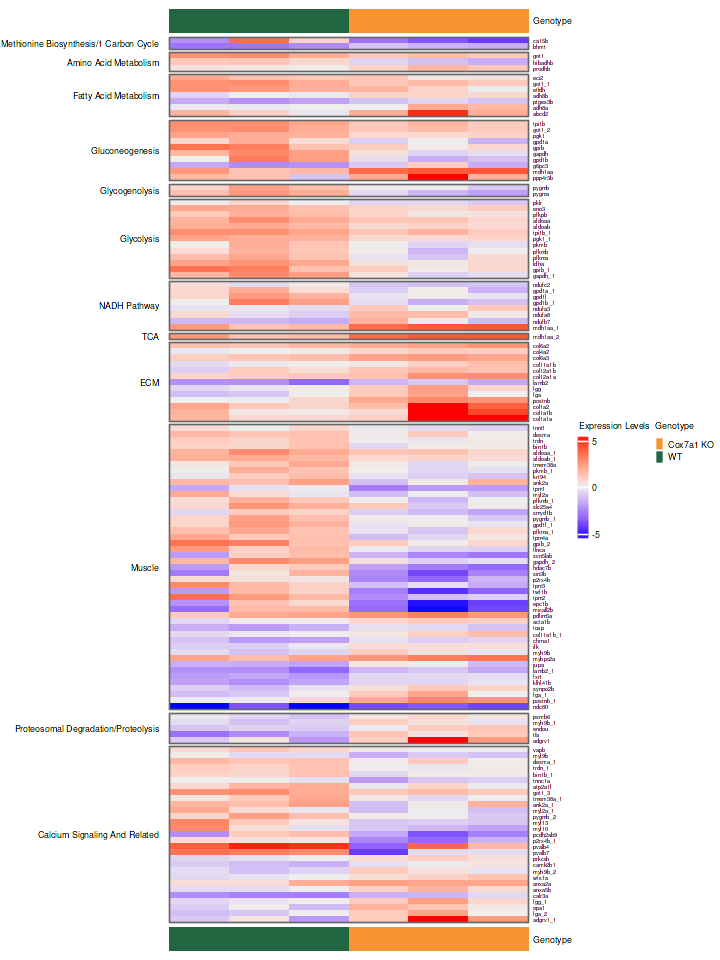

In [21]:
# make bigger graph
options(repr.plot.width=6, repr.plot.height=8)
ha = HeatmapAnnotation(
    Genotype = rep(c("WT","Cox7a1 KO" ), each=3), 
    col = list(Genotype = c(
                # "WT"=paletteer::paletteer_d("calecopal::arbutus", n=2)[1],
                            "WT"="#226741",
                            # "Cox7a1_KO"=paletteer::paletteer_d("calecopal::arbutus", n=2)[2])
                            "Cox7a1 KO"="#f69431")
                
               ),
               # change font size of the annotation
                annotation_name_gp = grid::gpar(fontsize = 5),
                annotation_legend_param = list(
        # title = "Expression Levels",
        title_gp = gpar(fontsize = 5),
        labels_gp = gpar(fontsize = 5),
        grid_width	= unit(5,"point"),
        grid_height	= unit(5,"point")

        
))

Heatmap(heatmap_mat_v2_others, name="Expression Levels", 
 cluster_columns = FALSE,  
 cluster_rows = FALSE,  
row_dend_width = unit(0, "cm"), 
# col = viridis::viridis(100, direction = -1),
# col= paletteer::paletteer_c("grDevices::Rocket", n=100, direction=-1),
show_column_names = FALSE,
top_annotation = ha,
row_split = factor(heatmap_list_v2_others_unique$OXPHOS.Complex, levels = unique(heatmap_list_v2_others_unique$OXPHOS.Complex)),
gap=unit(2, "point"),
border= TRUE,
 border_gp = gpar(col = "grey40"),
row_title_gp = gpar(fontsize = 5), # change row split font size
row_title_rot = 0, 
bottom_annotation = ha,
heatmap_legend_param = list(
        title = "Expression Levels",
        title_gp = gpar(fontsize = 5),
        labels_gp = gpar(fontsize = 5),
        grid_width	= unit(5,"point"),
        grid_height	= unit(5,"point")
    ),
row_names_gp = grid::gpar(fontsize = 3))

dev.copy(pdf, file = "proteomics_n_3_muscle/muscle_heatmap_annotated_v5_others.pdf", width = 4, height = 8)
dev.off()

# Volcano Plot

In [11]:
# description_df_mouse_zf %>% colnames 
description_df_mouse_zf_volcano <- description_df_mouse_zf %>% dplyr::select(gene,  AKO1, AKO2, AKO3, AWT1, AWT2,AWT3, adult_ko_vs_adult_wt_P.Value, adult_ko_vs_adult_wt_logFC, NOP)
# rename adult_ko_vs_adult_wt_P.Value	to pval adult_ko_vs_adult_wt_logFC to logFoldChange
description_df_mouse_zf_volcano <- description_df_mouse_zf_volcano %>% dplyr::rename(pval = adult_ko_vs_adult_wt_P.Value, logFoldChange = adult_ko_vs_adult_wt_logFC)
description_df_mouse_zf_volcano <- description_df_mouse_zf_volcano %>% distinct
description_df_mouse_zf_volcano <- description_df_mouse_zf_volcano %>% group_by(gene) %>% filter(NOP == max(NOP)) %>% ungroup()
description_df_mouse_zf_volcano <- description_df_mouse_zf_volcano %>% group_by(gene) %>% filter(logFoldChange == max(logFoldChange)) %>% ungroup()
# convert columns except gene to numeric
description_df_mouse_zf_volcano <- description_df_mouse_zf_volcano %>% mutate_at(vars(contains("AKO")), as.numeric)
description_df_mouse_zf_volcano <- description_df_mouse_zf_volcano %>% mutate_at(vars(contains("AWT")), as.numeric)
description_df_mouse_zf_volcano <- description_df_mouse_zf_volcano %>% mutate_at(vars(contains("NOP")), as.numeric)
description_df_mouse_zf_volcano <- description_df_mouse_zf_volcano %>% mutate_at(vars(contains("logFoldChange")), as.numeric)
description_df_mouse_zf_volcano <- description_df_mouse_zf_volcano %>% mutate_at(vars(contains("pval")), as.numeric)



description_df_mouse_zf_volcano %>% colnames()
description_df_mouse_zf_volcano %>% dim()
description_df_mouse_zf_volcano %>% str
# description_df_mouse_zf_volcano %>% arrange(desc(abs(logFoldChange))) %>%  head()


[1] "gene"          "AKO1"          "AKO2"          "AKO3"         
 [5] "AWT1"          "AWT2"          "AWT3"          "pval"         
 [9] "logFoldChange" "NOP"

[1] 1357   10

tibble [1,357 × 10] (S3: tbl_df/tbl/data.frame)
 $ gene         : chr [1:1357] "aamdc" "aars1" "aass" "abcb10" ...
 $ AKO1         : num [1:1357] 1.467 -1.353 0.73 0.285 0.397 ...
 $ AKO2         : num [1:1357] -0.574 -1.575 1.312 1.243 -0.266 ...
 $ AKO3         : num [1:1357] -1.865 -1.795 0.289 0.623 -0.657 ...
 $ AWT1         : num [1:1357] 0.2673 -2.832 0.5338 0.2188 -0.0145 ...
 $ AWT2         : num [1:1357] -0.2308 -2.542 0.0574 0.0966 0.5438 ...
 $ AWT3         : num [1:1357] 0.921 -2.68 -0.985 0.781 -0.515 ...
 $ pval         : num [1:1357] 0.42827 0.00561 0.20987 0.39661 0.72744 ...
 $ logFoldChange: num [1:1357] -0.643 1.11 0.909 0.352 -0.18 ...
 $ NOP          : num [1:1357] 2 8 10 6 1 5 4 29 14 27 ...


In [4]:
# make a volcano plot for description_df_mouse_zf only for AKO and AWT columns 
####################
#                  #
# VOLCANO FUNCTION #
#                  #
####################
require(ggplot2)
require(ggrepel)
require(clusterProfiler)
require(tidyverse)

draw_volcano<- function(fileinput, title) {
  # read input file
  # drawing plots
  ggplot(data =fileinput , aes(x = logFoldChange, y = -log10(pval))) +
    # draw lines
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", col = "gray50") +
    geom_hline(yintercept = -log10(0.05), linetype = "dotted", col = "gray50") +
    geom_vline(xintercept = 0, linetype = "dashed")+
    # draw points
    geom_point(x = fileinput$logFoldChange, y = -log10(fileinput$pval),alpha = 0.5, size = 2,color="grey51") +
    # draw coloured points
    geom_point(data = fileinput[which(fileinput$pval < 0.05 & fileinput$logFoldChange < -1),],
               aes(x=logFoldChange, y = -log10(pval)), shape = 21, color = 
              #  "#226741", fill = "#226741",
              "green", fill = "green",
               alpha = 0.8, size = 2) +
    geom_point(data = fileinput[which(fileinput$pval < 0.05 & fileinput$logFoldChange > 1),],
               aes(x=logFoldChange, y = -log10(pval)), shape = 21, color = 
              #  "#f69431", fill = "#f69431",
               "magenta", fill = "magenta",alpha = 0.8, size = 2) +
    # x axis scale
    scale_x_continuous(breaks = seq(round(min(fileinput$logFoldChange)- 0.5),round(max(fileinput$logFoldChange)+ 0.5),by = 1), limits = c(round(min(fileinput$logFoldChange)-1),round(max(fileinput$logFoldChange)+1))) + xlab("logFoldChange") + #ylab("-Log10(p.value)") +
    
    scale_y_continuous(breaks = seq(0,round(-log10(min(fileinput$pval))+1),by = 4), limits = c(0,round(-log10(min(fileinput$pval))+1))) + ylab("-Log10(pvalue)") + # ylab("-log10(p.value)")+
    
    # set title
    ggtitle(title)+
    # x and y axis limits
    # black and white theme
    theme_bw() +
    # center title
    theme(plot.title = element_text(hjust = 0.5), axis.text = element_text(size = 10), axis.title.x = element_text(size = 10),
          axis.title.y = element_text(size = 10))
}
###################


Loading required package: ggrepel



In [120]:
description_df_mouse_zf_volcano %>% head

gene,AKO1,AKO2,AKO3,AWT1,AWT2,AWT3,pval,logFoldChange,NOP
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
aamdc,1.4667515,-0.5739485,-1.8653050,0.26725443,-0.23076900,0.9212840,0.428266461,-0.6434238,2
aars1,-1.3534255,-1.5746633,-1.7947352,-2.83197660,-2.54200323,-2.6800583,0.005605508,1.1104047,8
aass,0.7297959,1.3124487,0.2894110,0.53375739,0.05744185,-0.9853736,0.209867021,0.9086100,10
abcb10,0.2852603,1.2430460,0.6226768,0.21875262,0.09663467,0.7806194,0.396607169,0.3516588,6
abcb11b,0.3971808,-0.2657106,-0.6573271,-0.01452689,0.54376251,-0.5148912,0.727444898,-0.1800671,1
ablim2,-0.2003520,0.6691284,-0.4681791,-0.94017916,0.52021203,0.8917863,0.798302666,-0.1570739,5


In [6]:
description_df_mouse_zf_volcano %>% filter(gene=="cox7a1")

gene,AKO1,AKO2,AKO3,AWT1,AWT2,AWT3,pval,logFoldChange,NOP
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cox7a1,-4.979908,-5.996865,-6.519969,0.8575421,1.551887,1.364975,8.497674e-08,-7.090382,2


gene,AKO1,AKO2,AKO3,AWT1,AWT2,AWT3,pval,logFoldChange,NOP
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ptgr1,2.605453673,2.4928937,5.8000390,-2.2985536,-2.80149612,-3.0319917,2.480240e-05,6.343476,9
col1a1a,0.900544733,10.5000921,5.3215073,1.6969782,0.59543050,0.6025185,4.078683e-02,4.609072,16
krt91,2.787074278,10.2051594,2.4975397,1.9635349,0.90497268,-0.9285402,3.921087e-02,4.516602,31
trim63b,-0.003286546,3.4160337,0.5978636,-2.7471222,-2.27077778,-4.2470609,6.601635e-03,4.425191,9
col6a3,3.754599029,5.5415015,4.4753234,0.9305037,0.47072754,0.2486165,3.558867e-05,4.040525,4
adgrv1,1.010816887,5.2496166,2.4561205,-0.8947797,0.33333846,-2.0750193,3.514955e-02,3.784338,1
col1a1b,0.612985860,8.3097809,4.5309082,1.7562204,0.23147725,0.2070651,4.472143e-02,3.752971,15
decr1,3.023227765,3.2854124,3.4034284,-0.2918824,-0.09239048,-1.1092500,1.728903e-05,3.735197,14
dnm2a,0.305747091,1.4828109,1.1581865,-2.5327060,-2.17898648,-2.5963649,1.055365e-05,3.418267,9


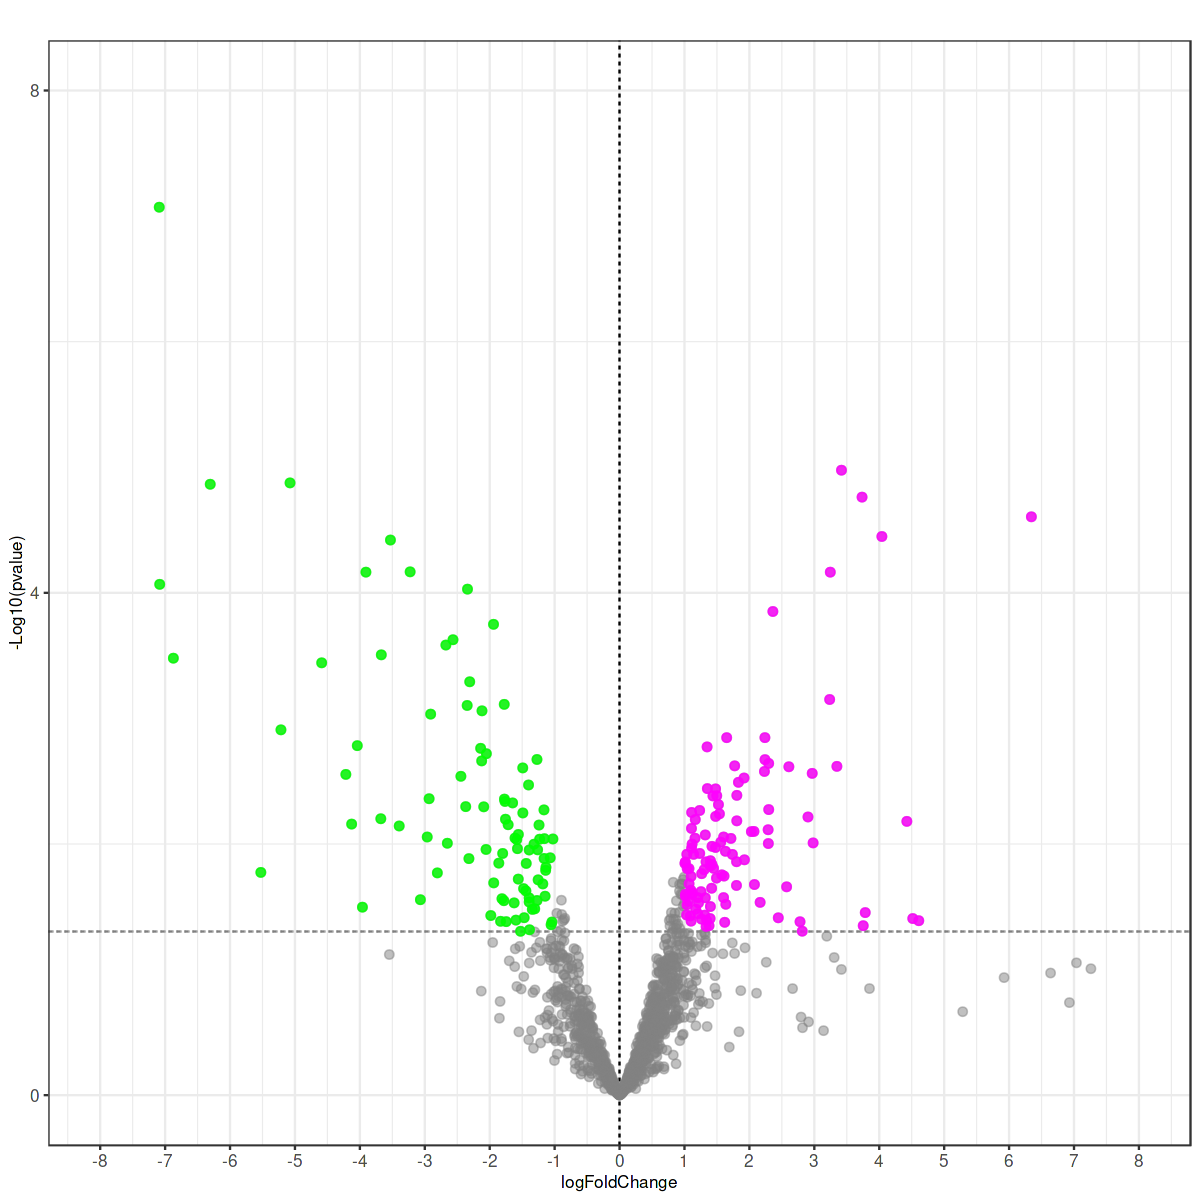

pdf 
  3

png 
  2

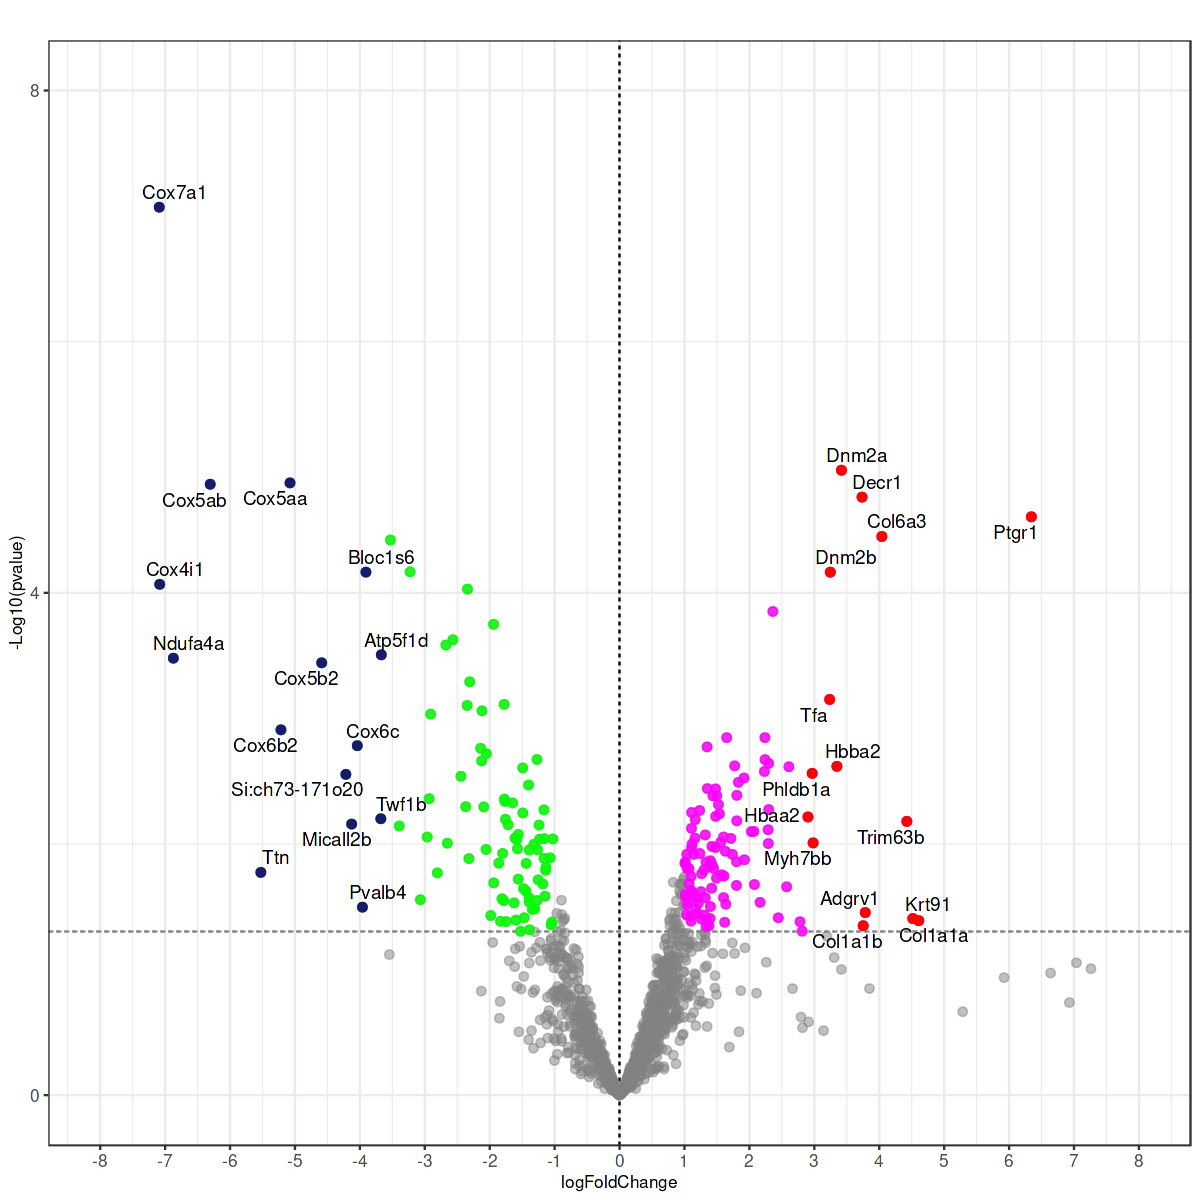

In [195]:

# change graph size
options(repr.plot.width=10, repr.plot.height=10)
b = draw_volcano(description_df_mouse_zf_volcano,"")
print(b)
# #Set genes for marking 
# take top and bottom 20 genes according to logFoldChange
top_20_up <-  description_df_mouse_zf_volcano %>% arrange(desc(logFoldChange)) %>% filter(pval<0.05) %>% head(15)
top_20_up
top_20_down  <- description_df_mouse_zf_volcano %>% arrange(logFoldChange) %>% filter(pval<0.05) %>% head(15)
# top_20_down
top_20_updown <- rbind(top_20_up,top_20_down)
# top_20_updown


require(ggrepel)
#Paint the genes in the plot
c= b + geom_point(data=description_df_mouse_zf_volcano[description_df_mouse_zf_volcano$gene%in%top_20_updown$gene,],color=ifelse(description_df_mouse_zf_volcano[description_df_mouse_zf_volcano$gene%in%top_20_updown$gene,]$logFoldChange > 0,"red","midnightblue"),size=2) +
  geom_text_repel(data = description_df_mouse_zf_volcano[description_df_mouse_zf_volcano$gene%in%top_20_updown$gene,],aes(label=str_to_title((description_df_mouse_zf_volcano[description_df_mouse_zf_volcano$gene%in%top_20_updown$gene,]$gene)),
  ),#nudge_x = 0.5,
# nudge_y = 0.25,
# segment.size = 1
)
c


# # #Save the plot
dev.copy(
  pdf,
  file = "proteomics_n_3_muscle/muscle_volcano_magenta_green.pdf",
  width = 10,
  height = 10
)
dev.off()

# Save data and sessioninfo

In [190]:
save.image("./muscle_proteomics_n_3_12122023.RData")

In [11]:
load("./muscle_proteomics_n_3_12122023.RData")

In [12]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 22.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.10.0 
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.10.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_CH.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=de_CH.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=de_CH.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_CH.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Zurich
tzcode source: system (glibc)

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] biomaRt_2.56.1        viridis_0.6.3         viridisLite_0.4.2    
 [4] ggrepel_0.9.3         ggVennDiagram_1.2.3   limma_3.56.2         
 [7] openxlsx_4.2.5.2      paletteer_1.5.0 